__Author: Martin Ng__    
__Date: 05/02/21__

Purpose of this notebook is to explore the POALoanData set and to understand how the dataset can be processed as part of a pipeline for subsequent model building.

Scikit-Learn modules would be heavily used.

# Load Dependencies

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# stats
from scipy.stats import shapiro, chi2, chi2_contingency, boxcox, yeojohnson

# visualisation
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, Binarizer, binarize, OneHotEncoder, MinMaxScaler, QuantileTransformer, PowerTransformer , FunctionTransformer
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, classification_report, plot_confusion_matrix, log_loss, brier_score_loss
from sklearn.model_selection import learning_curve, RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer, make_column_transformer

# sklearn-pandas
from sklearn_pandas import DataFrameMapper, gen_features, NumericalTransformer

# Load Functions

In [2]:
# let define a chi-square-test
def chi_square(table, prob = 0.95):
    '''
    A utility function that performs a chi-square correlation test on a contingency table.
    '''   
    
    stat, p, dof, expected = chi2_contingency(table)

    # interpret test-statistic
    critical = chi2.ppf(prob, dof)
    
    print('Pearson Chi-squared\nprobability = %.3f, critical = %.3f, stat = %.3f' % (prob, critical, stat))
    
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance = %.3f, p = %.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
        
# lets further define a cramers_v function which quantifies the correlation between 2 cat:

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    v =  np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    print(f"Cramer's V = {v}")
    return v


# qq plot
def qq_plot(var, df, ax=None):
    '''
    Function which plots the QQ plot of a variable (var) belonging to a pandas dataframe (df, default = train)
    '''
    
    plt.style.use('ggplot')

    qqplot(df[var], line='s', ax=ax)
    
    plt.title('QQ Plot - ' + str(var).capitalize())

    plt.show()    


    
# numerical distribution plots
def numerical_plot(var, df, discrete=False, sparse=False, box_by=None, bins=100, dist_yscale='linear'):
    '''
    Function which plots various plots of a numerical variable (var) belonging to a pandas dataframe (df, default = train),
    such as the barplot or histogram, qq plot and box plot.
    
    discrete:   False - whether the numerical variable is a discrete numerical or a continuos 
    sparse:     False - whether the numerical variable has a huge proportion of zeros
    box_by:     None - group by variable for the box plot
    bins:       100 - default number of bins
    dist_yscale:'linear' - whether the barplot/histogram yscale should be linear or others.
    
    '''
    
    df = df.copy()
    # set up plot area
    plt.style.use('ggplot')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), gridspec_kw={'width_ratios': [3, 1.5, 1.5]})

    # continuous bar or discrete hist
    if discrete:
    
        data = df[var].value_counts(dropna=False).sort_index()
        if sparse:
            ax1.bar(data.index, data)
        
        else:
            data.plot(kind='bar', ax=ax1, rot=0)
                
    else:
        
        data = df[var]
        ax1.hist(data, bins=bins)
    
    # quantile lines
    quantile_list = [0, .25, .5, .75, 1.]
    quantiles = df[var].quantile(quantile_list)
        
    for quantile in quantiles:
        ax1.axvline(quantile, color='grey', linestyle=':')
    
    
    # boxplot
    box = df.boxplot(var, by=box_by, ax=ax2, showmeans=True, meanline=True, patch_artist=False)
        
    # labels
    xlabel = str(data.name).capitalize()
    grouplabel = str(box_by).capitalize()
    grouptitle = ' Grouped by '+ grouplabel
    
    # skewness
    ax1.text(0.9,0.9, s=f'Skew = {round(df[var].skew(),2)}', horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes)
    ax1.set_title(xlabel +' Distribution')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel("Counts")
    ax1.set_yscale(dist_yscale)
    
    box.get_figure().suptitle('')
    ax2.set_title(xlabel + grouptitle)
    ax2.set_xlabel(grouplabel)
    ax2.set_yscale(dist_yscale)
    
    # qq_plot
    qq_plot(var, ax=ax3, df=df)
    
#     plt.savefig('fig_'+xlabel +'_Distribution.jpeg')
    
    
    
def kde_target(var_name, df):
    '''
    Function which plots bar plots of a categorical variable (var) belonging to a pandas dataframe (df, default = train),
    and calculate the cramer's v and chhi-square coefficient with the 'defaulted' target variable. 
    
    grp_by:   'defaulted' - group by variable for the plot
    
    '''    
    
    df = df.copy()
    
    plt.style.use('ggplot')
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['defaulted'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_non_default = df.loc[df['defaulted'] == 0, var_name].median()
    avg_defaulted = df.loc[df['defaulted'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['defaulted'] == 1, var_name], label = 'defaulted == 1')
    sns.kdeplot(df.loc[df['defaulted'] == 0, var_name], label = 'defaulted == 0')
    
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that is non-default = %0.4f' % avg_non_default)
    print('Median value for loan that defaulted =     %0.4f' % avg_defaulted)
    plt.show()


# cat plot
def cat_plot(var, df, grp_by='defaulted'):
    '''
    Function which plots bar plots of a categorical variable (var) belonging to a pandas dataframe (df, default = train),
    and calculate the cramer's v and chhi-square coefficient with the 'defaulted' target variable. 
    
    grp_by:   'defaulted' - group by variable for the plot
    
    '''    
    
    plt.style.use('ggplot')
    df = df.copy()
    
    table = pd.crosstab(df[var], df["defaulted"]).to_numpy()
    cramers_v(table)
    chi_square(table)
    
    data = pd.crosstab(df[grp_by].fillna('NaN'), df[var].fillna('NaN'), dropna=False)
    
    xlabels = data.columns
    x = np.arange(len(xlabels))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    
    rects1 = ax.bar(x - width/2, data.values[0], width, label=data.index[0])
    rects2 = ax.bar(x + width/2, data.values[1], width, label=data.index[1])  
     
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Counts')
    ax.set_title(str(var).capitalize() + ' Distribution')
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel(str(var).capitalize())
    ax.legend(title=str(grp_by))
    
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

In [3]:
def fill_na(data, database, variables:list=None):
    '''
    A function that gets the latest non-nan values from a database and fills in the nan values in the data dataframe.
    
    By default, the function will fill search and fill all variable columns that have nan values, unless specified in the variables list.
    
    '''
    data = data.copy()
    database = database.copy()
    
    data_group_key = 'username'
    data_merge_col = 'loanid'
    
    
    database_group_key = data_group_key
    database_merge_col = data_merge_col
    database_date_col = 'loanapplicationstarteddate'
    
    if variables == None:
        variables  = data.columns[data.isna().sum()!=0]
    
        
    # get corresponding loans belonging to these usernames from database
    database_miss = database.loc[database[database_group_key].isin(set(data[data_group_key]))].copy()
    
    # sort these loans according to username and date
    database_miss = database_miss.sort_values([database_group_key, database_date_col])
    # implement a little trick here, we will use the fillna(method='ffill') method followed by pd.merge according to the loanid
    # to simulate the querying of database for ast records to impute, which is what we see in actual operation. 
    # For the test dataset, they will also have a view of the database

    # for each username group, find earlier non-nan values to impute nan values, i.e. fillna(method='ffill')
    for var in variables:
        database_miss[var] = database_miss.groupby(database_group_key)[var].ffill()
    

    # use pd.merge between data and db_df_miss on the loanid to simulate the querying
    data = pd.merge(data.reset_index(), database_miss[[database_merge_col, *variables]], how='left', left_on=data_merge_col, right_on=database_merge_col).set_index('index')
    
    for var in variables:
        data[var+'_x'] = data[var+'_y'].copy()
        data.drop(columns=[var+'_y'], inplace=True)
        data.rename(columns={var+'_x':var}, inplace=True)
    
    return data


def generate_more_features_(df):
    '''
    Utility function to generate the monthlyinstallment feature
    '''
    
    df = df.copy()
    
    r = df['interest'] / (12*100)
    x = (1 + r) ** df['loanduration']
    df['monthlyinstallment'] = r * df['appliedamount'] * x / (x - 1)

    
    return df[['monthlyinstallment']]

In [4]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        scoring=None, shuffle=False, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    scoring : str or callable, default=None
             A str (see model evaluation documentation) or
             a scorer callable object / function with signature
             ``scorer(estimator, X, y)``.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, shuffle=shuffle)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    
    plt.show()

    return plt

def eval_model(estimator, X, y):
    '''
    Utility function to print the classification report of the estimator when predicting on X as compared to y, the true values.
    
    Also plots out the precision-recall curve, the ROC curve and the confusion matrix.
    '''
    
    print(classification_report(y, estimator.predict(X)))

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17, 5))

    plot_precision_recall_curve(estimator, X, y, ax=ax1)
    plot_roc_curve(estimator, X, y, ax=ax2)
    plot_confusion_matrix(estimator, X, y, ax=ax3)

    plt.show()

In [5]:

class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters
    ----------    
    group_cols : list
        List of columns used for calculating the aggregated value 
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self, group_cols, target, metric='mean'):
        
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'
        
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
        
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric) \
                                                            .reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        
        return self 
    
    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(row[self.target])
            
        return X


In [6]:
def score_cv_result(cv_result, verbose=False):
    '''
    Utility function that prints out the score of multiple score metrics when the model is evaluated using 
    Sklearn's cross_validate function.
    '''
    
    import re
    
    # search for the multiple scoring metrics.
    r = re.compile("test_")
    scoring = list(filter(r.match, cv_result.keys()))

    # print scores
    for score in scoring:
        print(f'{score.split("test_")[1].capitalize()} avg score: {cv_result[score].mean():.3f}, std: {cv_result[score].std():.3f}')
        if verbose:
            print(f'Fold scores: {cv_result[score]}\n')

# Load Dataset

In [7]:
# Load dataset
df = pd.read_csv("../../Data/Processed/POALoanData.csv")
# convert column names to lowercase
df.columns = df.columns.str.lower()
# convert date column to datetime
df['loanapplicationstarteddate'] = pd.to_datetime(df['loanapplicationstarteddate'], format='%Y-%m-%d %H:%M:%S')

C:\Users\marti\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
# check columns and types
pd.set_option('display.max_columns', None)
dtype = df.dtypes
dtype.name = 'dtype'
df.describe(include='all').append(dtype)

<ipython-input-8-41ac2228b12b>:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all').append(dtype)


defaulted                                loanid   username  \
count      71969                                 71969      71969   
unique       NaN                                 71969      51688   
top          NaN  8488F2D5-3E02-43A6-874F-AB0200EABE83  BOKKA6993   
freq         NaN                                     1         13   
first        NaN                                   NaN        NaN   
last         NaN                                   NaN        NaN   
mean    0.207034                                   NaN        NaN   
std     0.405183                                   NaN        NaN   
min            0                                   NaN        NaN   
25%            0                                   NaN        NaN   
50%            0                                   NaN        NaN   
75%            0                                   NaN        NaN   
max            1                                   NaN        NaN   
dtype      int64                                object     object   

       loanapplicationstarteddate languagecode      age    gender country  \
count                       71969        71969    71969     71969   71969   
unique                      69471          NaN      NaN       NaN       4   
top           2019-04-11 17:08:00          NaN      NaN       NaN      EE   
freq                            8          NaN      NaN       NaN   28648   
first         2010-03-01 13:45:00          NaN      NaN       NaN     NaN   
last          2020-06-13 18:59:00          NaN      NaN       NaN     NaN   
mean                          NaN      3.52313  40.3235  0.592074     NaN   
std                           NaN      1.99404  12.5962   0.72741     NaN   
min                           NaN            1       18         0     NaN   
25%                           NaN            1       30         0     NaN   
50%                           NaN            4       39         0     NaN   
75%                           NaN            6       50         1     NaN   
max                           NaN           22       75         2     NaN   
dtype              datetime64[ns]        int64    int64     int64  object   

       appliedamount interest loanduration education maritalstatus  \
count          71969    71969        71969     71969         71969   
unique           NaN      NaN          NaN       NaN           NaN   
top              NaN      NaN          NaN       NaN           NaN   
freq             NaN      NaN          NaN       NaN           NaN   
first            NaN      NaN          NaN       NaN           NaN   
last             NaN      NaN          NaN       NaN           NaN   
mean         2941.08  42.5092      47.8222   3.59528     -0.125346   
std          2263.13  28.2055      14.6157   1.23267        1.5511   
min          31.9558        3            1        -1            -1   
25%             1275    27.07           36         3            -1   
50%             2126    36.44           60         4            -1   
75%             4150    57.09           60         5             1   
max            10632   264.31           60         5             5   
dtype        float64  float64        int64     int64         int64   

       nrofdependants employmentstatus employmentdurationcurrentemployer  \
count           18566            71937                             71654   
unique             18              NaN                                 9   
top                 0              NaN                    MoreThan5Years   
freq             8914              NaN                             27170   
first             NaN              NaN                               NaN   
last              NaN              NaN                               NaN   
mean              NaN         0.117464                               NaN   
std               NaN          1.90675                               NaN   
min               NaN               -1                               NaN   
25% 

We see many columns with missing values. Also, we see that there are a number of columns which have -1 values which are undefined. We will need to explore this further.

# Relevant Columns

In [9]:
df.columns

Index(['defaulted', 'loanid', 'username', 'loanapplicationstarteddate',
       'languagecode', 'age', 'gender', 'country', 'appliedamount', 'interest',
       'loanduration', 'education', 'maritalstatus', 'nrofdependants',
       'employmentstatus', 'employmentdurationcurrentemployer',
       'workexperience', 'occupationarea', 'homeownershiptype', 'incometotal',
       'incomefromsalary', 'incomefromothers', 'existingliabilities',
       'liabilitiestotal', 'debttoincome', 'noofearlierdefaults',
       'noofpreviousloansbeforeloan', 'amountofpreviousloansbeforeloan',
       'priorrepayments', 'previousearlyrepaymentsbeforeloan',
       'previousearlyrepaymentscountbeforeloan'],
      dtype='object')

In [10]:
# drop columns
df = df.drop(columns=['incomefromsalary', 'incomefromothers'])

In [11]:
# categorise the various columns into their respective groups based on understanding
target_col = ['defaulted']

num_cols = ['appliedamount', 'interest', 'loanduration', 'monthlypayment','incometotal', 'incomefromsalary', 'incomefromothers', 'noofpreviousloansbeforeloan', 'amountofpreviousloansbeforeloan', 
            'priorrepayments', 'noofearlierdefaults', 'previousearlyrepaymentsbeforeloan','previousearlyrepaymentscountbeforeloan', 'debttoincome', 
            'existingliabilities', 'liabilitiestotal']

cat_cols = ['languagecode', 'age', 'gender','country', 'education', 'maritalstatus',
            'nrofdependants', 'employmentstatus', 'employmentdurationcurrentemployer',
            'workexperience', 'occupationarea', 'homeownershiptype']

# Test-Train, X-y Split

In [12]:
# sort df according to date
df = df.sort_values(by='loanapplicationstarteddate', ignore_index=True)

In [13]:
# Test-train split
train, test = np.split(df, [int(0.8 *len(df))])

# x-y split
X_train, y_train = train.loc[:, ~train.columns.isin(['defaulted'])].copy(), train['defaulted'].copy()
X_test, y_test = test.loc[:, ~test.columns.isin(['defaulted'])].copy(), test['defaulted'].copy()

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((57575, 28), (57575,), (14394, 28), (14394,))

# EDA

## Target

In [15]:
train[target_col].value_counts(normalize=True)

defaulted
0            0.772401
1            0.227599
dtype: float64

Cramer's V = 0.9999505995716501
Pearson Chi-squared
probability = 0.950, critical = 3.841, stat = 57569.312
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


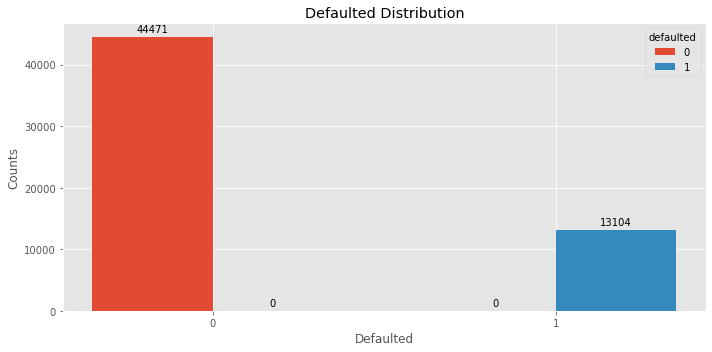

In [16]:
# plot the distribution
cat_plot('defaulted', train)

In [17]:
train[target_col].dtypes

defaulted    int64
dtype: object

Slight imbalance. Shold not be an issue though.

## Missingness

In [18]:
# number of missing values in the variables
train.isna().sum()

defaulted                                     0
loanid                                        0
username                                      0
loanapplicationstarteddate                    0
languagecode                                  0
age                                           0
gender                                        0
country                                       0
appliedamount                                 0
interest                                      0
loanduration                                  0
education                                     0
maritalstatus                                 0
nrofdependants                            39009
employmentstatus                             32
employmentdurationcurrentemployer           315
workexperience                            38493
occupationarea                                0
homeownershiptype                           117
incometotal                                   0
existingliabilities                     

In [19]:
miss_cols = train.columns[train.isna().sum() > 0]
train[miss_cols].describe(include='all')

nrofdependants  employmentstatus employmentdurationcurrentemployer  \
count           18566      57543.000000                             57260   
unique             18               NaN                                 9   
top                 0               NaN                    MoreThan5Years   
freq             8914               NaN                             22050   
mean              NaN          0.396990                               NaN   
std               NaN          2.038297                               NaN   
min               NaN         -1.000000                               NaN   
25%               NaN         -1.000000                               NaN   
50%               NaN         -1.000000                               NaN   
75%               NaN          3.000000                               NaN   
max               NaN          6.000000                               NaN   

       workexperience  homeownershiptype  previousearlyrepaymentsbeforeloan  
count           19082       57458.000000                       26773.000000  
unique              6                NaN                                NaN  
top        5To10Years                NaN                                NaN  
freq             4114                NaN                                NaN  
mean              NaN           3.549601                         202.636836  
std               NaN           2.842199                        1250.107246  
min               NaN          -1.000000                           0.000000  
25%               NaN           1.000000                           0.000000  
50%               NaN           3.000000                           0.000000  
75%               NaN           4.000000                           0.000000  
max               NaN          10.000000                       41755.000000

Missing values occur across a mixture of categorical and numerical variables

### Fill_na Function

In [204]:
# load database
db = pd.read_csv("../../Data/Processed/Database.csv")
db['loanapplicationstarteddate'] = pd.to_datetime(db['loanapplicationstarteddate'], format='%Y-%m-%d %H:%M:%S')
db['defaultdate'] = pd.to_datetime(db['defaultdate'], format='%Y-%m-%d')
db['loandate'] = pd.to_datetime(db['loandate'], format='%Y-%m-%d')

C:\Users\marti\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [21]:
# fill_na
train = fill_na(train, db)

In [22]:
# number of missing values in the variables
train.isna().sum()

defaulted                                     0
loanid                                        0
username                                      0
loanapplicationstarteddate                    0
languagecode                                  0
age                                           0
gender                                        0
country                                       0
appliedamount                                 0
interest                                      0
loanduration                                  0
education                                     0
maritalstatus                                 0
nrofdependants                            38344
employmentstatus                             28
employmentdurationcurrentemployer           291
workexperience                            37881
occupationarea                                0
homeownershiptype                           117
incometotal                                   0
existingliabilities                     

Some slight reduction in missing values.

## Negative 1 values

In [23]:
# check for -1 values
for col in train.columns:
    if col == 'loanapplicationstarteddate':
        continue
    if (train[col].values == -1).sum() == 0:
        continue
    print(f'{col} - {(train[col].values == -1).sum()}')
    

education - 2
maritalstatus - 38488
employmentstatus - 38488
occupationarea - 38519
homeownershiptype - 2


-1 values seem to occur only with categorical variables. To handle -1 values and other non-defined values, we can consider using data type casting as the first step to restrict acceptable values for the categorical variables, casting all non-defined values as NaN values, which can then be dealt with subsequently.

In [24]:
# convert all -1 values to np.nan
train = train.replace(-1, np.nan)

## Missing Value Treatment

### Education

The correlation between education and the TARGET is -0.0061
Median value for loan that is non-default = 4.0000
Median value for loan that defaulted =     4.0000


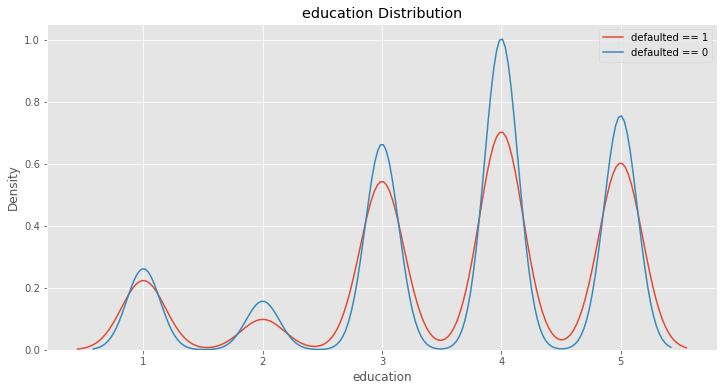

Cramer's V = 0.03499814097924325
Pearson Chi-squared
probability = 0.950, critical = 9.488, stat = 74.518
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


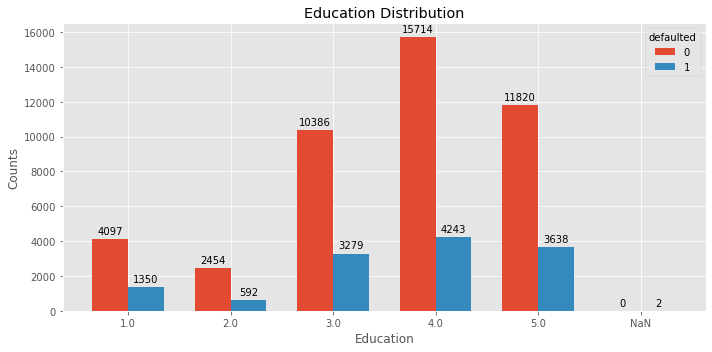

In [25]:
kde_target('education', train)
cat_plot('education', train)

In [26]:
train[train['education'].isna()]

defaulted                                loanid   username  \
index                                                               
21844          1  BB82FE36-30C5-4BFB-B91A-A7ED00F4D5FF  BOKK94231   
25170          1  0C0ED9DE-AC3F-4B4F-8DF3-A880013A1E38  BO627A5A7   

      loanapplicationstarteddate  languagecode  age  gender country  \
index                                                                 
21844        2017-09-13 14:51:00             6   57       0      ES   
25170        2018-02-07 19:04:00             1   68       0      EE   

       appliedamount  interest  loanduration  education  maritalstatus  \
index                                                                    
21844          530.0    146.36            36        NaN            NaN   
25170        10630.0     31.35            60        NaN            NaN   

      nrofdependants  employmentstatus employmentdurationcurrentemployer  \
index                                                                      
21844            NaN               NaN                    MoreThan5Years   
25170            NaN               NaN                    MoreThan5Years   

      workexperience  occupationarea  homeownershiptype  incometotal  \
index                                                                  
21844            NaN             NaN                NaN       1250.0   
25170            NaN             NaN                NaN        920.0   

       existingliabilities  liabilitiestotal  debttoincome  \
index                                                        
21844                    0               0.0           0.0   
25170                    0               0.0           0.0   

       noofearlierdefaults  noofpreviousloansbeforeloan  \
index                                                     
21844                    0                            0   
25170                    0                            0   

       amountofpreviousloansbeforeloan  priorrepayments  \
index                                                     
21844                              0.0              0.0   
25170                              0.0              0.0   

       previousearlyrepaymentsbeforeloan  \
index                                      
21844                                0.0   
25170                                0.0   

       previousearlyrepaymentscountbeforeloan  
index                                          
21844                                       0  
25170                                       0

In [27]:
# drop these 2 rows
train = train.drop(index=train[train['education'].isna()].index)

### Maritalstatus

The correlation between maritalstatus and the TARGET is 0.1013
Median value for loan that is non-default = 2.0000
Median value for loan that defaulted =     3.0000


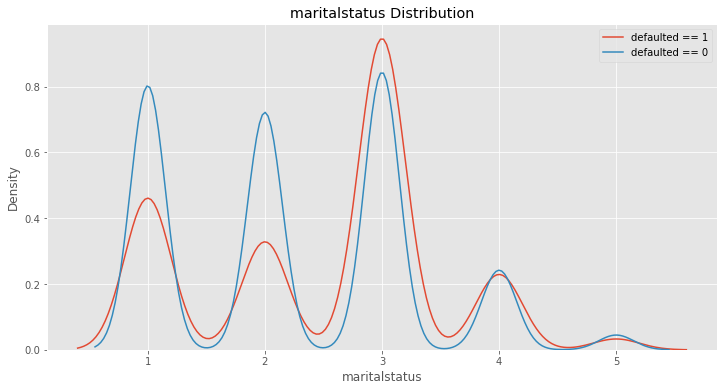

Cramer's V = 0.14324462884260383
Pearson Chi-squared
probability = 0.950, critical = 9.488, stat = 395.626
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


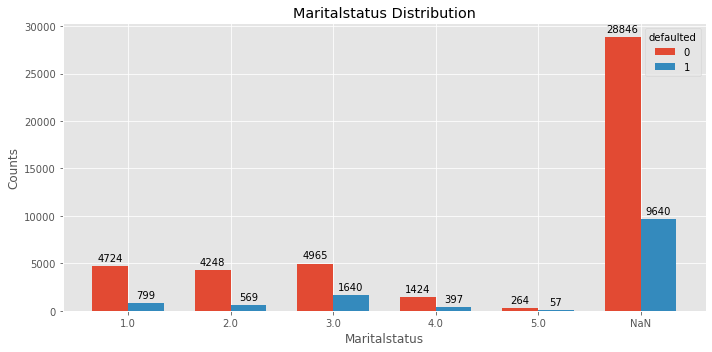

In [28]:
kde_target('maritalstatus', train)
cat_plot('maritalstatus', train)

Since there is a large amount of missing data, we may treat the missing values as a separate class.

In [29]:
train['maritalstatus'] = train['maritalstatus'].fillna(-1)

The correlation between maritalstatus and the TARGET is -0.0531
Median value for loan that is non-default = -1.0000
Median value for loan that defaulted =     -1.0000


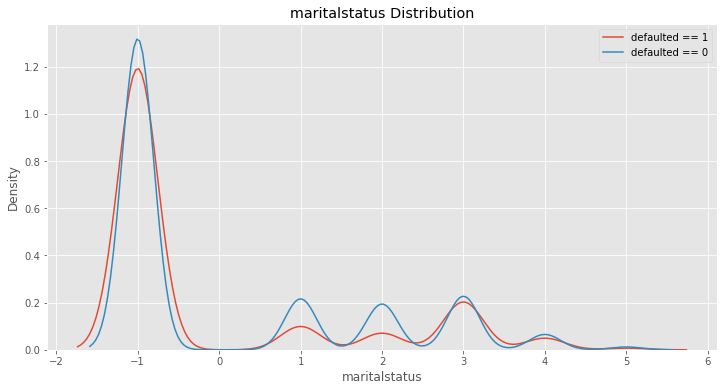

Cramer's V = 0.10834080479319722
Pearson Chi-squared
probability = 0.950, critical = 11.070, stat = 680.765
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


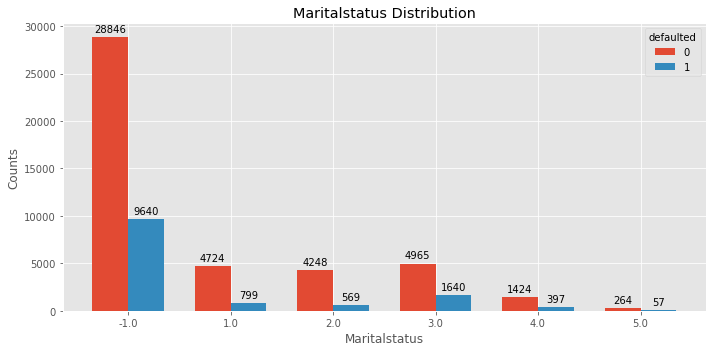

In [30]:
# lets check the effect of this imputation
kde_target('maritalstatus', train)
cat_plot('maritalstatus', train)

We see a significant drop in the cramer's V and pearson's correlation coefficient with the target variable. The drop in pearson's coefficient is understandable given that the calulation assumes a numerical significance to the values assigned to the various classes witin the categorical variable which is untrue in this case. Cramer's V statistics would be more appropriate in this case and it shows that there is indeed a drop in the correlation with the target variable. 

### Nrofdependants

In [31]:
# data type
train['nrofdependants'] = train['nrofdependants'].astype(object)

Cramer's V = 0.13434642810663702
Pearson Chi-squared
probability = 0.950, critical = 27.587, stat = 352.080
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


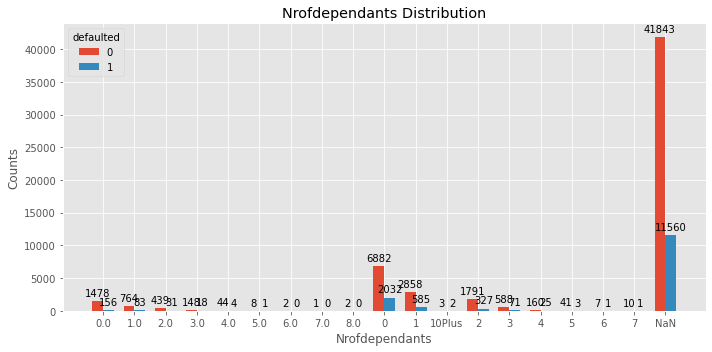

In [32]:
# kde_target('nrofdependants', df)
cat_plot('nrofdependants', df)

Due to mix data type, there is a mixture of float and int values which are not consolidated. This must be addressed during the initial data type casting step.

In [33]:
train.loc[~train['nrofdependants'].isna(), 'nrofdependants'] = train['nrofdependants'].astype(str)

In [34]:
train.loc[(train['nrofdependants'].str.contains('\.0', regex=True)) & (~train['nrofdependants'].isna()), 'nrofdependants'] = train.loc[(train['nrofdependants'].str.contains('\.0', regex=True)) & (~train['nrofdependants'].isna()), 'nrofdependants'].str.replace('.0', '')

Cramer's V = 0.08098793015204564
Pearson Chi-squared
probability = 0.950, critical = 16.919, stat = 135.131
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


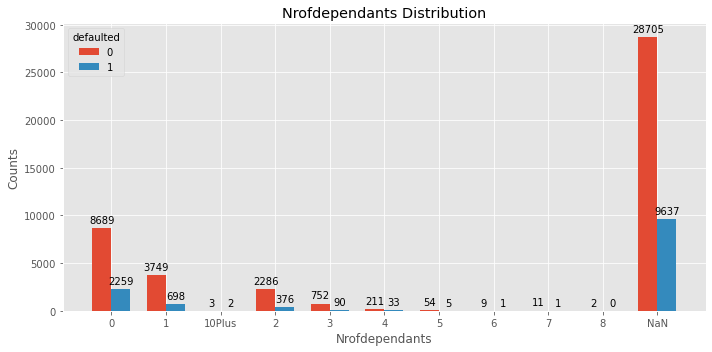

In [35]:
cat_plot('nrofdependants', train)

In [36]:
# large number of missing values, lets fillna with -1
train['nrofdependants'] = train['nrofdependants'].fillna(-1)

Cramer's V = 0.09059751843841232
Pearson Chi-squared
probability = 0.950, critical = 18.307, stat = 482.546
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


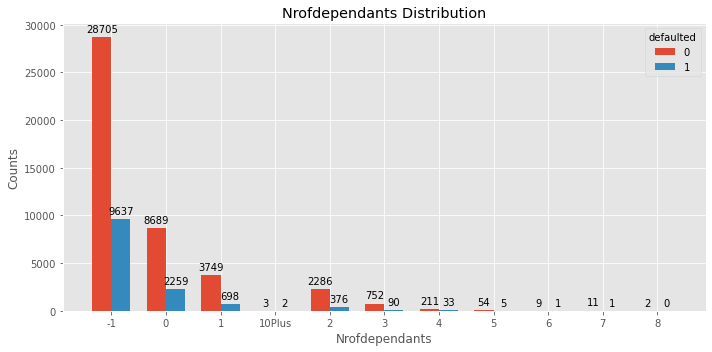

In [37]:
cat_plot('nrofdependants', train)

We see that imputing the missing values with -1 improves the correlation with the target variable in this case.

### Employmentstatus

The correlation between employmentstatus and the TARGET is 0.0272
Median value for loan that is non-default = 3.0000
Median value for loan that defaulted =     3.0000


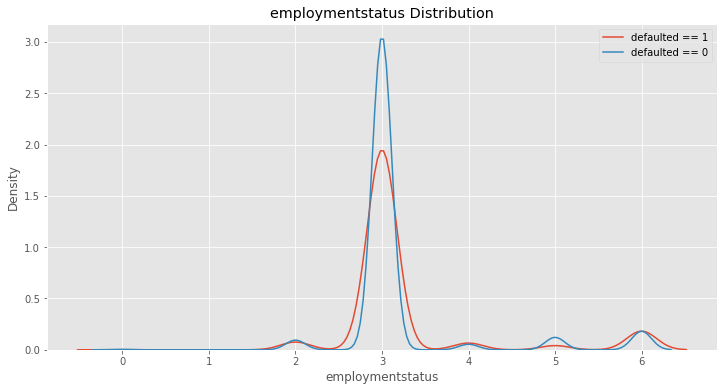

Cramer's V = 0.06938421883121508
Pearson Chi-squared
probability = 0.950, critical = 11.070, stat = 96.749
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


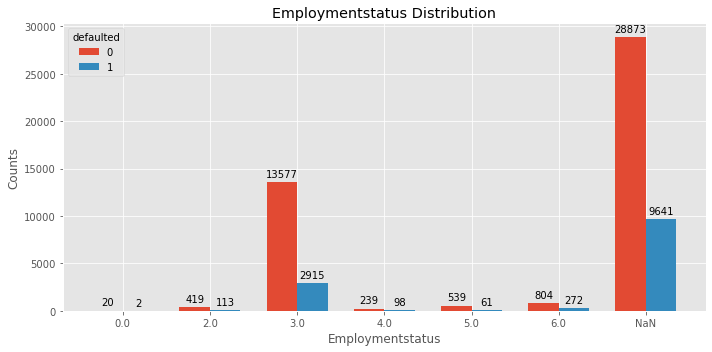

In [38]:
kde_target('employmentstatus', train)
cat_plot('employmentstatus', train)

Again, lets create a separate class for the missing values.

In [39]:
# impute with -1 value
train['employmentstatus'] = train['employmentstatus'].fillna(-1)

Cramer's V = 0.08525173711253442
Pearson Chi-squared
probability = 0.950, critical = 12.592, stat = 424.425
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


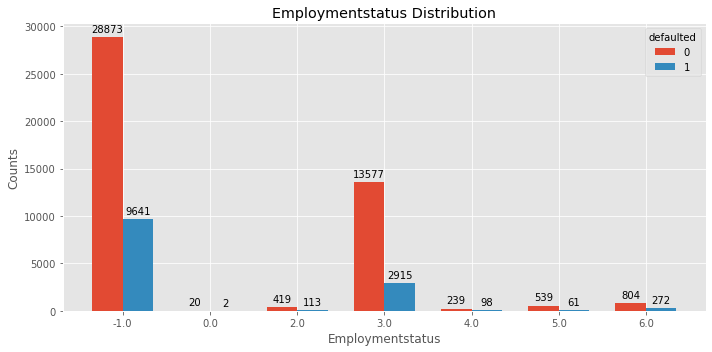

In [40]:
cat_plot('employmentstatus', train)

We see that imputing the missing values with a separate class improves the correlation with the target variable in this case

### Employmentdurationcurrentemployer

Cramer's V = 0.04120529546138497
Pearson Chi-squared
probability = 0.950, critical = 15.507, stat = 105.256
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


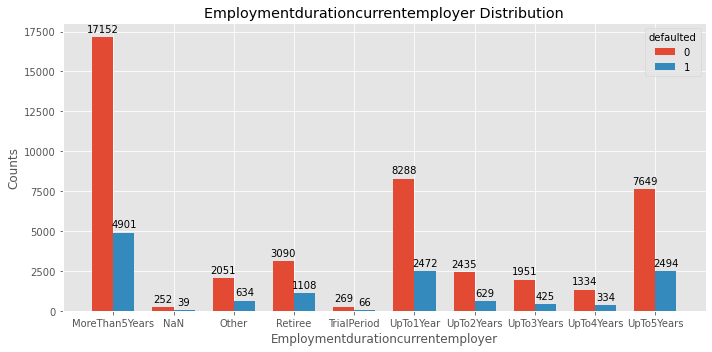

In [41]:
cat_plot('employmentdurationcurrentemployer', train)

In this case, the missing values are very low in occurence. For such a case, we will use a simle imputation strategy where we impute with the mode/most frequent class.

In [42]:
# we can do this via Sklearn's Simpleimputer.
Imputer = SimpleImputer(strategy='most_frequent')

In [43]:
train['employmentdurationcurrentemployer'] = Imputer.fit_transform(train[['employmentdurationcurrentemployer']])

Cramer's V = 0.04152180280885828
Pearson Chi-squared
probability = 0.950, critical = 15.507, stat = 107.258
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


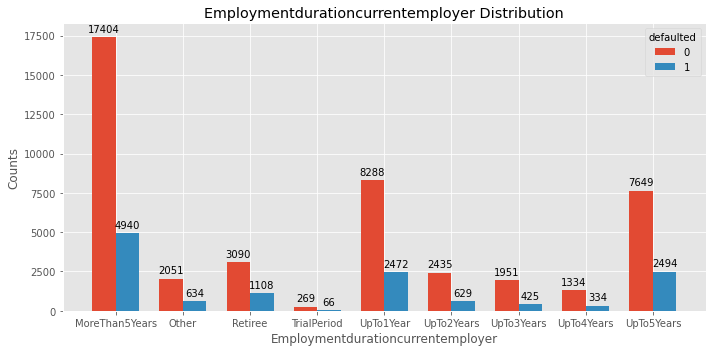

In [44]:
cat_plot('employmentdurationcurrentemployer', train)

A slight improvement in the correlation.

### Workexperience

Cramer's V = 0.04375325737270125
Pearson Chi-squared
probability = 0.950, critical = 11.070, stat = 42.699
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


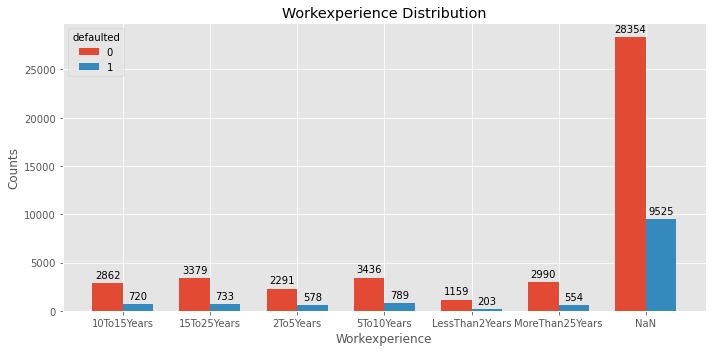

In [45]:
cat_plot('workexperience', train)

As with other variables with large missing values, we will impute them with a separate class.

In [46]:
train['workexperience'] = train['workexperience'].fillna('unspecified')

Cramer's V = 0.08225632566036309
Pearson Chi-squared
probability = 0.950, critical = 12.592, stat = 395.538
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


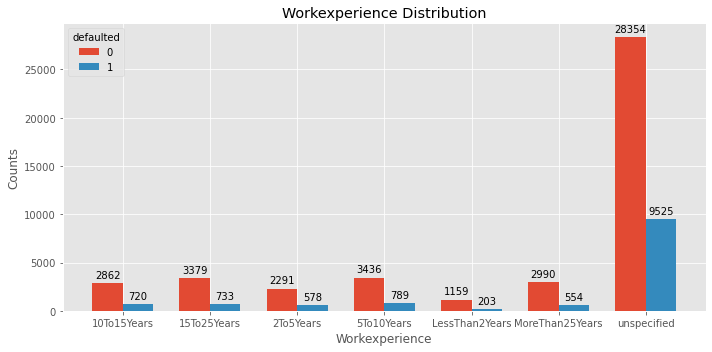

In [47]:
cat_plot('workexperience', train)

The correlation improves significantly.

### Occupationarea

Cramer's V = 0.10607188351940083
Pearson Chi-squared
probability = 0.950, critical = 28.869, stat = 232.393
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


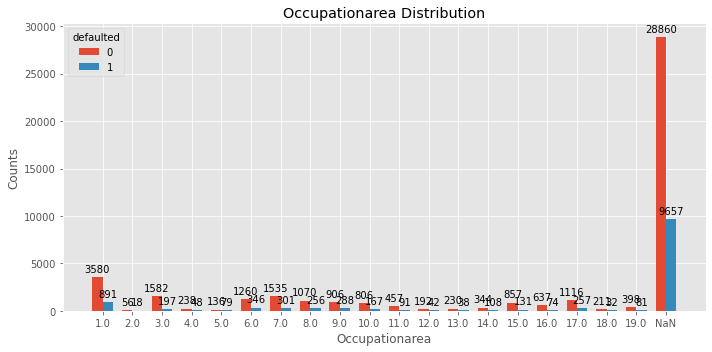

In [48]:
cat_plot('occupationarea', train)

Impute with separate class due to large amount of missing values.

In [49]:
train['occupationarea'] = train['occupationarea'].fillna(-1)

Cramer's V = 0.0960859858593822
Pearson Chi-squared
probability = 0.950, critical = 30.144, stat = 550.535
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


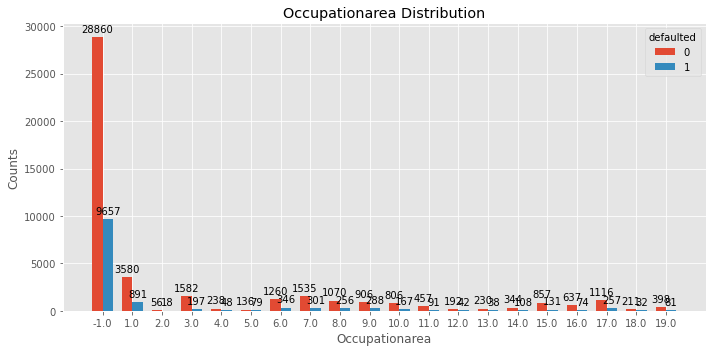

In [50]:
cat_plot('occupationarea', train)

We see that imputation with a separate class reduces the correlation slightly.

### Homeownershiptype

Cramer's V = 0.11662618640332968
Pearson Chi-squared
probability = 0.950, critical = 18.307, stat = 791.484
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


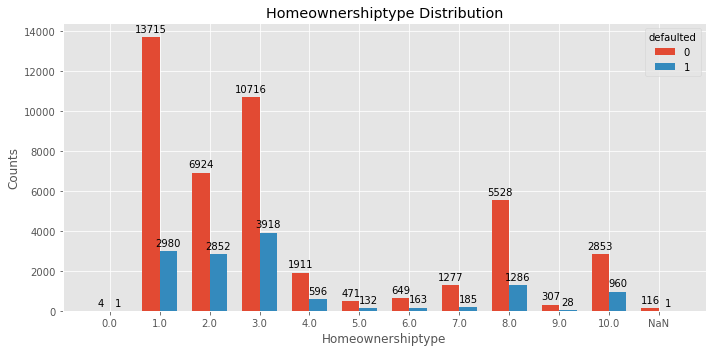

In [51]:
cat_plot('homeownershiptype', train)

The small amount of missing values (~0.2%) means that we can adopt a simple imputation strategy using the mode/most frequent class.

In [52]:
Imputer = SimpleImputer(strategy='most_frequent')

In [53]:
train['homeownershiptype'] = Imputer.fit_transform(train[['homeownershiptype']])

Cramer's V = 0.1175464109713882
Pearson Chi-squared
probability = 0.950, critical = 18.307, stat = 805.482
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


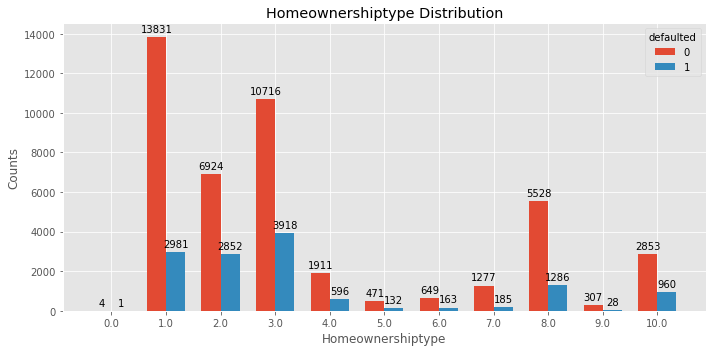

In [54]:
cat_plot('homeownershiptype', train)

Slight improvement in the correlation

### Previousearlyrepaymentsbeforeloan

The correlation between previousearlyrepaymentsbeforeloan and the TARGET is -0.0246
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


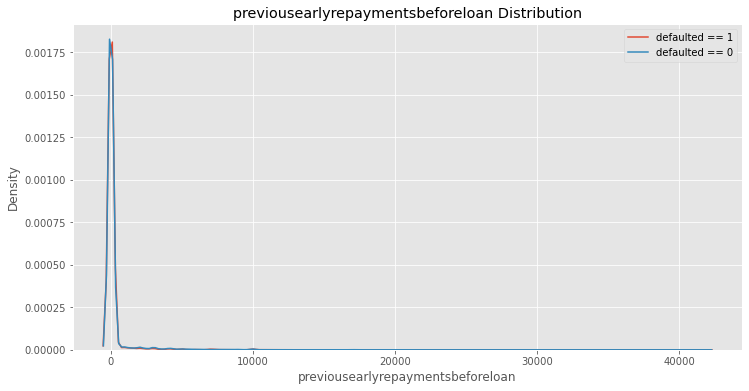

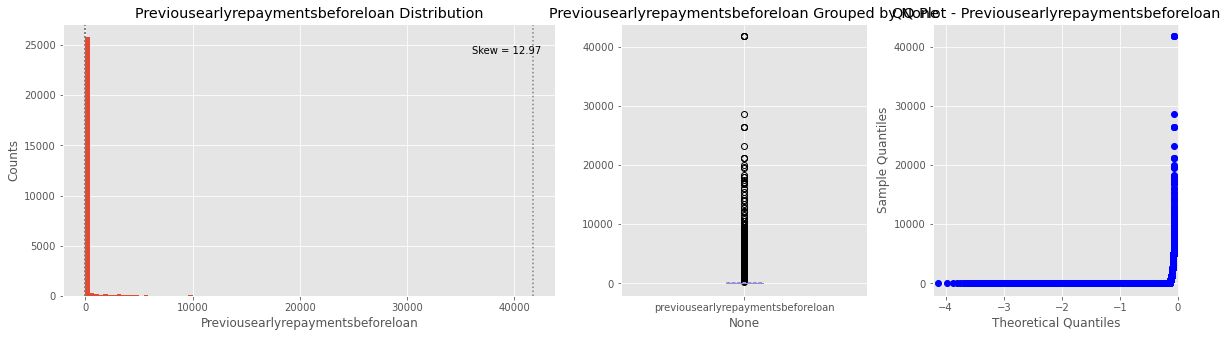

In [55]:
kde_target('previousearlyrepaymentsbeforeloan', train)
numerical_plot('previousearlyrepaymentsbeforeloan', train)

As previousearlyrepaymentsbeforeloan is closely related with previousearlyrepaymentscountbeforeloan, lets explore the relationship when previousearlyrepaymentsbeforeloan is NaN.

In [56]:
train.loc[train['previousearlyrepaymentsbeforeloan'].isna(), 'previousearlyrepaymentscountbeforeloan'].value_counts(dropna=False)

0    30165
1       40
2       14
3        1
Name: previousearlyrepaymentscountbeforeloan, dtype: int64

Seems like a large proportion of missing previousearlyrepaymentsbeforeloan corresponds to when previousearlyrepaymentscountbeforeloan is zero, which is logical. For these, it thus makes sense to impute the missing previousearlyrepaymentsbeforeloan as zero.

In [57]:
train.loc[(train['previousearlyrepaymentsbeforeloan'].isna() & (train['previousearlyrepaymentscountbeforeloan']==0)), 'previousearlyrepaymentsbeforeloan'] = 0

The correlation between previousearlyrepaymentsbeforeloan and the TARGET is -0.0158
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


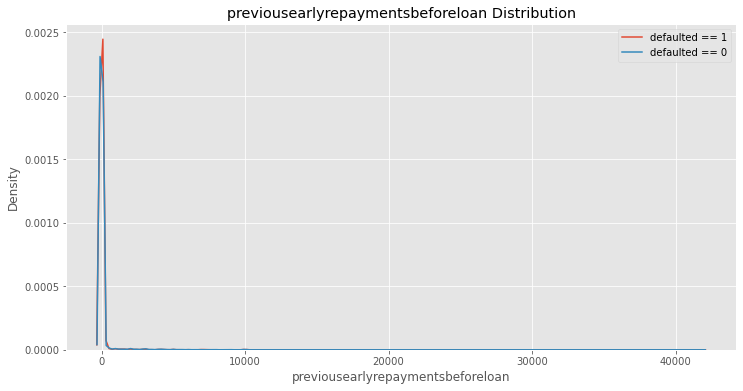

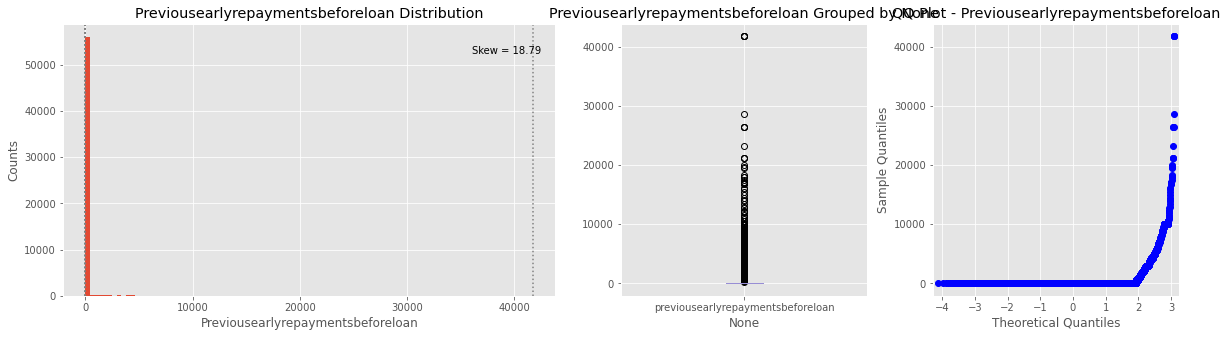

In [58]:
kde_target('previousearlyrepaymentsbeforeloan', train)
numerical_plot('previousearlyrepaymentsbeforeloan', train)

In [59]:
# remaining missing values
train.loc[train['previousearlyrepaymentsbeforeloan'].isna(), 'previousearlyrepaymentscountbeforeloan'].value_counts(dropna=False)

1    40
2    14
3     1
Name: previousearlyrepaymentscountbeforeloan, dtype: int64

In [60]:
Imp = GroupImputer(group_cols=['previousearlyrepaymentscountbeforeloan'],
                   target='previousearlyrepaymentsbeforeloan',
                   metric='median')

In [61]:
train = pd.DataFrame(Imp.fit_transform(train), index=train.index, columns=train.columns).astype(train.dtypes)

The correlation between previousearlyrepaymentsbeforeloan and the TARGET is -0.0162
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


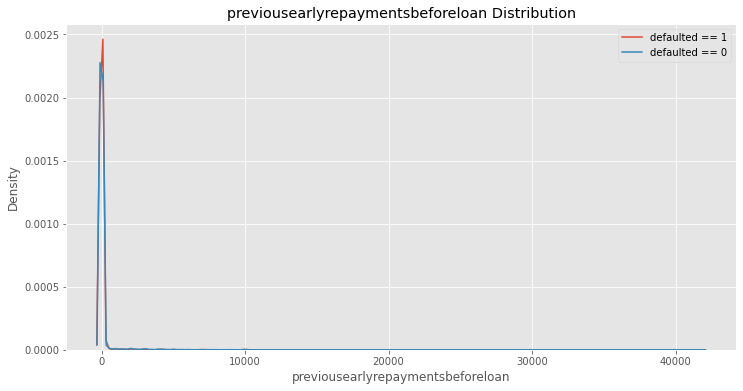

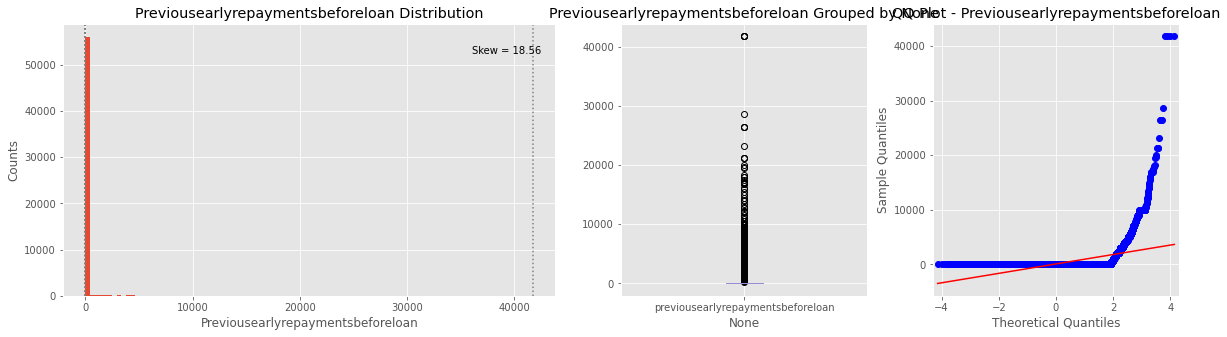

In [62]:
kde_target('previousearlyrepaymentsbeforeloan', train)
numerical_plot('previousearlyrepaymentsbeforeloan', train)

In [63]:
train.isna().sum()

defaulted                                 0
loanid                                    0
username                                  0
loanapplicationstarteddate                0
languagecode                              0
age                                       0
gender                                    0
country                                   0
appliedamount                             0
interest                                  0
loanduration                              0
education                                 0
maritalstatus                             0
nrofdependants                            0
employmentstatus                          0
employmentdurationcurrentemployer         0
workexperience                            0
occupationarea                            0
homeownershiptype                         0
incometotal                               0
existingliabilities                       0
liabilitiestotal                          0
debttoincome                    

# Feature Engineering

## Num_cols

### Appliedamount

The correlation between appliedamount and the TARGET is -0.0435
Median value for loan that is non-default = 2126.0000
Median value for loan that defaulted =     2125.0000


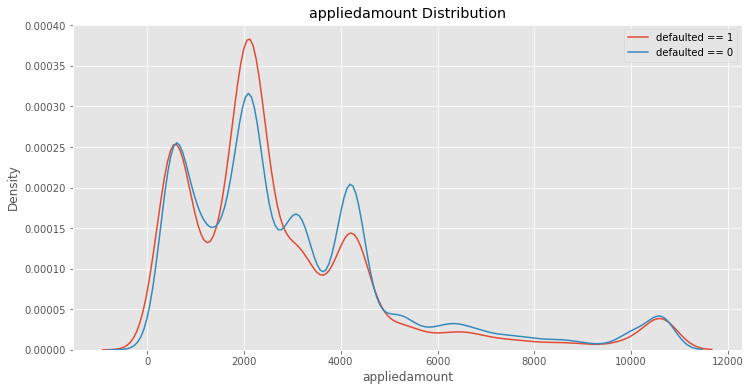

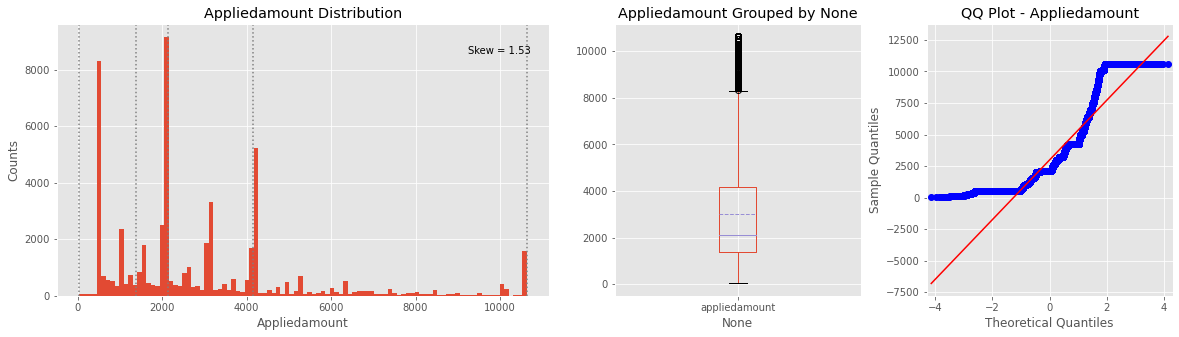

In [64]:
kde_target('appliedamount', train)
numerical_plot('appliedamount', train)

In [65]:
# Test transformation to reduce skew and to normalise
yeo = PowerTransformer(method='yeo-johnson')
quantile = QuantileTransformer(output_distribution='uniform', random_state=0)
log = FunctionTransformer(np.log1p, validate=True)

In [66]:
train['appliedamount_quantile'] = quantile.fit_transform(train[['appliedamount']])
train['appliedamount_log'] = log.fit_transform(train[['appliedamount']])
train['appliedamount_yeo'] = yeo.fit_transform(train[['appliedamount']])

The correlation between appliedamount_quantile and the TARGET is -0.0494
Median value for loan that is non-default = 0.5005
Median value for loan that defaulted =     0.4239


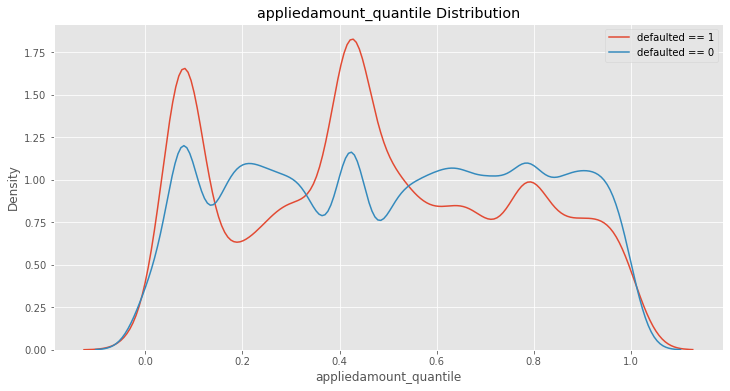

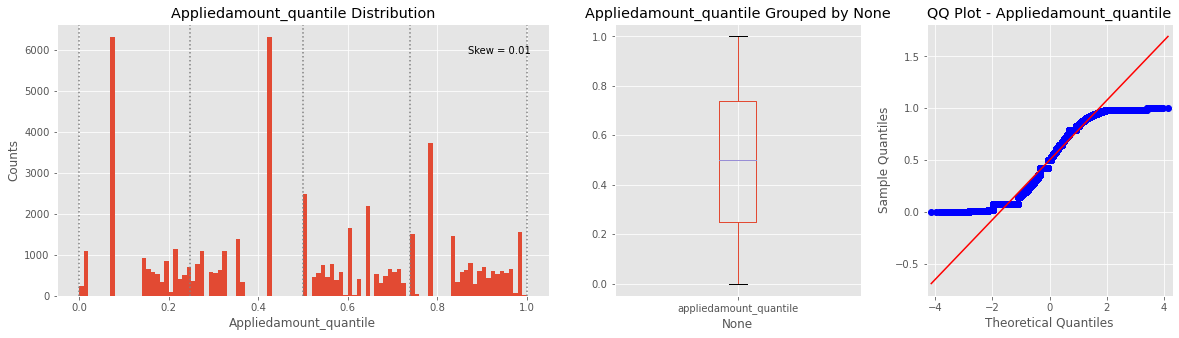

The correlation between appliedamount_log and the TARGET is -0.0451
Median value for loan that is non-default = 7.6625
Median value for loan that defaulted =     7.6620


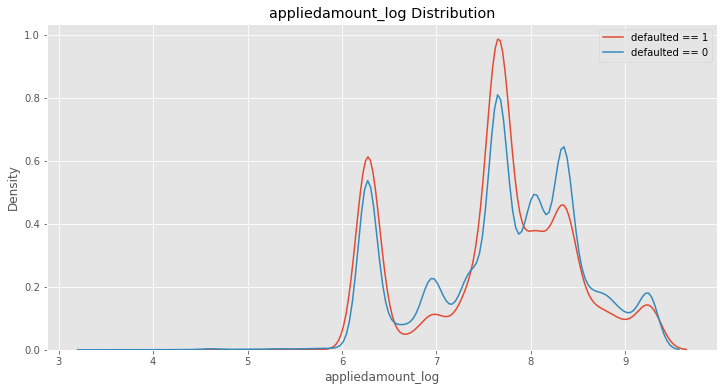

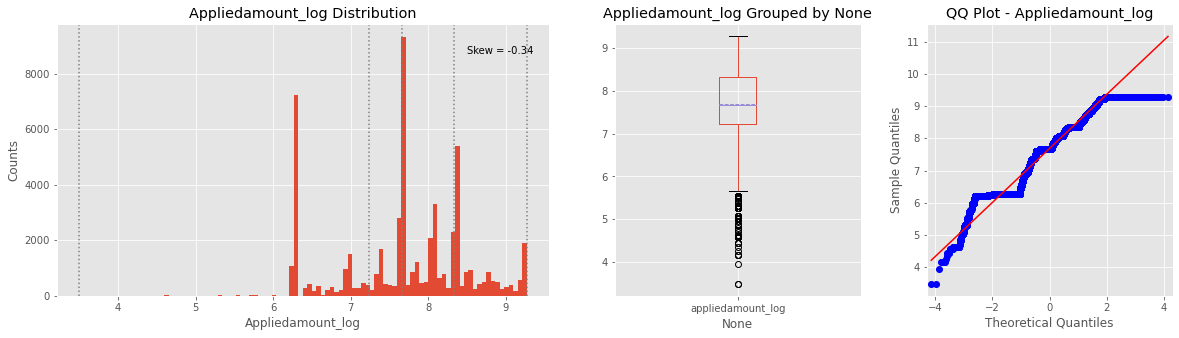

The correlation between appliedamount_yeo and the TARGET is -0.0461
Median value for loan that is non-default = -0.1057
Median value for loan that defaulted =     -0.1063


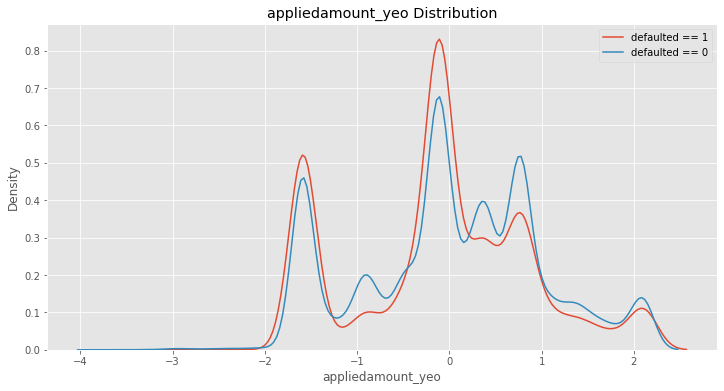

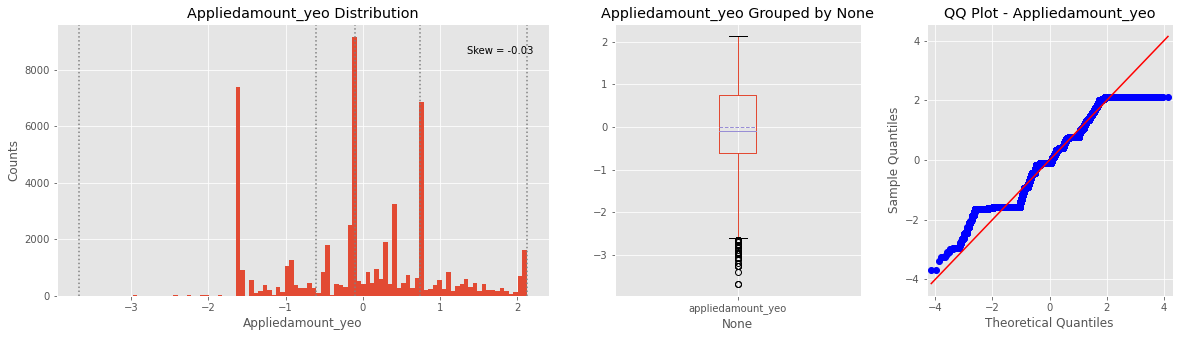

In [67]:
ls = ['appliedamount_quantile','appliedamount_log', 'appliedamount_yeo']
for l in ls:
    kde_target(l, train)
    numerical_plot(l, train)

Quantile transformation seems to improve the correlation and also reduce the skewness the most

2
The correlation between test and the TARGET is -0.0597
Median value for loan that is non-default = 1.0000
Median value for loan that defaulted =     0.0000


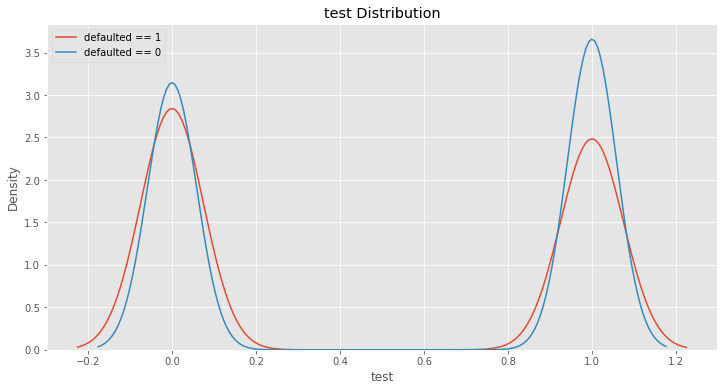

Cramer's V = 0.05950021277908788
Pearson Chi-squared
probability = 0.950, critical = 3.841, stat = 204.821
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


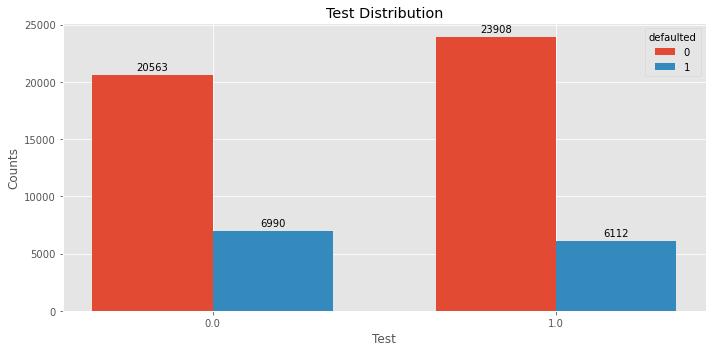

3
The correlation between test and the TARGET is -0.0305
Median value for loan that is non-default = 1.0000
Median value for loan that defaulted =     1.0000


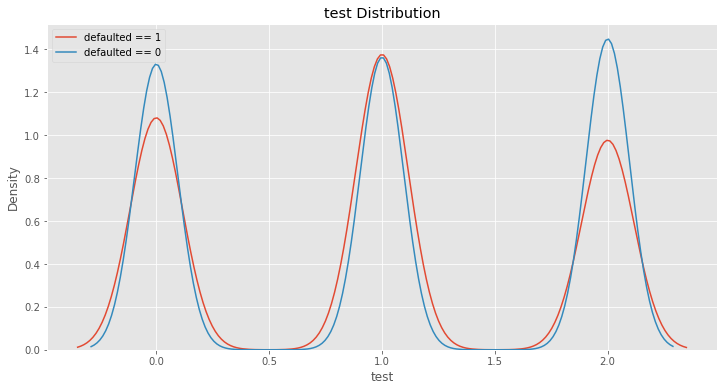

Cramer's V = 0.06960842882820455
Pearson Chi-squared
probability = 0.950, critical = 5.991, stat = 280.956
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


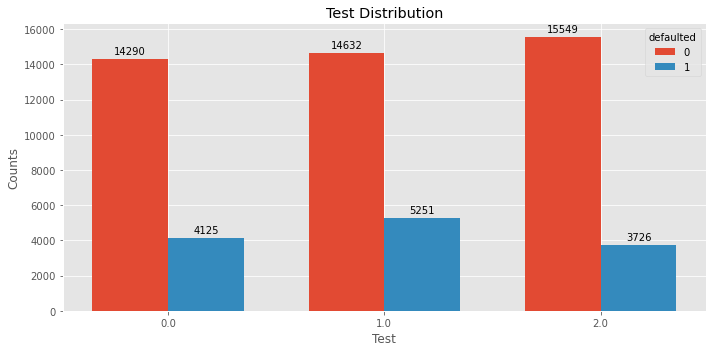

4
The correlation between test and the TARGET is -0.0467
Median value for loan that is non-default = 2.0000
Median value for loan that defaulted =     1.0000


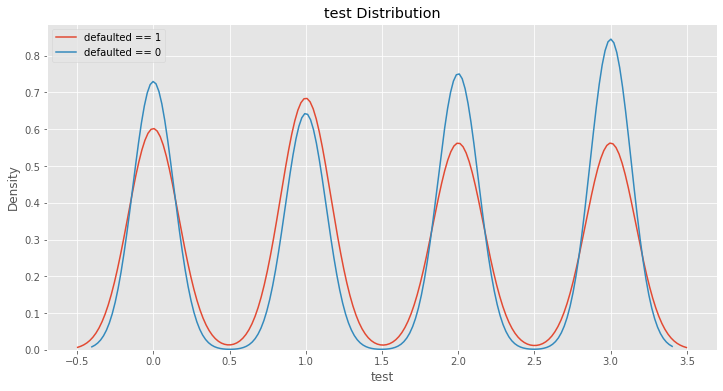

Cramer's V = 0.0732270407251839
Pearson Chi-squared
probability = 0.950, critical = 7.815, stat = 311.713
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


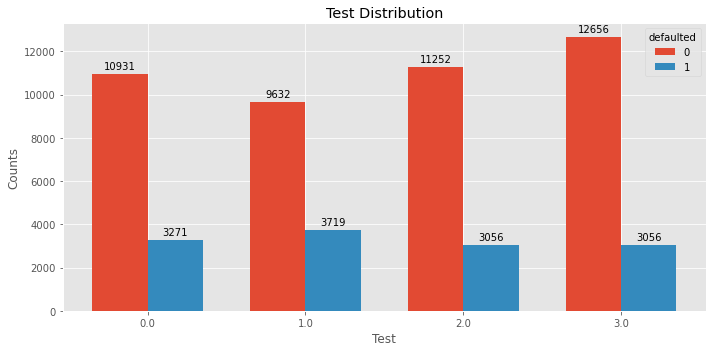

5
The correlation between test and the TARGET is -0.0412
Median value for loan that is non-default = 2.0000
Median value for loan that defaulted =     2.0000


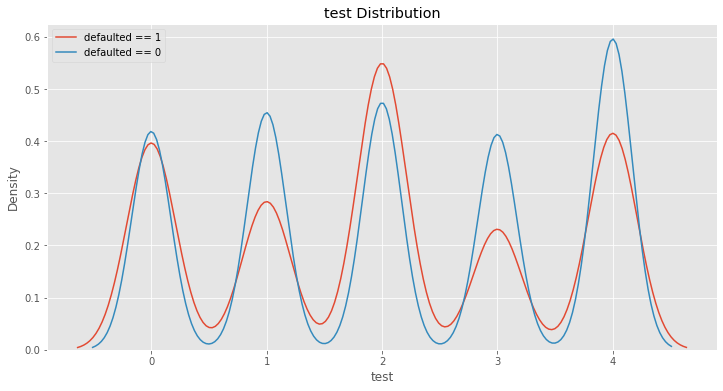

Cramer's V = 0.1138036497955561
Pearson Chi-squared
probability = 0.950, critical = 9.488, stat = 749.631
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


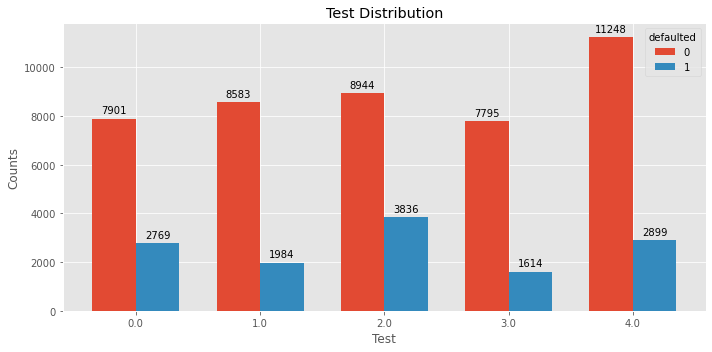

6
The correlation between test and the TARGET is -0.0538
Median value for loan that is non-default = 3.0000
Median value for loan that defaulted =     2.0000


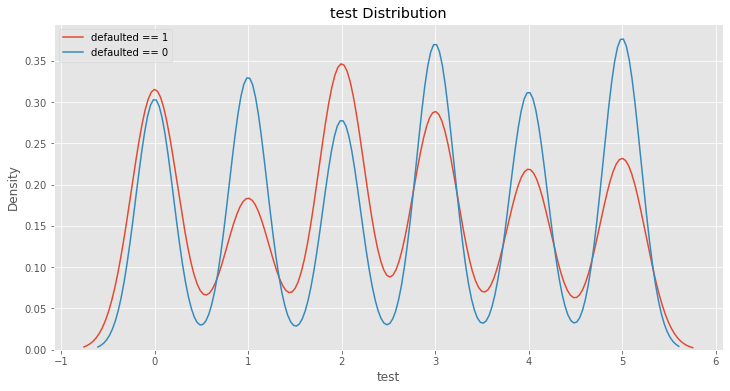

Cramer's V = 0.11932006257836074
Pearson Chi-squared
probability = 0.950, critical = 11.070, stat = 824.669
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


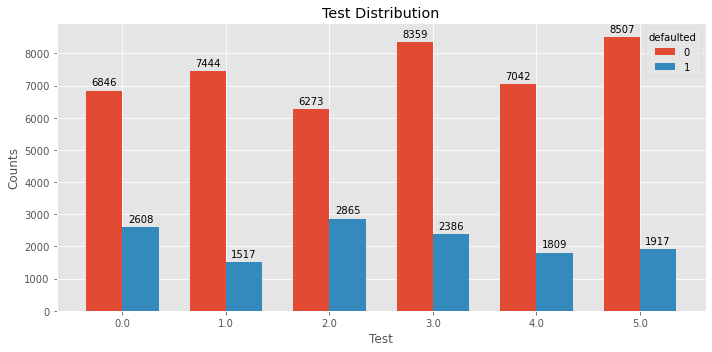

7
The correlation between test and the TARGET is -0.0467
Median value for loan that is non-default = 3.0000
Median value for loan that defaulted =     3.0000


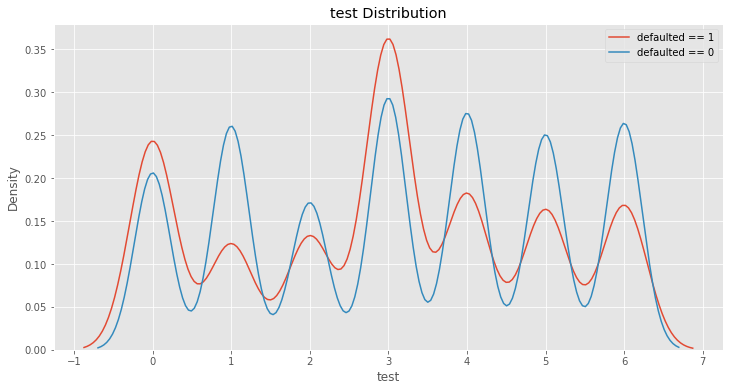

Cramer's V = 0.14194037727374148
Pearson Chi-squared
probability = 0.950, critical = 12.592, stat = 1165.907
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


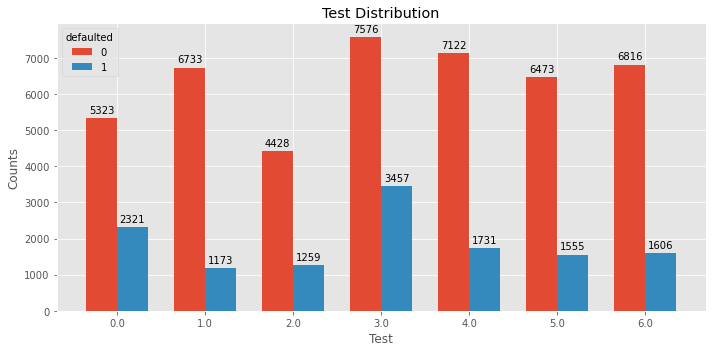

8
The correlation between test and the TARGET is -0.0392
Median value for loan that is non-default = 4.0000
Median value for loan that defaulted =     3.0000


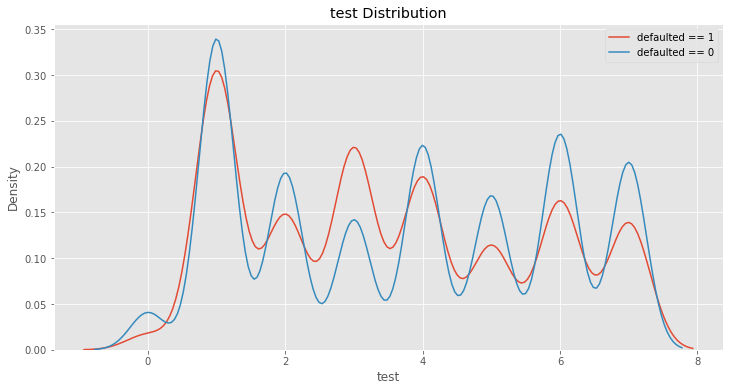

Cramer's V = 0.11880974200099045
Pearson Chi-squared
probability = 0.950, critical = 14.067, stat = 819.672
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


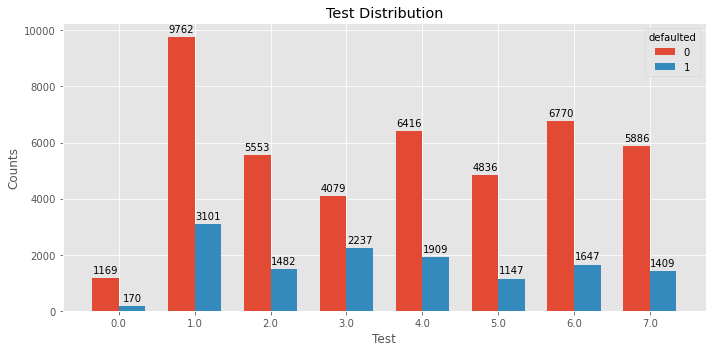

9
The correlation between test and the TARGET is -0.0332
Median value for loan that is non-default = 4.0000
Median value for loan that defaulted =     4.0000


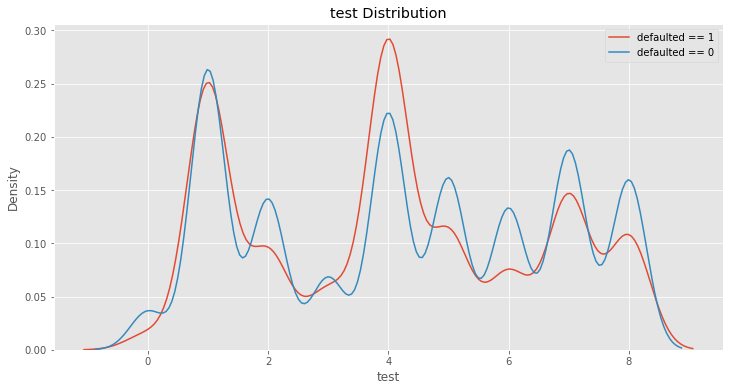

Cramer's V = 0.12347043981745319
Pearson Chi-squared
probability = 0.950, critical = 15.507, stat = 885.682
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


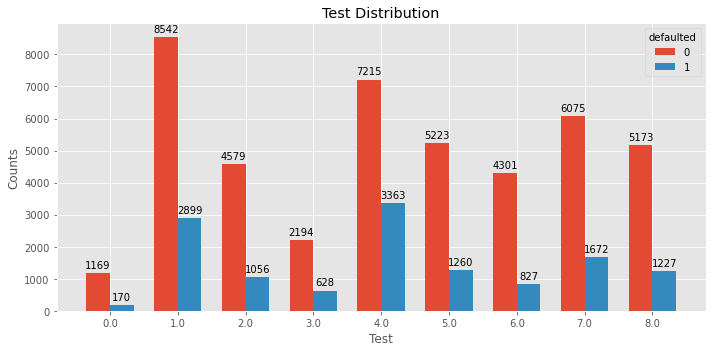

10
The correlation between test and the TARGET is -0.0417
Median value for loan that is non-default = 5.0000
Median value for loan that defaulted =     4.0000


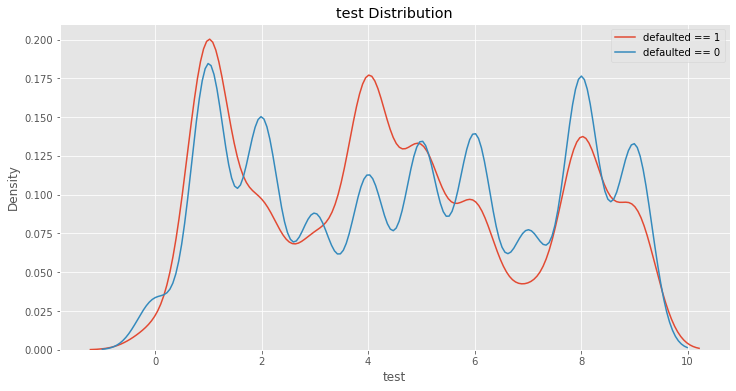

Cramer's V = 0.14236334163862724
Pearson Chi-squared
probability = 0.950, critical = 16.919, stat = 1175.830
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


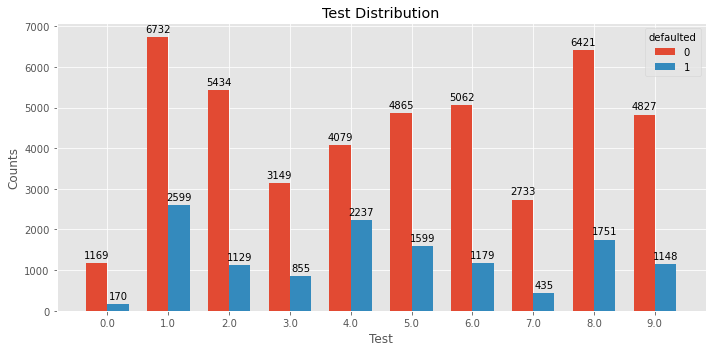

In [68]:
# test for uniform binning transformation
for i in range(2, 11):
    print(i)
    binner = KBinsDiscretizer(n_bins=i, encode='ordinal')
    train['test'] = binner.fit_transform(train[['appliedamount']])
    kde_target('test', train)
    cat_plot('test', train)

In [69]:
# 10 seems to be the best
binner = KBinsDiscretizer(n_bins=10, encode='ordinal')

dft = pd.DataFrame(
    binner.fit_transform(train[['appliedamount']]),
    index=train.index,
    columns= ['appliedamount_binned']
    
)

train = pd.merge(train, dft, how='left', left_index=True, right_index=True)

In [70]:
binner.bin_edges_

array([array([   31.9558,   530.    ,  1000.    ,  1700.    ,  2125.    ,
        2126.    ,  3000.    ,  3700.    ,  4250.    ,  6000.    ,
       10632.    ])], dtype=object)

In [71]:
train.columns

Index(['defaulted', 'loanid', 'username', 'loanapplicationstarteddate',
       'languagecode', 'age', 'gender', 'country', 'appliedamount', 'interest',
       'loanduration', 'education', 'maritalstatus', 'nrofdependants',
       'employmentstatus', 'employmentdurationcurrentemployer',
       'workexperience', 'occupationarea', 'homeownershiptype', 'incometotal',
       'existingliabilities', 'liabilitiestotal', 'debttoincome',
       'noofearlierdefaults', 'noofpreviousloansbeforeloan',
       'amountofpreviousloansbeforeloan', 'priorrepayments',
       'previousearlyrepaymentsbeforeloan',
       'previousearlyrepaymentscountbeforeloan', 'appliedamount_quantile',
       'appliedamount_log', 'appliedamount_yeo', 'test',
       'appliedamount_binned'],
      dtype='object')

### Interest

The correlation between interest and the TARGET is 0.3153
Median value for loan that is non-default = 32.8800
Median value for loan that defaulted =     56.3950


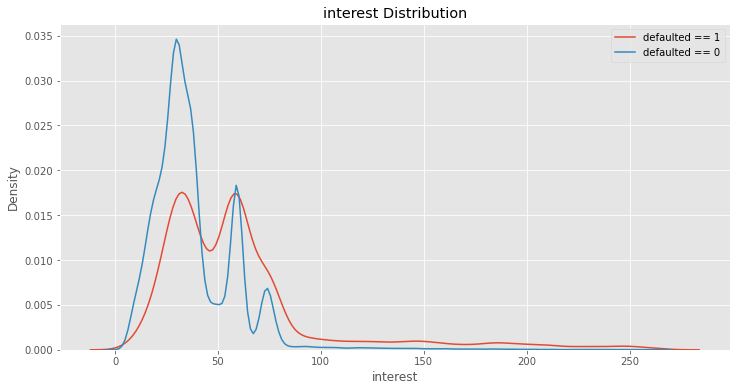

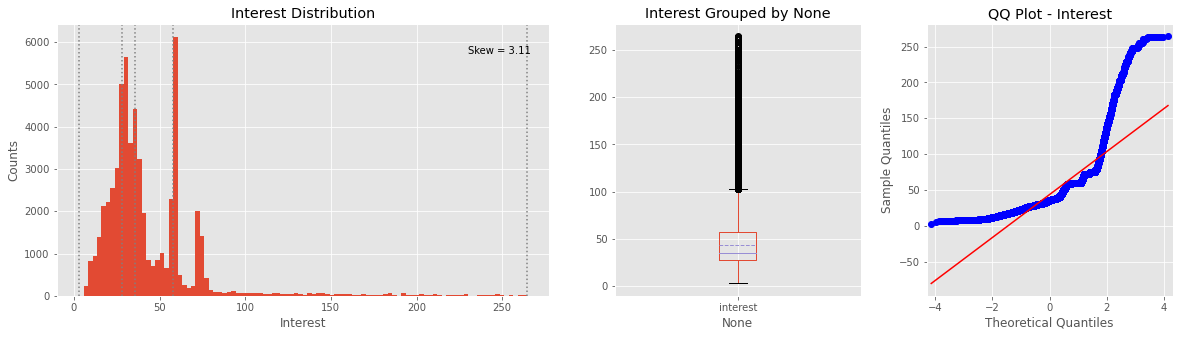

In [72]:
kde_target('interest', train)
numerical_plot('interest', train)

In [73]:
def power_trans(var, df, output_distribution='uniform'):
    
    yeo = PowerTransformer(method='yeo-johnson')
    quantile = QuantileTransformer(output_distribution=output_distribution, random_state=0)
    log = FunctionTransformer(np.log1p, validate=True)
        
    df = df.copy()
    df[str(var)+'_log'] = log.fit_transform(df[[var]])
    df[str(var)+'_quantile'] = quantile.fit_transform(df[[var]])
    df[str(var)+'_yeo'] = yeo.fit_transform(df[[var]])
    
    return df  
    

In [74]:
train = power_trans('interest', train)

The correlation between interest_log and the TARGET is 0.3130
Median value for loan that is non-default = 3.5228
Median value for loan that defaulted =     4.0500


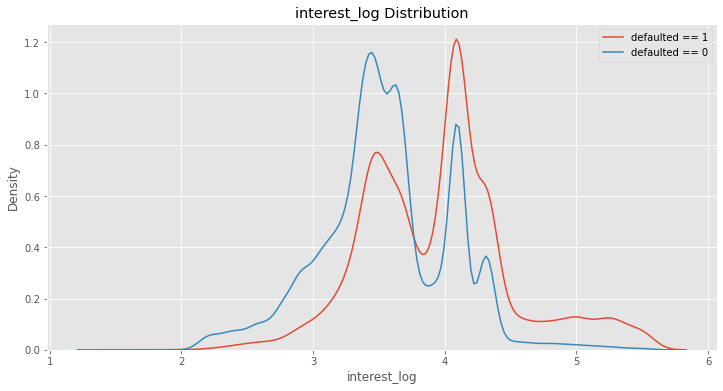

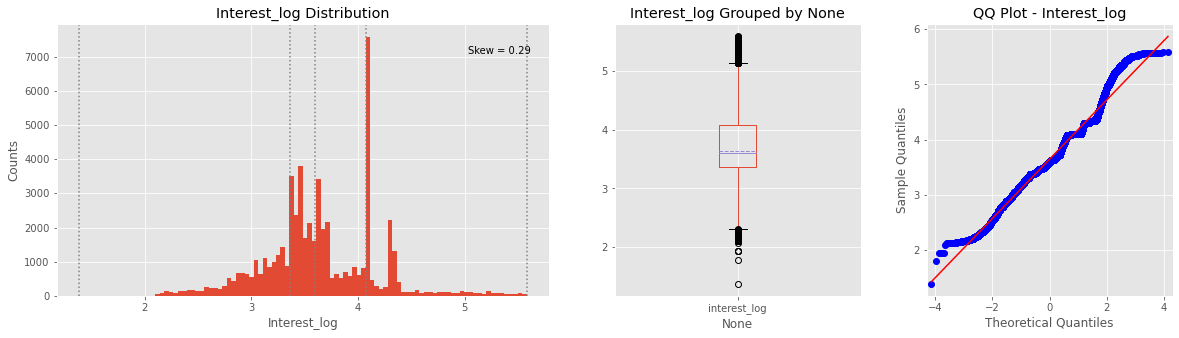

The correlation between interest_yeo and the TARGET is 0.3069
Median value for loan that is non-default = -0.1901
Median value for loan that defaulted =     0.7761


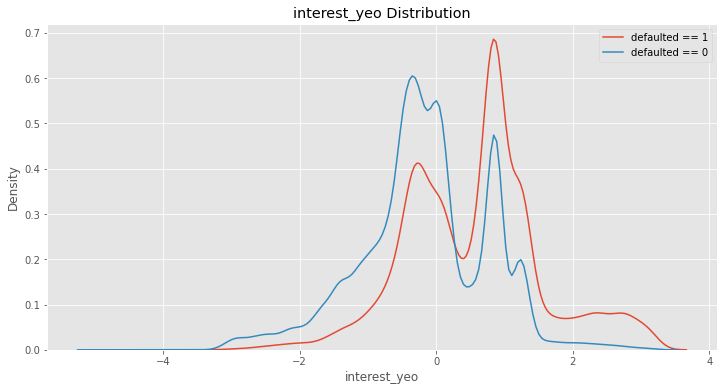

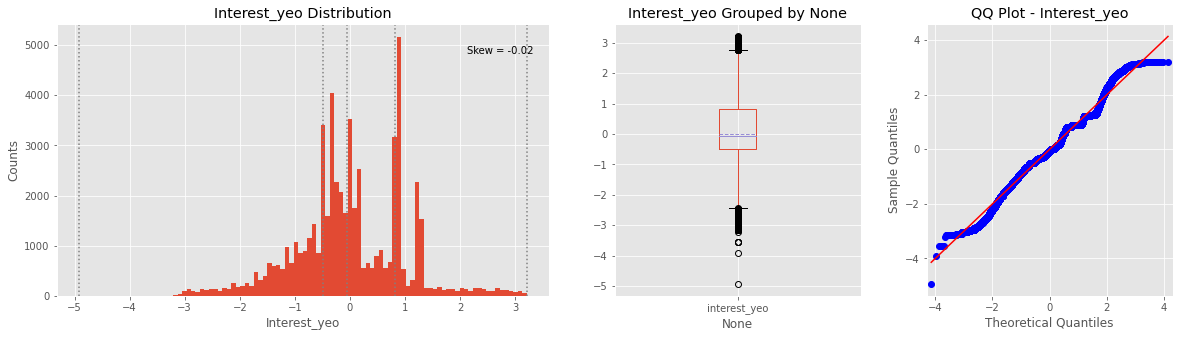

The correlation between interest_quantile and the TARGET is 0.2929
Median value for loan that is non-default = 0.4435
Median value for loan that defaulted =     0.7216


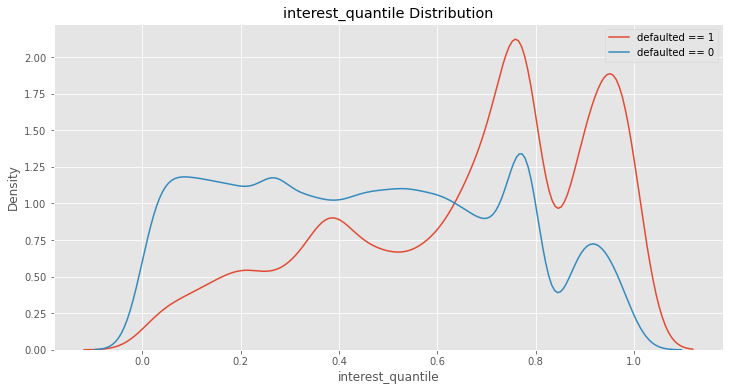

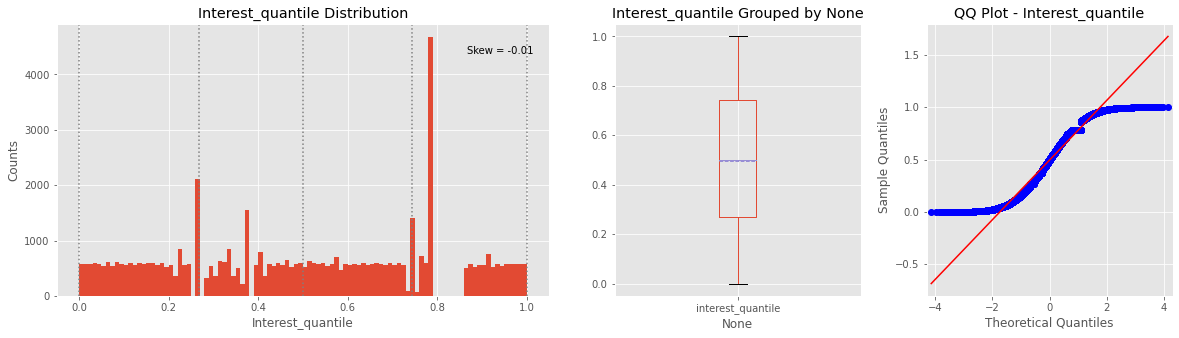

In [75]:
ls = ['interest_log', 'interest_yeo', 'interest_quantile']
for l in ls:
    kde_target(l, train)
    numerical_plot(l, train)

In [76]:
def check_bin(var, df, min_bins=2, max_bins=10):
    
    df = df.copy()
    
    for i in range(min_bins, max_bins+1):
        
        binner = KBinsDiscretizer(n_bins=i, encode='ordinal')
        df['test'] = binner.fit_transform(df[[var]])
        table = pd.crosstab(df['test'], df["defaulted"]).to_numpy()
        
        print(str(i) + 'bin')
        corr = df['defaulted'].corr(df['test'])
        print(corr)
        
        cramers_v(table)
        chi_square(table)

In [77]:
check_bin('interest', train)

2bin
0.22629596676879649
Cramer's V = 0.22621811530396976
Pearson Chi-squared
probability = 0.950, critical = 3.841, stat = 2947.226
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)
3bin
0.28154915353836607
Cramer's V = 0.29146804412893407
Pearson Chi-squared
probability = 0.950, critical = 5.991, stat = 4892.950
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)
4bin
0.26975458253415296
Cramer's V = 0.28218550529197345
Pearson Chi-squared
probability = 0.950, critical = 7.815, stat = 4587.381
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)
5bin
0.27162349499875754
Cramer's V = 0.282837344807953
Pearson Chi-squared
probability = 0.950, critical = 9.488, stat = 4609.585
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)
6bin
0.28060396568487955
Cramer's V = 0.29452968108431665
Pearson Chi-squared
probability = 0.950, critical = 11.070, stat = 4999.241
Dependent (reject H0)
significan

In [78]:
# 10 seems good
def make_bins(var, df, bins=None, encode='ordinal', strategy='quantile', threshold=0.0):
    '''
    encode : {'onehot', 'onehot-dense', 'ordinal', 'binarize'}, default='onehot'
    Method used to encode the transformed result.

    onehot
        Encode the transformed result with one-hot encoding
        and return a sparse matrix. Ignored features are always
        stacked to the right.
    onehot-dense
        Encode the transformed result with one-hot encoding
        and return a dense array. Ignored features are always
        stacked to the right.
    ordinal
        Return the bin identifier encoded as an integer value.
    
    
    strategy : {'uniform', 'quantile', 'kmeans'}, default='quantile'
    Strategy used to define the widths of the bins.

    uniform
        All bins in each feature have identical widths.
    quantile
        All bins in each feature have the same number of points.
    kmeans
        Values in each bin have the same nearest center of a 1D k-means
        cluster.
    
    '''
    

    df = df.copy()
    
    
    if encode == 'binarize':
        df[f'{var}_binned'] = binarize(df[[var]], threshold=threshold)
        
        return df

    else:
    
        binner = KBinsDiscretizer(n_bins=bins, encode=encode, strategy=strategy)

        dft = pd.DataFrame(
            binner.fit_transform(df[[var]]),
            index=df.index,
            columns=[(f'{col}_{b}' for col, bins in zip([var], binner.n_bins_) for b in range(bins)) if (encode!='ordinal') else f'{var}_binned']

        )

        df = pd.merge(df, dft, how='left', left_index=True, right_index=True)


        return df, binner.bin_edges_

In [79]:
train, interest_edge = make_bins('interest', train, 10, encode='ordinal')

In [80]:
interest_edge

array([array([  3.   ,  18.962,  25.02 ,  28.52 ,  31.35 ,  35.46 ,  39.12 ,
        51.27 ,  59.73 ,  72.8  , 264.31 ])], dtype=object)

However, we would need to drop the `interest` variable as it may constitute as data leakage, given that the interest rates are given to each loan after the respective loan risk has been assessed.

### loanduration

The correlation between loanduration and the TARGET is 0.0296
Median value for loan that is non-default = 60.0000
Median value for loan that defaulted =     60.0000


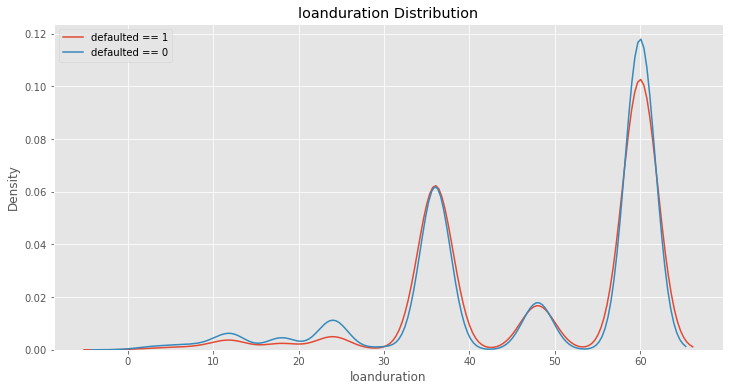

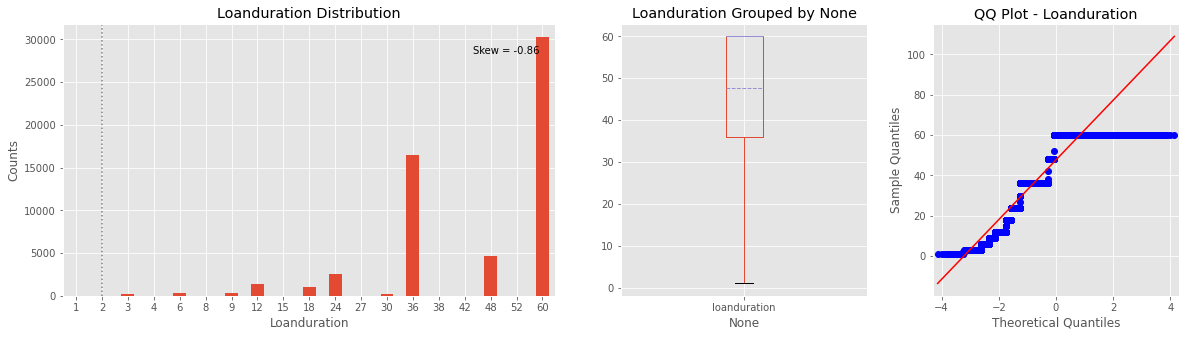

In [81]:
kde_target('loanduration', train)
numerical_plot('loanduration', train, discrete=True)

In [82]:
train = power_trans('loanduration', train)

The correlation between loanduration_log and the TARGET is 0.0409
Median value for loan that is non-default = 4.1109
Median value for loan that defaulted =     4.1109


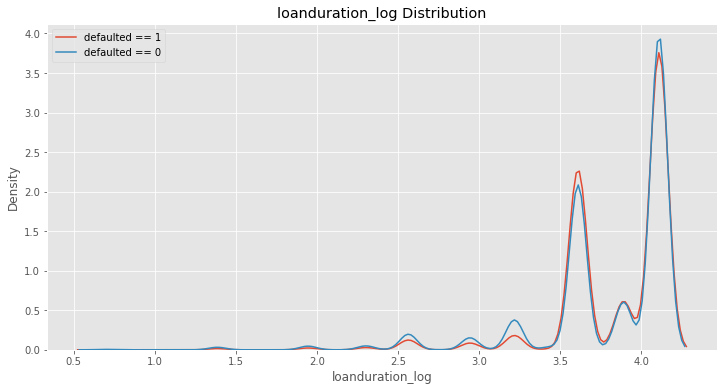

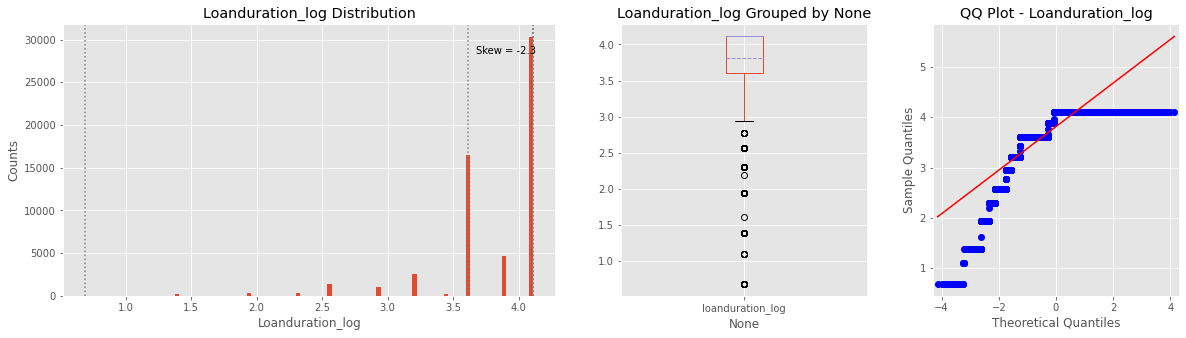

The correlation between loanduration_yeo and the TARGET is 0.0203
Median value for loan that is non-default = 0.8890
Median value for loan that defaulted =     0.8890


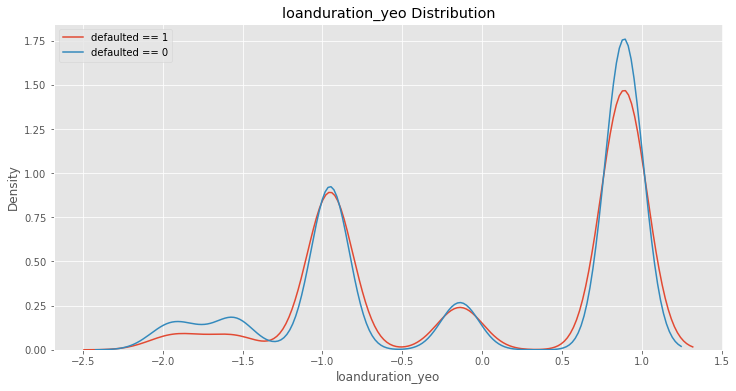

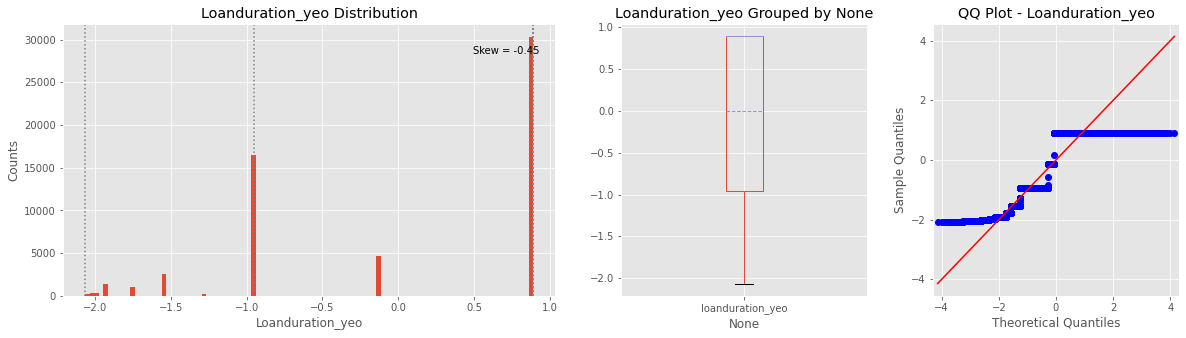

The correlation between loanduration_quantile and the TARGET is 0.0139
Median value for loan that is non-default = 1.0000
Median value for loan that defaulted =     1.0000


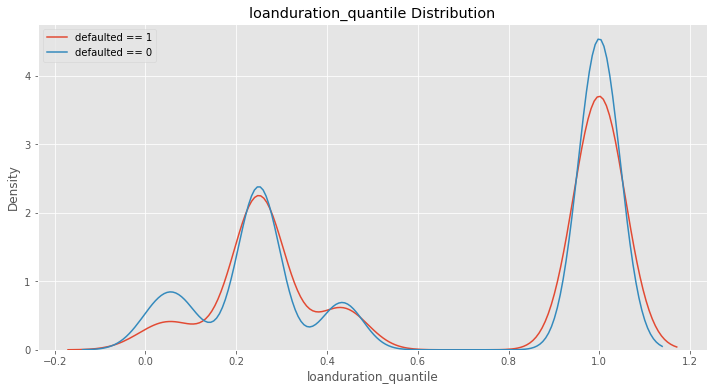

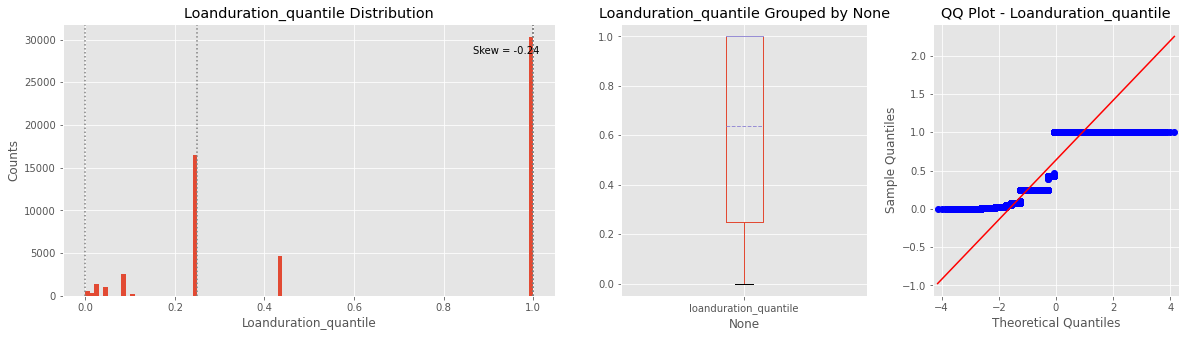

In [83]:
ls = ['loanduration_log', 'loanduration_yeo', 'loanduration_quantile']
for l in ls:
    kde_target(l, train)
    numerical_plot(l, train)

In general, the transformations are terrible. lets explore binning.

In [84]:
# consolidate low occuring values
train['loanduration'].value_counts(normalize=True, dropna=False).sort_index()

1     0.000573
2     0.000087
3     0.003752
4     0.000017
6     0.005454
8     0.000017
9     0.005940
12    0.024091
15    0.000122
18    0.018272
24    0.044396
27    0.000017
30    0.003717
36    0.285950
38    0.000017
42    0.000017
48    0.081271
52    0.000017
60    0.526271
Name: loanduration, dtype: float64

In [85]:
# try binning
var = 'loanduration'
test = train.copy()
# test[var] = test[var].astype(str)
test.loc[test[var] <=12, var] = 1
test.loc[(test[var] > 12) & (test[var] <= 24), var] = 2
test.loc[(test[var] > 24) & (test[var] <= 36), var] = 3
test.loc[(test[var] > 36) & (test[var] <= 48), var] = 4
test.loc[(test[var] > 48) & (test[var] <= 60), var] = 5

The correlation between loanduration and the TARGET is 0.0271
Median value for loan that is non-default = 5.0000
Median value for loan that defaulted =     5.0000


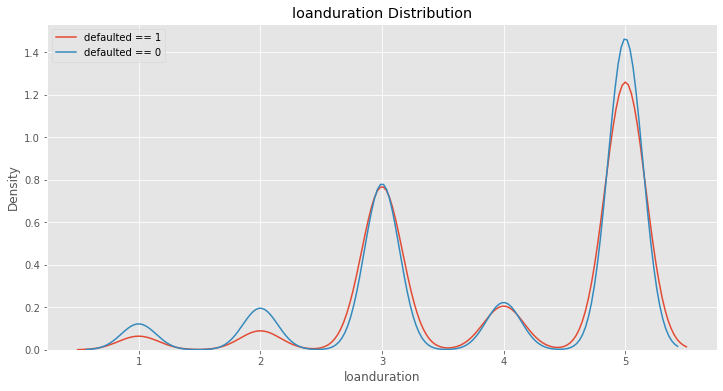

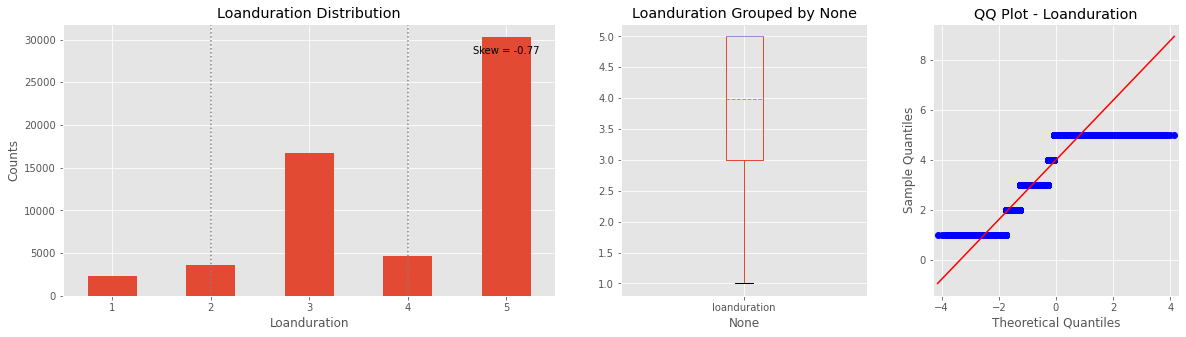

In [86]:
kde_target('loanduration', test)
numerical_plot('loanduration', test, discrete=True)

In [87]:
train, loanduration_edges = make_bins('loanduration', train, bins=5, strategy='uniform')

In [88]:
loanduration_edges

array([array([ 1. , 12.8, 24.6, 36.4, 48.2, 60. ])], dtype=object)

### incometotal

The correlation between incometotal and the TARGET is 0.0021
Median value for loan that is non-default = 1300.0000
Median value for loan that defaulted =     1400.0000


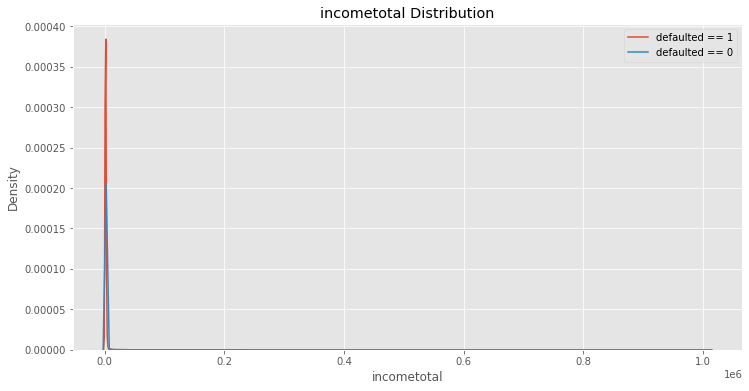

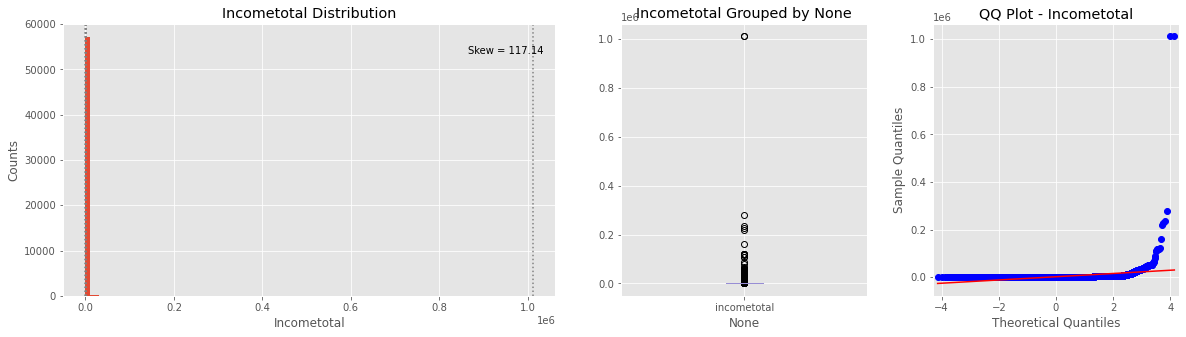

In [91]:
kde_target('incometotal', train)
numerical_plot('incometotal', train)

In [92]:
train = power_trans('incometotal', train)

The correlation between incometotal_log and the TARGET is 0.0484
Median value for loan that is non-default = 7.1709
Median value for loan that defaulted =     7.2449


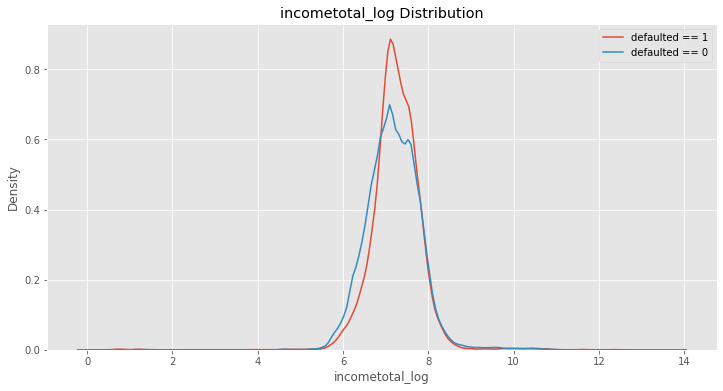

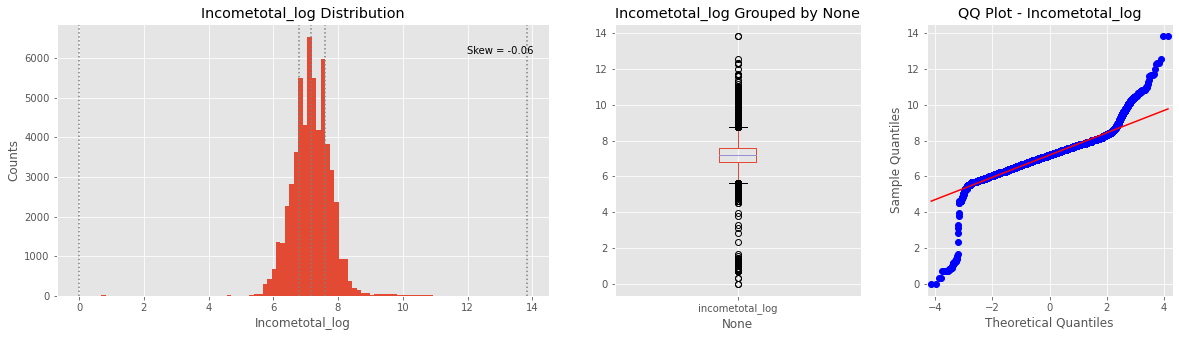

The correlation between incometotal_quantile and the TARGET is 0.0587
Median value for loan that is non-default = 0.4930
Median value for loan that defaulted =     0.5400


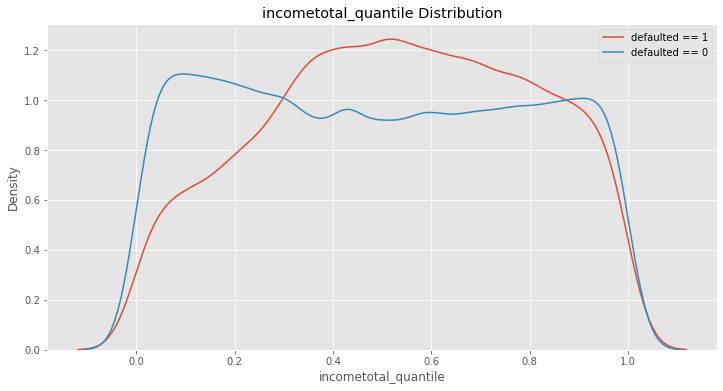

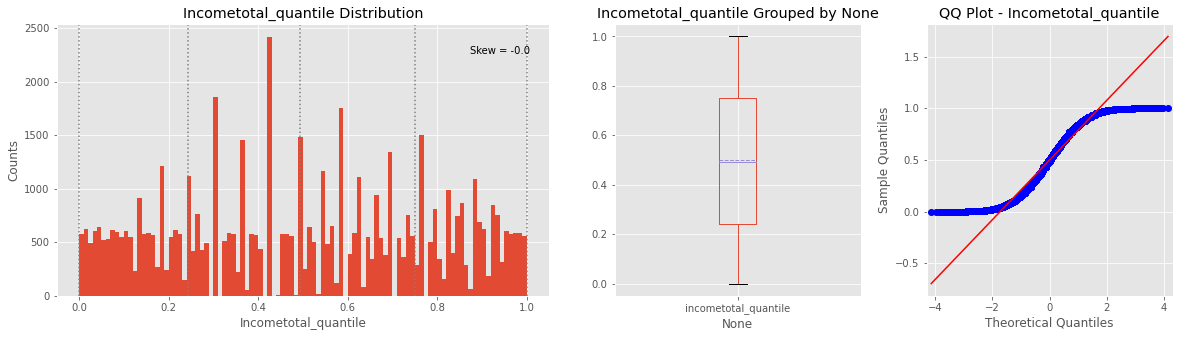

The correlation between incometotal_yeo and the TARGET is 0.0482
Median value for loan that is non-default = -0.0352
Median value for loan that defaulted =     0.0837


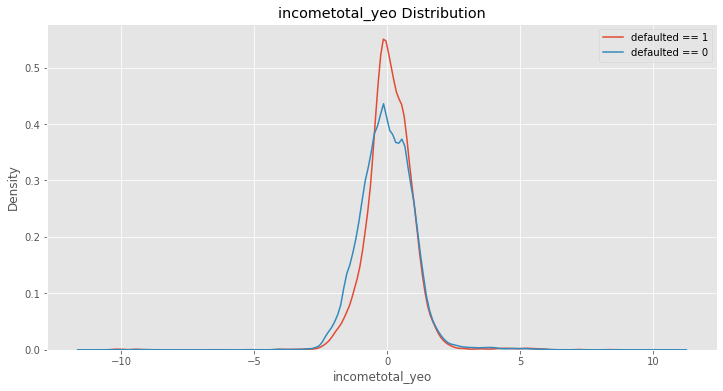

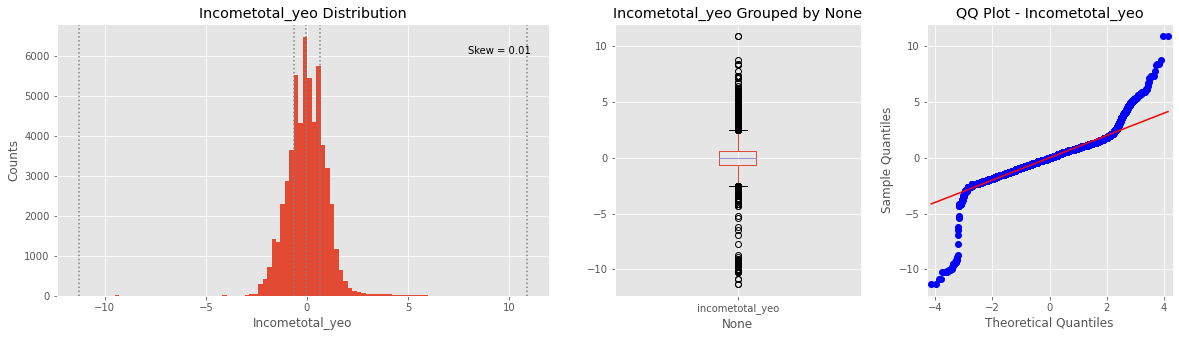

In [93]:
for col in train.columns[train.columns.str.contains('\A(?:income.*_)', regex=True)]:
    kde_target(col, train)
    numerical_plot(col, train)

Powertransformations for incometotal seems very effective.

In [94]:
check_bin('incometotal', train)

2bin
0.054306618772302626
Cramer's V = 0.05410534702592366
Pearson Chi-squared
probability = 0.950, critical = 3.841, stat = 169.536
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)
3bin
0.06153617870051752
Cramer's V = 0.10196037502513859
Pearson Chi-squared
probability = 0.950, critical = 5.991, stat = 600.514
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)
4bin
0.06116009461737269
Cramer's V = 0.1028146793271671
Pearson Chi-squared
probability = 0.950, critical = 7.815, stat = 611.586
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)
5bin
0.059448316588718894
Cramer's V = 0.10582482626971364
Pearson Chi-squared
probability = 0.950, critical = 9.488, stat = 648.743
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)
6bin
0.06172791005980752
Cramer's V = 0.11201910028928047
Pearson Chi-squared
probability = 0.950, critical = 11.070, stat = 727.430
Dependent (reject H0)
significance

In [95]:
# 6 seems to be the best
train, incometotal_edges = make_bins('incometotal', train, 6)

In [96]:
incometotal_edges

array([array([0.000000e+00, 7.740000e+02, 1.043000e+03, 1.300000e+03,
       1.700000e+03, 2.250000e+03, 1.012019e+06])], dtype=object)

In [97]:
train.columns

Index(['defaulted', 'loanid', 'username', 'loanapplicationstarteddate',
       'languagecode', 'age', 'gender', 'country', 'appliedamount', 'interest',
       'loanduration', 'education', 'maritalstatus', 'nrofdependants',
       'employmentstatus', 'employmentdurationcurrentemployer',
       'workexperience', 'occupationarea', 'homeownershiptype', 'incometotal',
       'existingliabilities', 'liabilitiestotal', 'debttoincome',
       'noofearlierdefaults', 'noofpreviousloansbeforeloan',
       'amountofpreviousloansbeforeloan', 'priorrepayments',
       'previousearlyrepaymentsbeforeloan',
       'previousearlyrepaymentscountbeforeloan', 'appliedamount_quantile',
       'appliedamount_log', 'appliedamount_yeo', 'test',
       'appliedamount_binned', 'interest_log', 'interest_quantile',
       'interest_yeo', 'interest_binned', 'loanduration_log',
       'loanduration_quantile', 'loanduration_yeo', 'loanduration_binned',
       'incometotal_log', 'incometotal_quantile', 'incometotal_ye

### noofpreviousloansbeforeloan

The correlation between noofpreviousloansbeforeloan and the TARGET is -0.0669
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


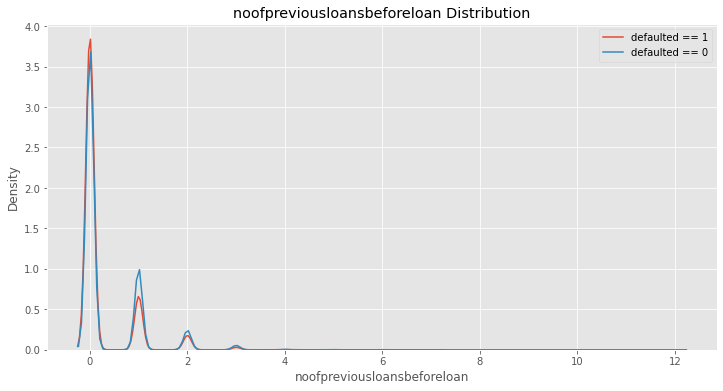

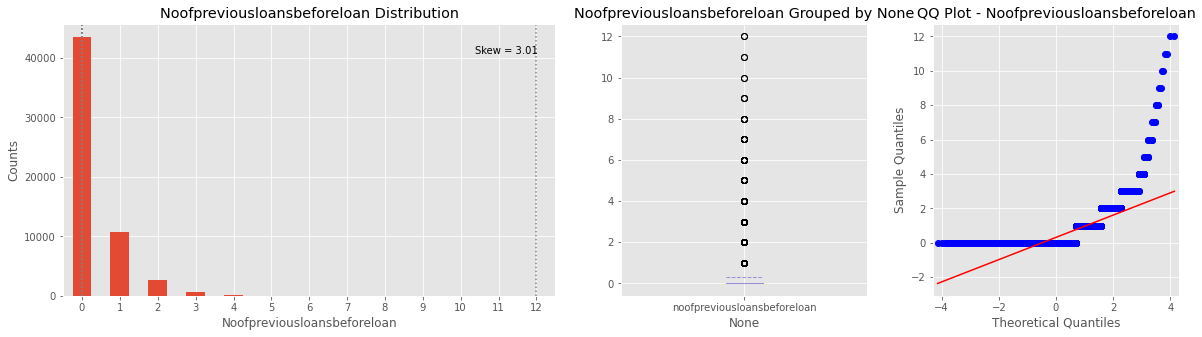

In [98]:
kde_target('noofpreviousloansbeforeloan', train)
numerical_plot('noofpreviousloansbeforeloan', train, discrete=True)

The correlation between noofpreviousloansbeforeloan_log and the TARGET is -0.0725
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


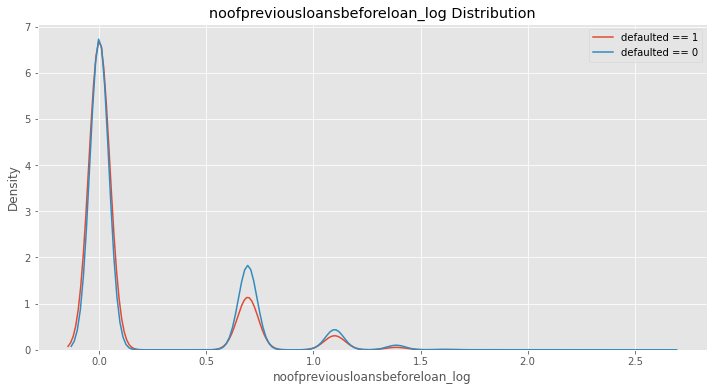

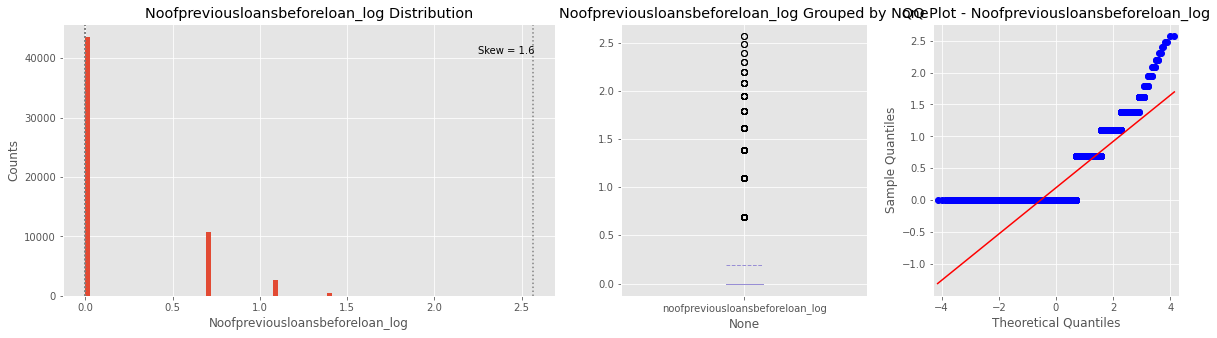

The correlation between noofpreviousloansbeforeloan_quantile and the TARGET is -0.0754
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


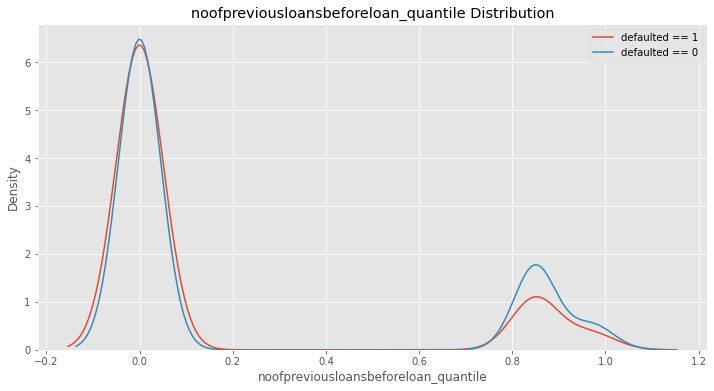

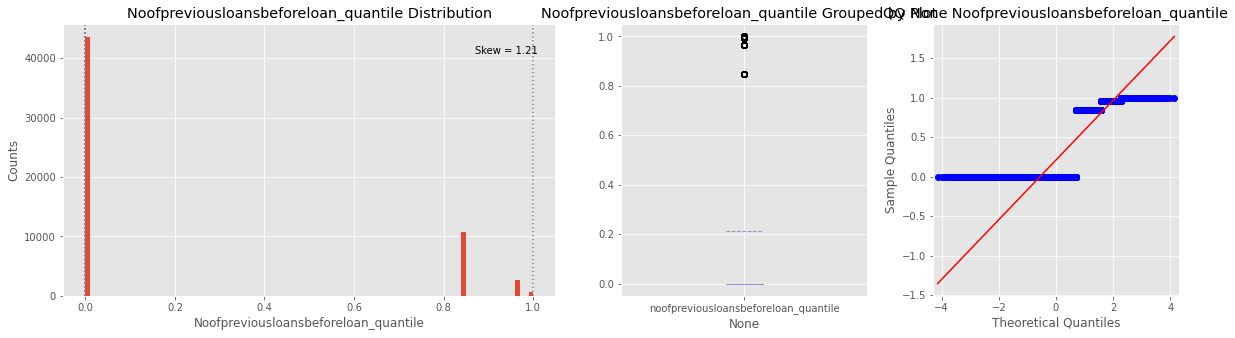

The correlation between noofpreviousloansbeforeloan_yeo and the TARGET is -0.0757
Median value for loan that is non-default = -0.5673
Median value for loan that defaulted =     -0.5673


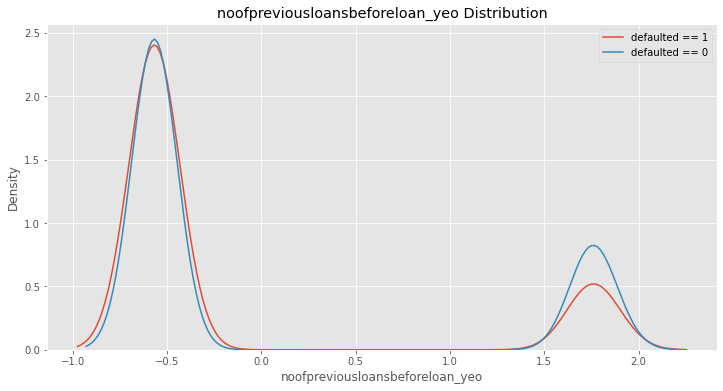

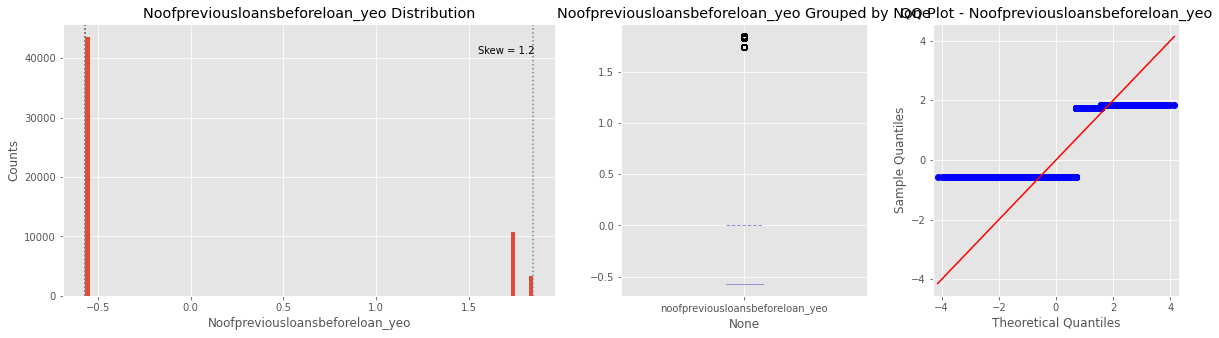

In [99]:
train = power_trans('noofpreviousloansbeforeloan', train)
for col in train.columns[train.columns.str.contains('\A(?:noofpreviousloansbeforeloan.*_)', regex=True)]:
    kde_target(col, train)
    numerical_plot(col, train)

In [100]:
train = make_bins('noofpreviousloansbeforeloan', train, encode='binarize')

In [101]:
train['noofpreviousloansbeforeloan_binned'].value_counts()

0    43552
1    14021
Name: noofpreviousloansbeforeloan_binned, dtype: int64

The correlation between noofpreviousloansbeforeloan_binned and the TARGET is -0.0757
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


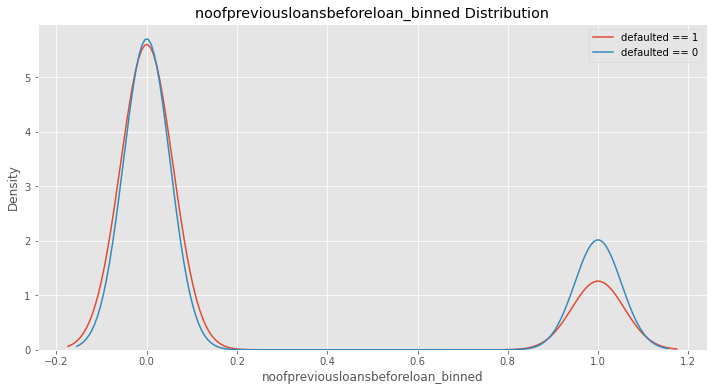

Cramer's V = 0.07558529155183383
Pearson Chi-squared
probability = 0.950, critical = 3.841, stat = 329.917
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


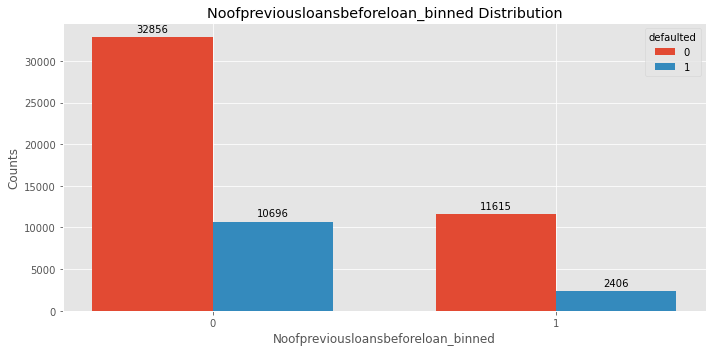

In [102]:
kde_target('noofpreviousloansbeforeloan_binned', train)
cat_plot('noofpreviousloansbeforeloan_binned', train)

### amountofpreviousloansbeforeloan

The correlation between amountofpreviousloansbeforeloan and the TARGET is -0.0519
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


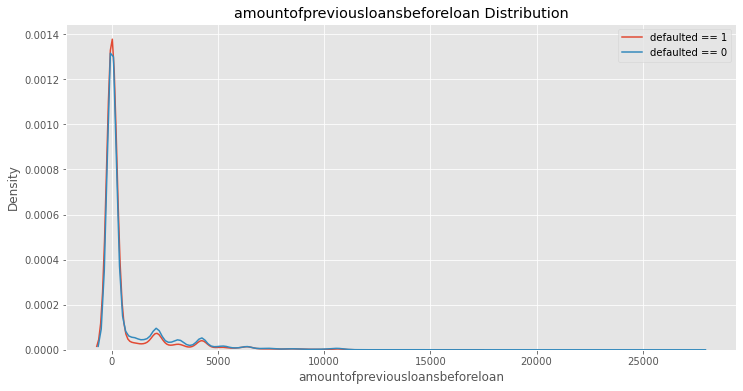

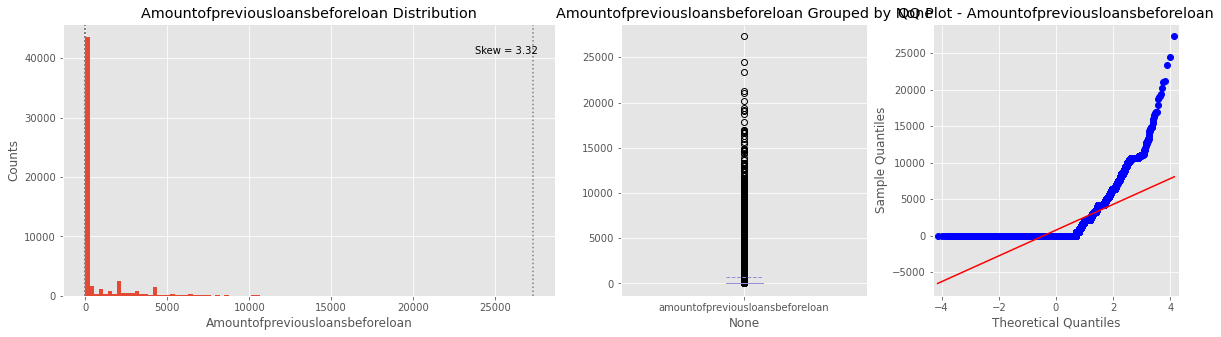

In [103]:
kde_target('amountofpreviousloansbeforeloan', train)
numerical_plot('amountofpreviousloansbeforeloan', train)

The correlation between amountofpreviousloansbeforeloan_log and the TARGET is -0.0741
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


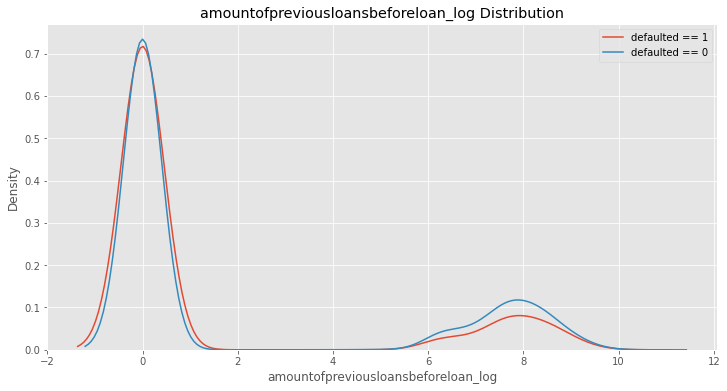

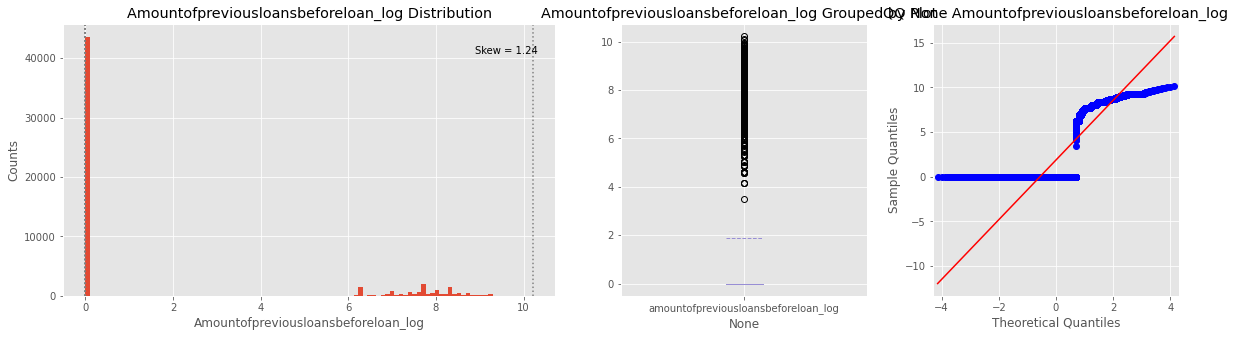

The correlation between amountofpreviousloansbeforeloan_quantile and the TARGET is -0.0745
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


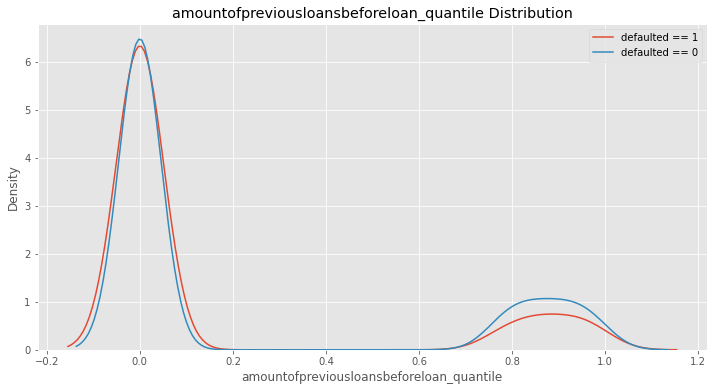

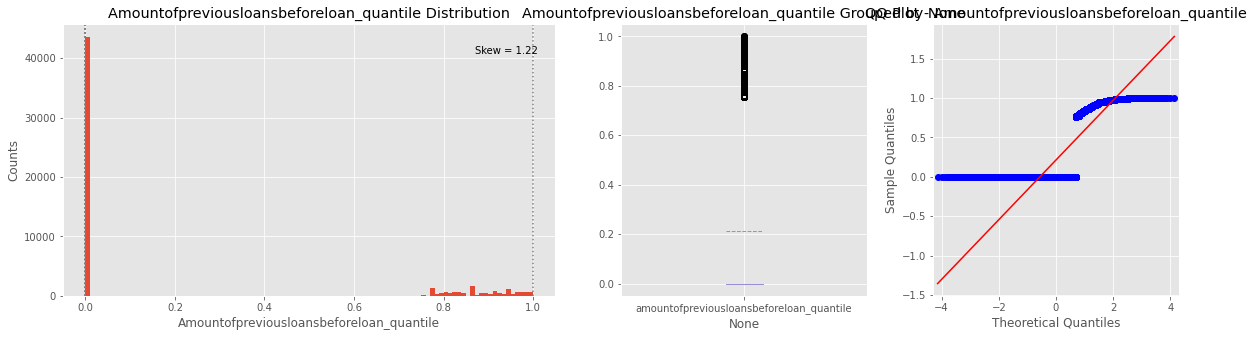

The correlation between amountofpreviousloansbeforeloan_yeo and the TARGET is -0.0756
Median value for loan that is non-default = -0.5673
Median value for loan that defaulted =     -0.5673


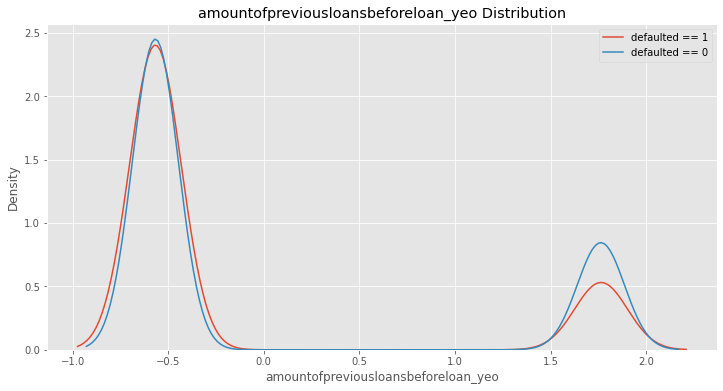

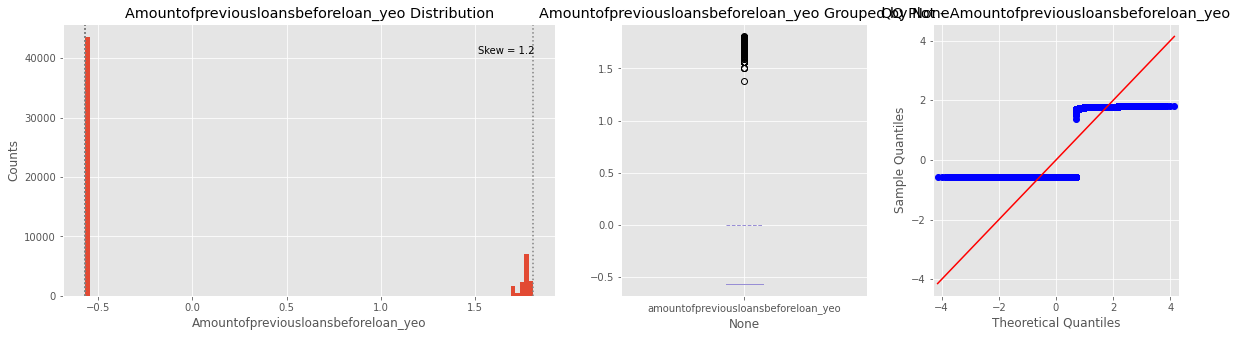

In [104]:
train = power_trans('amountofpreviousloansbeforeloan', train)
for col in train.columns[train.columns.str.contains('\A(?:amountofpreviousloansbeforeloan.*_)', regex=True)]:
    kde_target(col, train)
    numerical_plot(col, train)

The correlation between amountofpreviousloansbeforeloan_binned and the TARGET is -0.0757
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


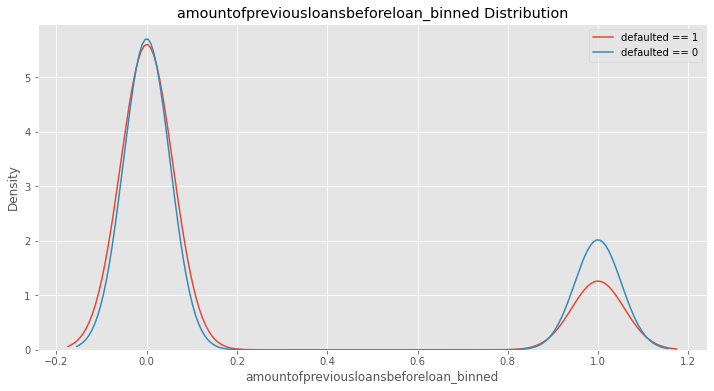

Cramer's V = 0.07558529155183383
Pearson Chi-squared
probability = 0.950, critical = 3.841, stat = 329.917
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


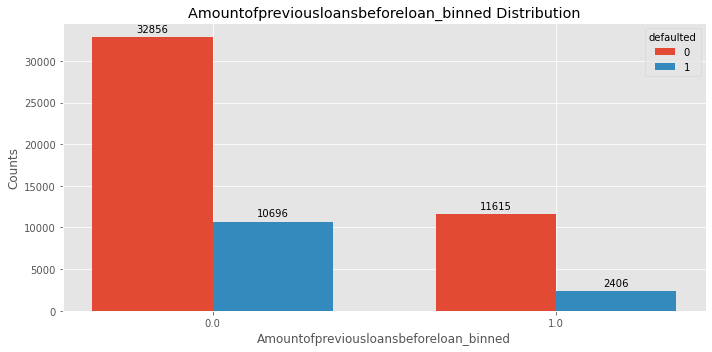

In [105]:
train = make_bins('amountofpreviousloansbeforeloan', train, encode='binarize')
kde_target('amountofpreviousloansbeforeloan_binned', train)
cat_plot('amountofpreviousloansbeforeloan_binned', train)

### priorrepayments

The correlation between priorrepayments and the TARGET is -0.0404
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


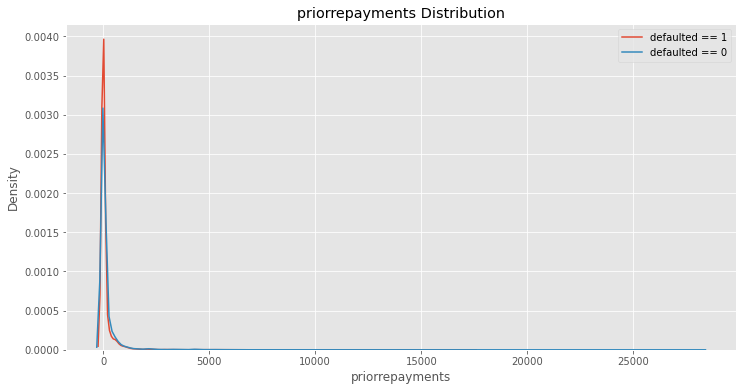

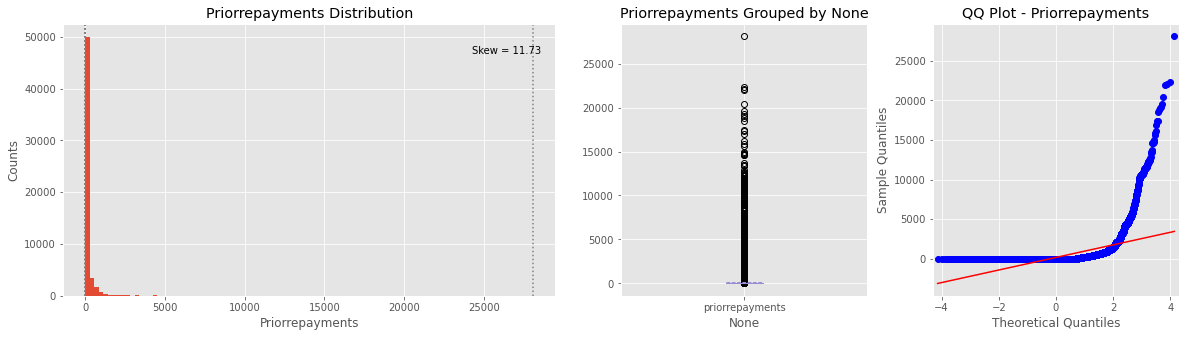

In [106]:
kde_target('priorrepayments', train)
numerical_plot('priorrepayments', train)

The correlation between priorrepayments_log and the TARGET is -0.0720
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


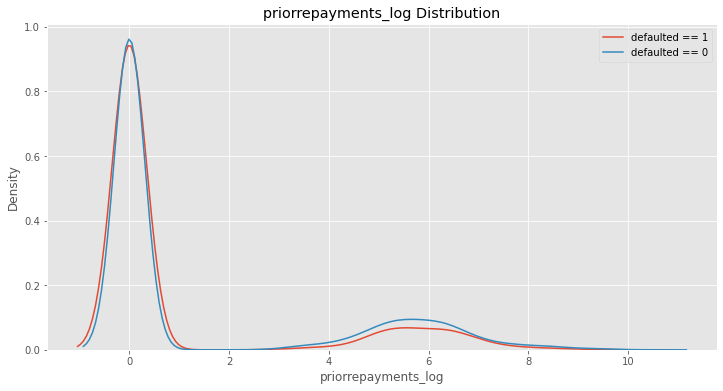

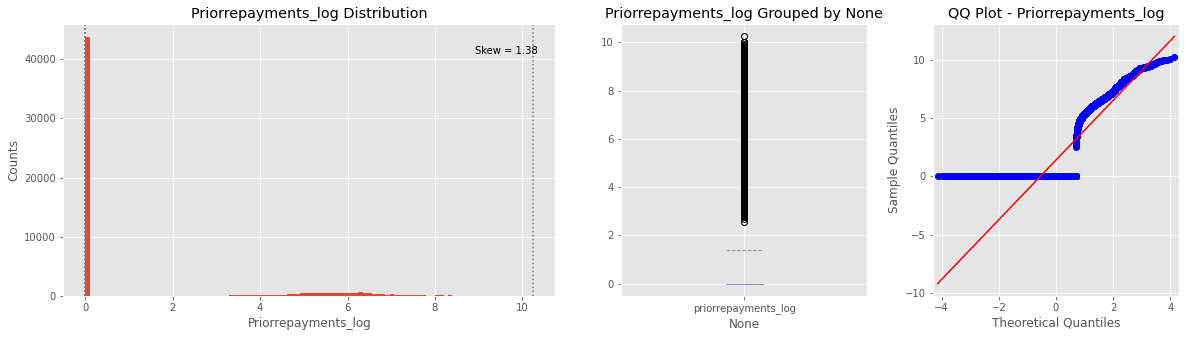

The correlation between priorrepayments_quantile and the TARGET is -0.0741
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


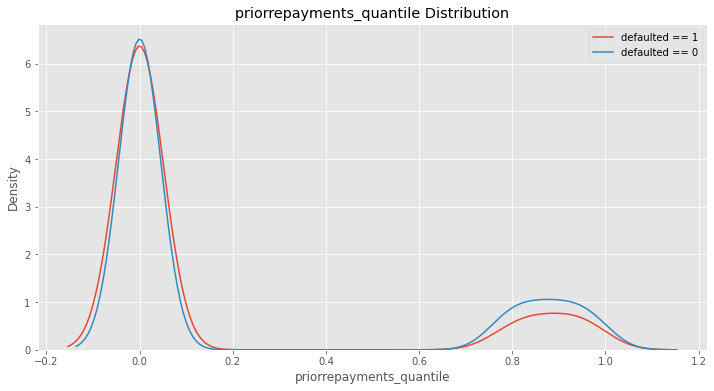

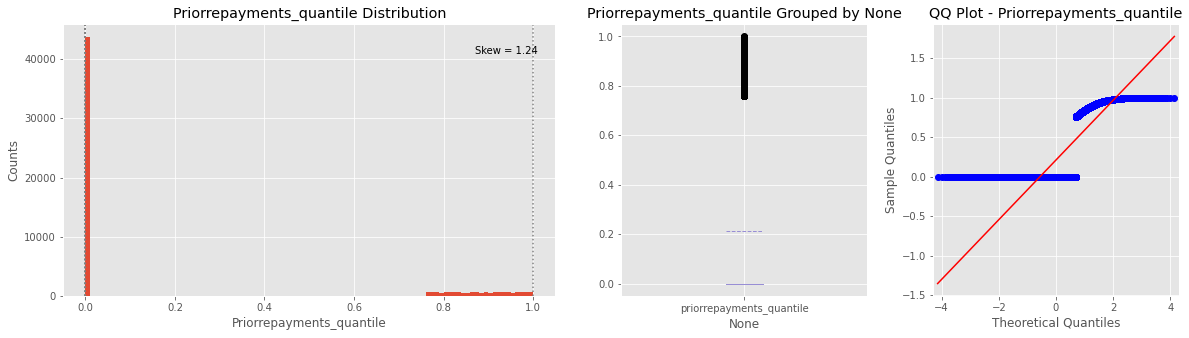

The correlation between priorrepayments_yeo and the TARGET is -0.0749
Median value for loan that is non-default = -0.5624
Median value for loan that defaulted =     -0.5624


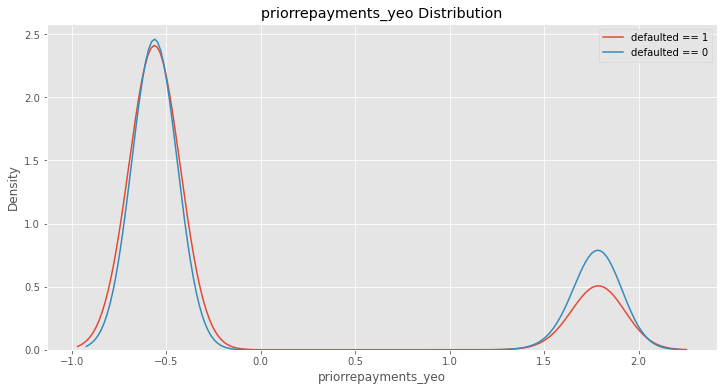

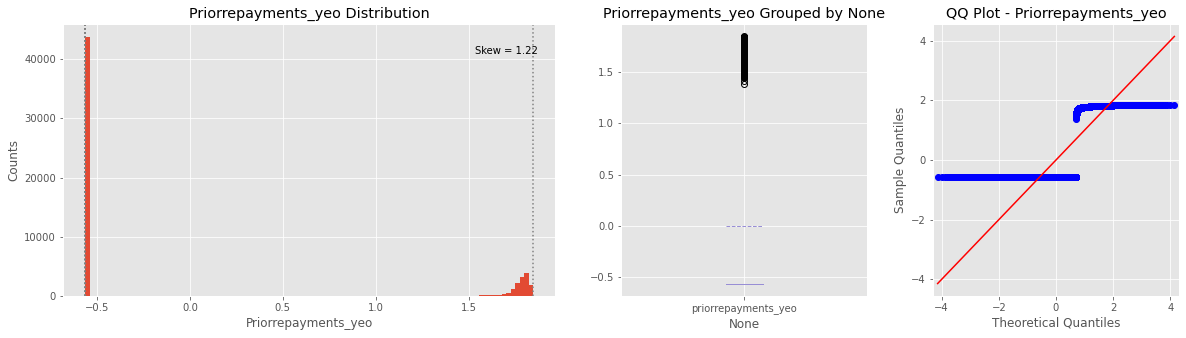

In [107]:
train = power_trans('priorrepayments', train)
for col in train.columns[train.columns.str.contains('\A(?:priorrepayments.*_)', regex=True)]:
    kde_target(col, train)
    numerical_plot(col, train)

The correlation between priorrepayments_binned and the TARGET is -0.0754
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


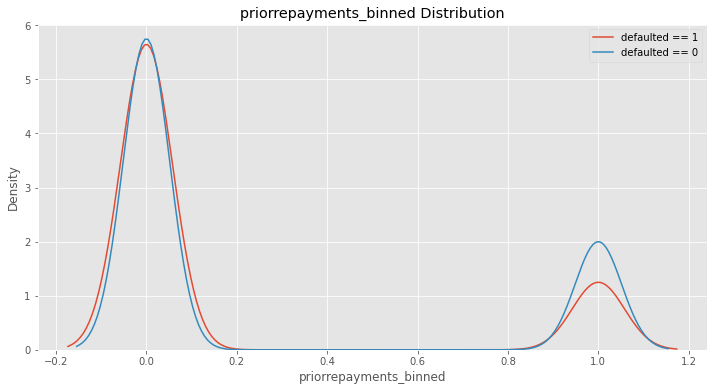

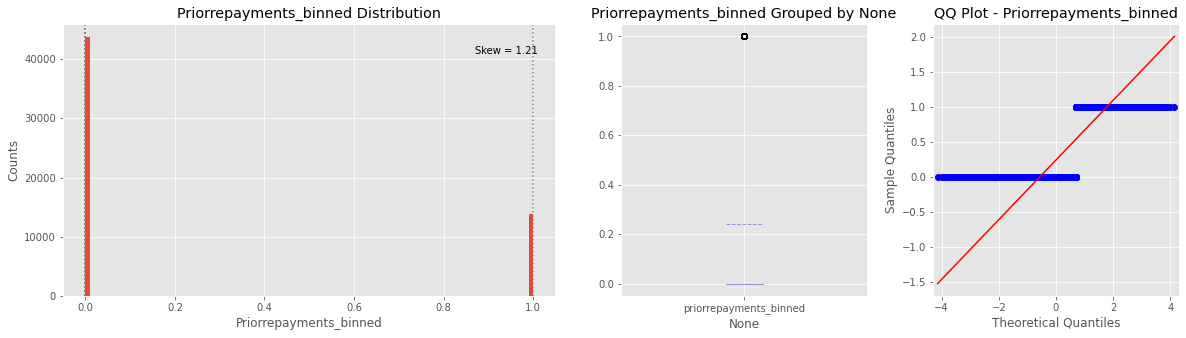

In [108]:
train = make_bins('priorrepayments', train, encode='binarize')
kde_target('priorrepayments_binned', train)
numerical_plot('priorrepayments_binned', train)

### noofearlierdefaults

The correlation between noofearlierdefaults and the TARGET is 0.0038
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


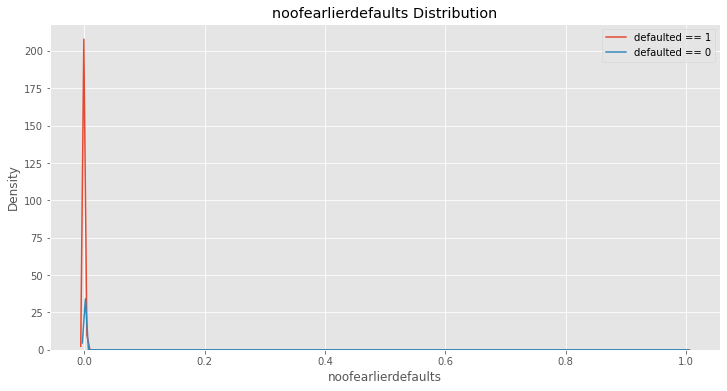

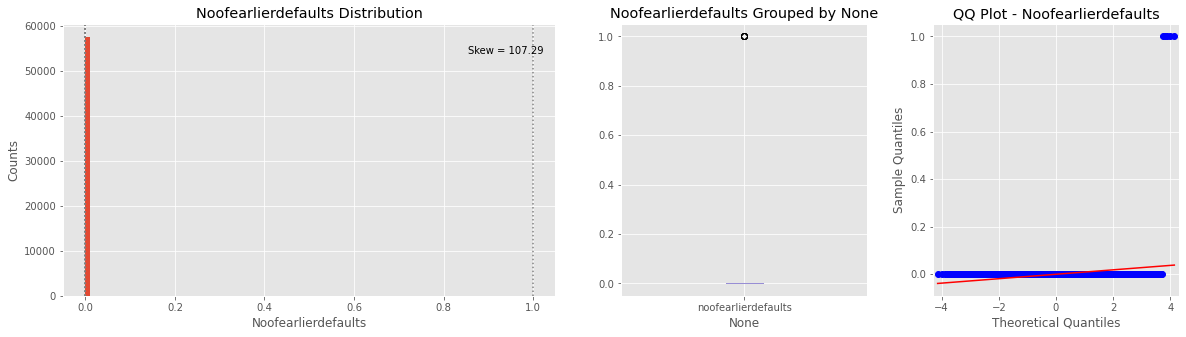

In [109]:
kde_target('noofearlierdefaults', train)
numerical_plot('noofearlierdefaults', train)

In [110]:
np.var(df['noofearlierdefaults'])

0.00012503820416314657

In [111]:
train['noofearlierdefaults'].value_counts()

0    57568
1        5
Name: noofearlierdefaults, dtype: int64

Consider dropping this.

### previousearlyrepaymentsbeforeloan

The correlation between previousearlyrepaymentsbeforeloan and the TARGET is -0.0162
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


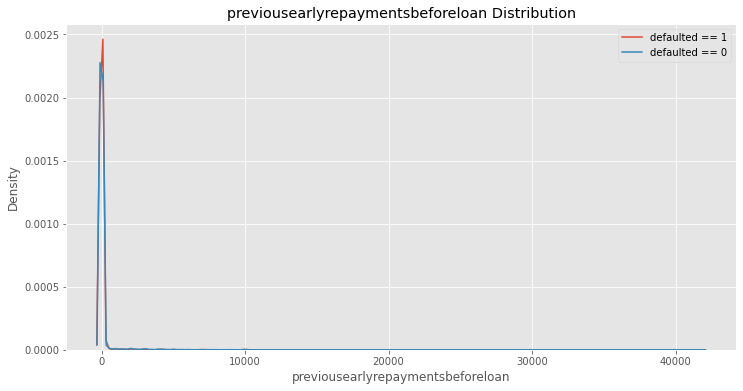

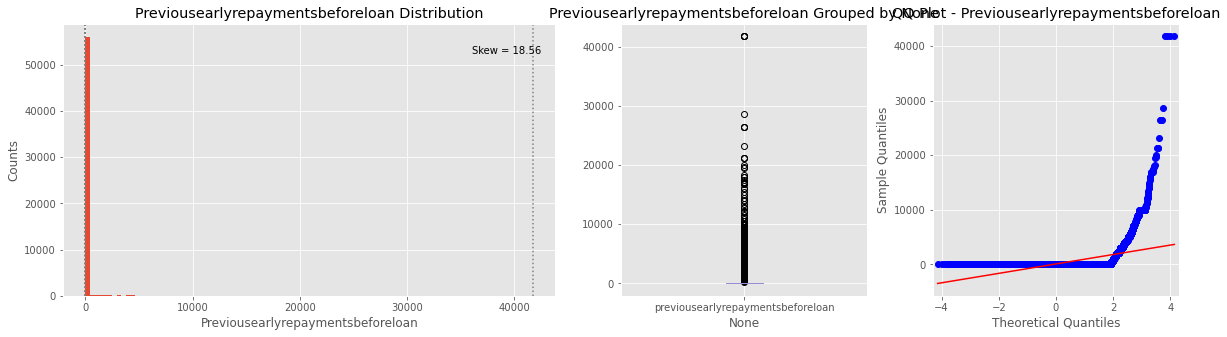

In [112]:
kde_target('previousearlyrepaymentsbeforeloan', train)
numerical_plot('previousearlyrepaymentsbeforeloan', train)

The correlation between previousearlyrepaymentsbeforeloan_log and the TARGET is -0.0211
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


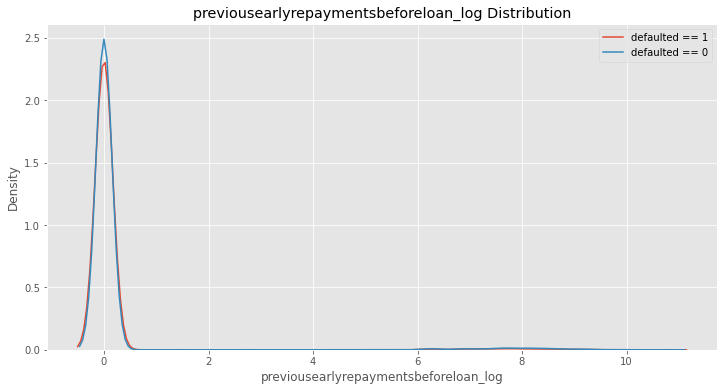

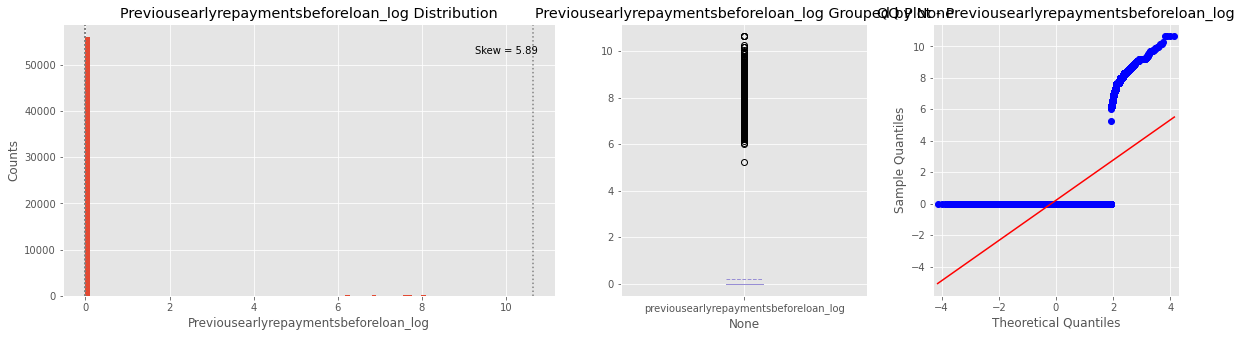

The correlation between previousearlyrepaymentsbeforeloan_quantile and the TARGET is -0.0207
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


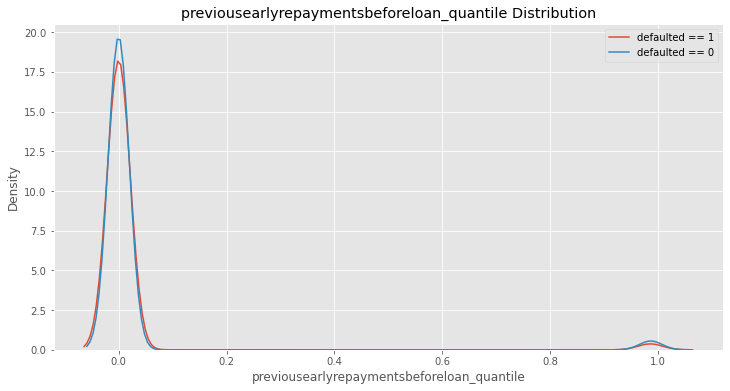

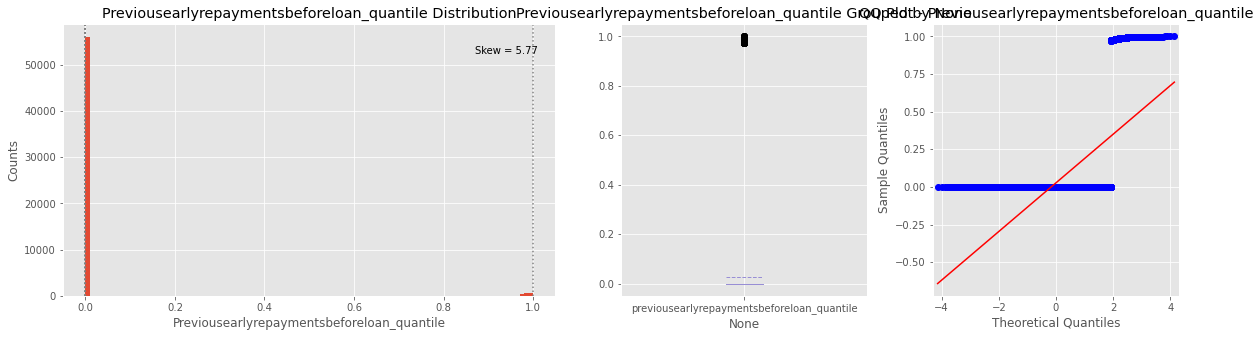

The correlation between previousearlyrepaymentsbeforeloan_yeo and the TARGET is -0.0207
Median value for loan that is non-default = -0.1685
Median value for loan that defaulted =     -0.1685


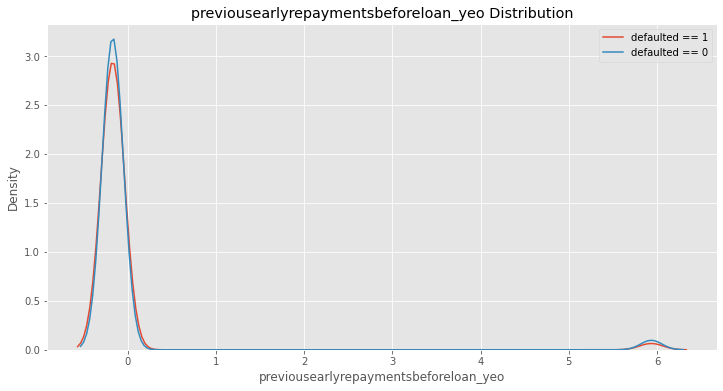

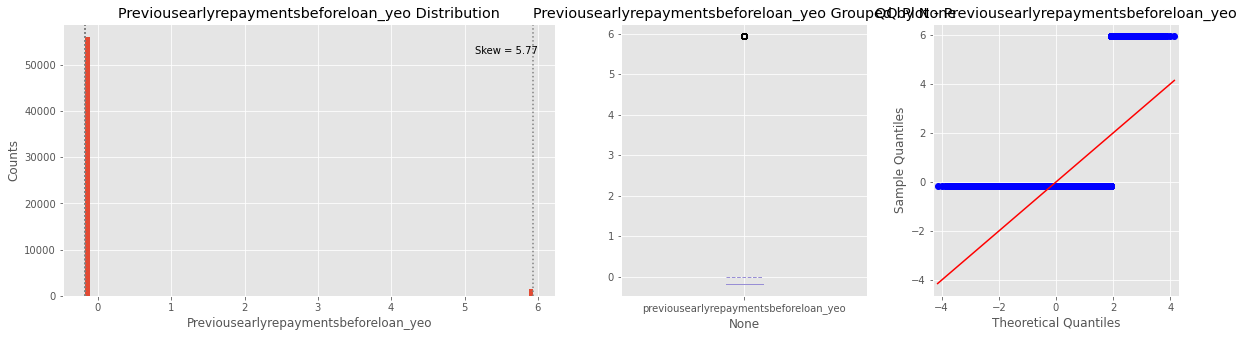

In [113]:
train = power_trans('previousearlyrepaymentsbeforeloan', train)
for col in train.columns[train.columns.str.contains('\A(?:previousearlyrepaymentsbeforeloan.*_)', regex=True)]:
    kde_target(col, train)
    numerical_plot(col, train)

In [114]:
train = make_bins('previousearlyrepaymentsbeforeloan', train, encode='binarize')

The correlation between previousearlyrepaymentsbeforeloan_binned and the TARGET is -0.0207
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


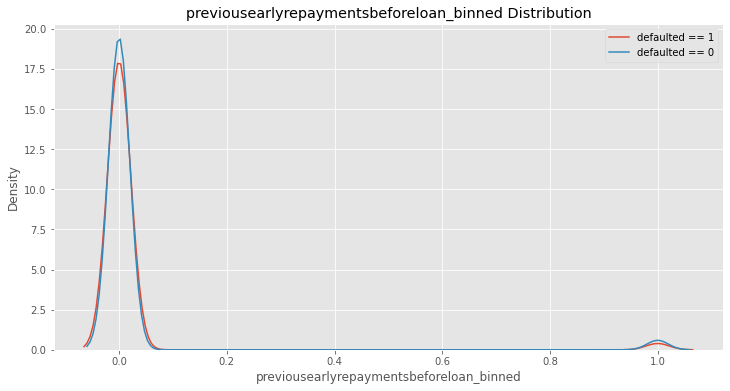

Cramer's V = 0.020136371127823637
Pearson Chi-squared
probability = 0.950, critical = 3.841, stat = 24.344
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


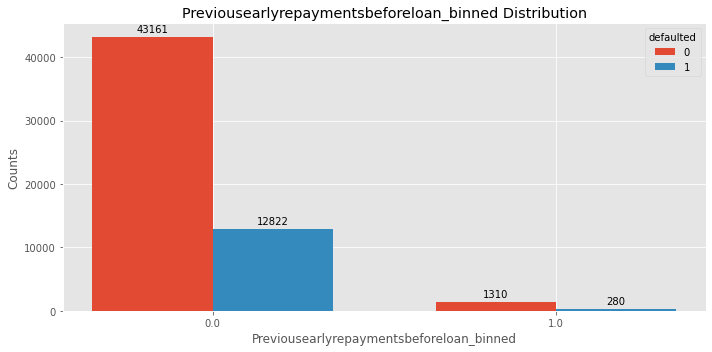

In [115]:
kde_target('previousearlyrepaymentsbeforeloan_binned', train)
cat_plot('previousearlyrepaymentsbeforeloan_binned', train)

### previousearlyrepaymentscountbeforeloan

The correlation between previousearlyrepaymentscountbeforeloan and the TARGET is -0.0207
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


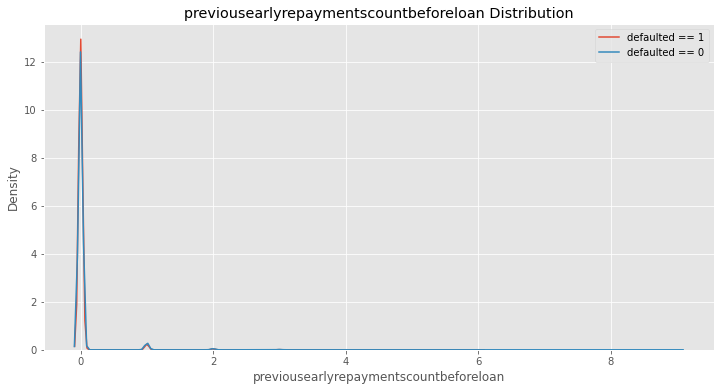

Cramer's V = 0.0180821008660381
Pearson Chi-squared
probability = 0.950, critical = 16.919, stat = 27.824
Dependent (reject H0)
significance = 0.050, p = 0.001
Dependent (reject H0)


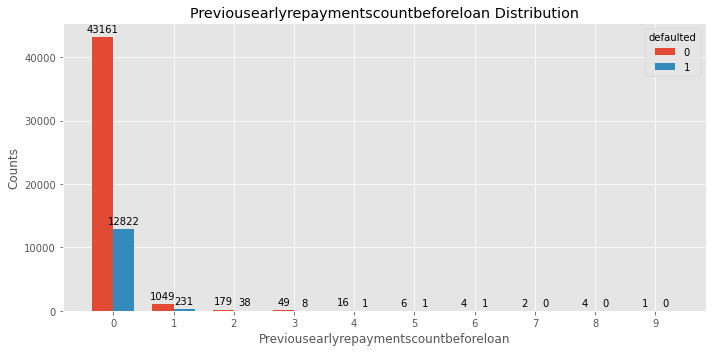

In [116]:
kde_target('previousearlyrepaymentscountbeforeloan', train)
cat_plot('previousearlyrepaymentscountbeforeloan', train)

The correlation between previousearlyrepaymentscountbeforeloan_log and the TARGET is -0.0214
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


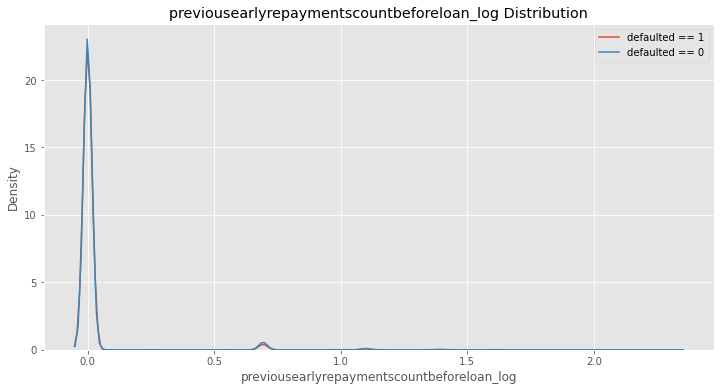

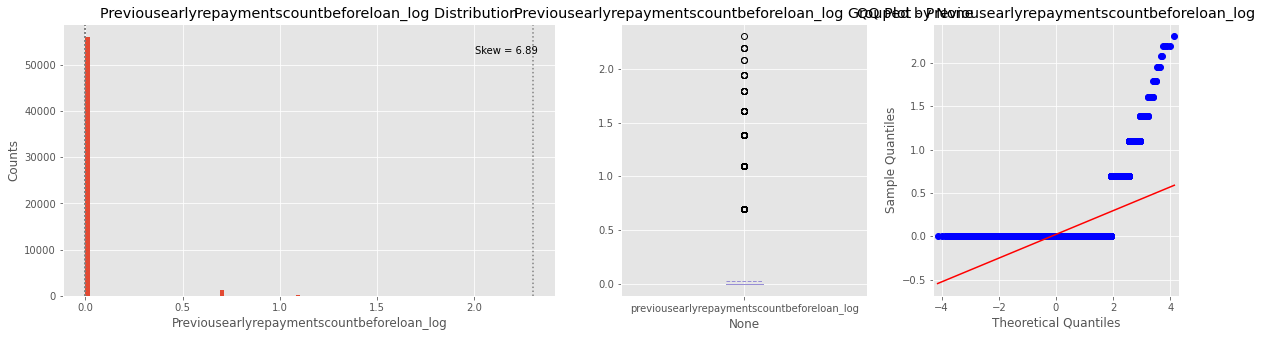

The correlation between previousearlyrepaymentscountbeforeloan_quantile and the TARGET is -0.0207
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


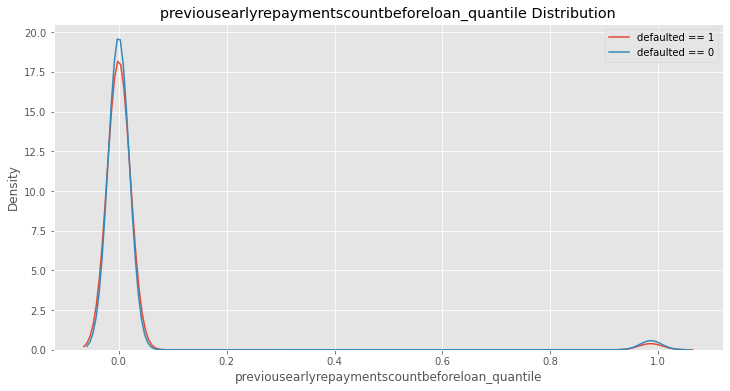

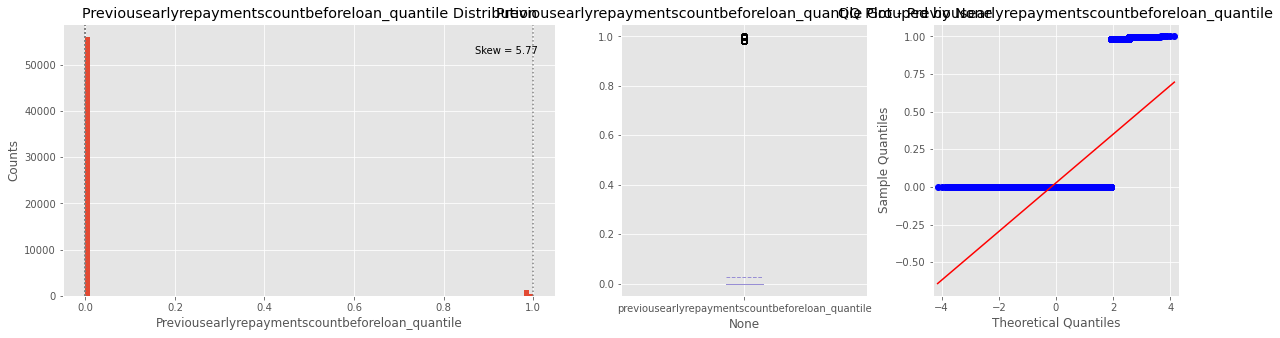

The correlation between previousearlyrepaymentscountbeforeloan_yeo and the TARGET is -0.0207
Median value for loan that is non-default = -0.1685
Median value for loan that defaulted =     -0.1685


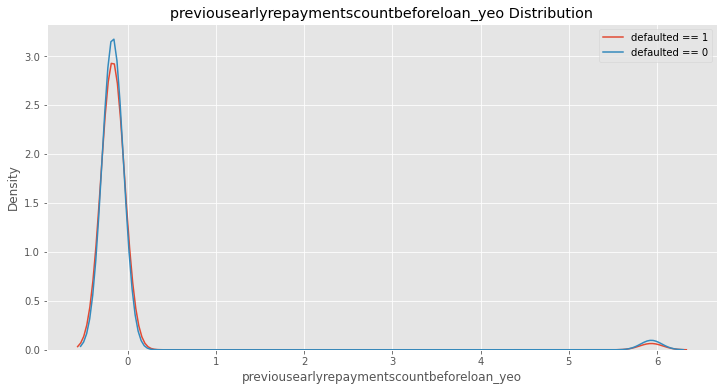

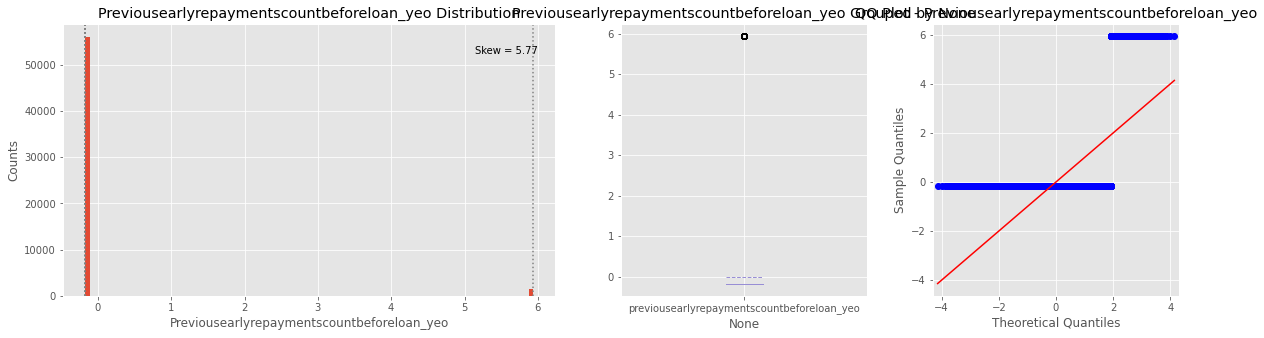

In [117]:
train = power_trans('previousearlyrepaymentscountbeforeloan', train)
for col in train.columns[train.columns.str.contains('\A(?:previousearlyrepaymentscountbeforeloan.*_)', regex=True)]:
    kde_target(col, train)
    numerical_plot(col, train)

In [118]:
train = make_bins('previousearlyrepaymentscountbeforeloan', train, encode='binarize')

The correlation between previousearlyrepaymentscountbeforeloan_binned and the TARGET is -0.0207
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


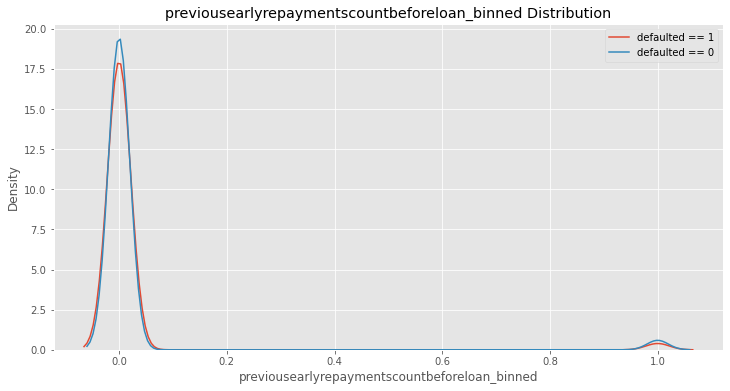

Cramer's V = 0.020136371127823637
Pearson Chi-squared
probability = 0.950, critical = 3.841, stat = 24.344
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


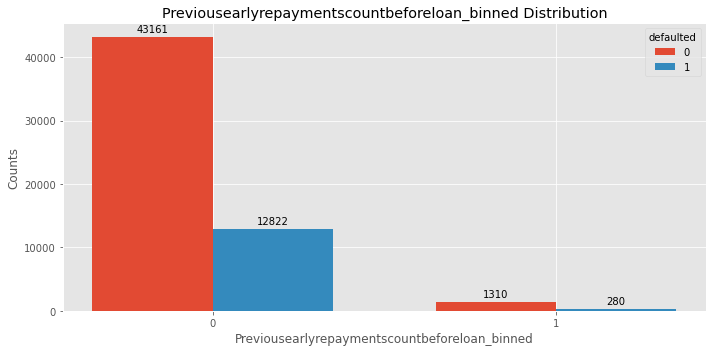

In [119]:
kde_target('previousearlyrepaymentscountbeforeloan_binned', train)
cat_plot('previousearlyrepaymentscountbeforeloan_binned', train)

### debttoincome

The correlation between debttoincome and the TARGET is -0.0526
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


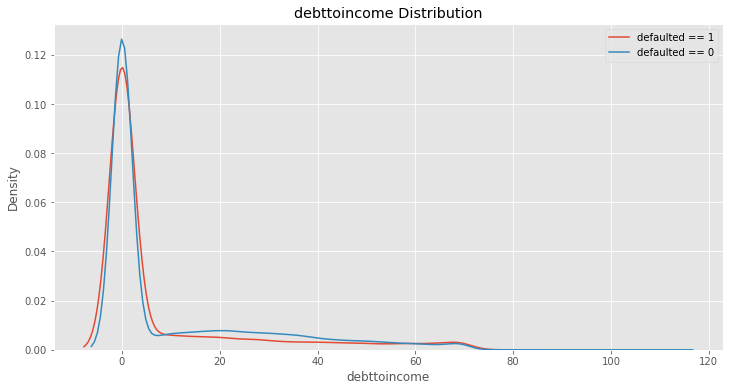

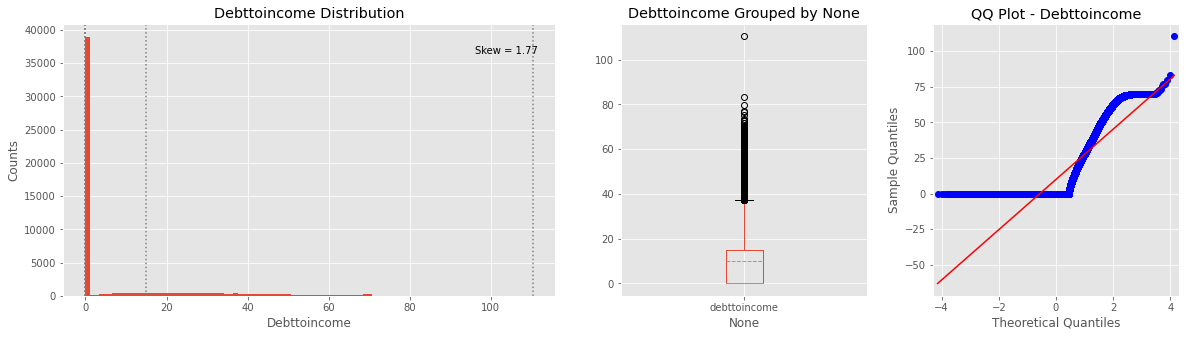

In [120]:
kde_target('debttoincome', train)
numerical_plot('debttoincome', train)

The correlation between debttoincome_log and the TARGET is -0.0718
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


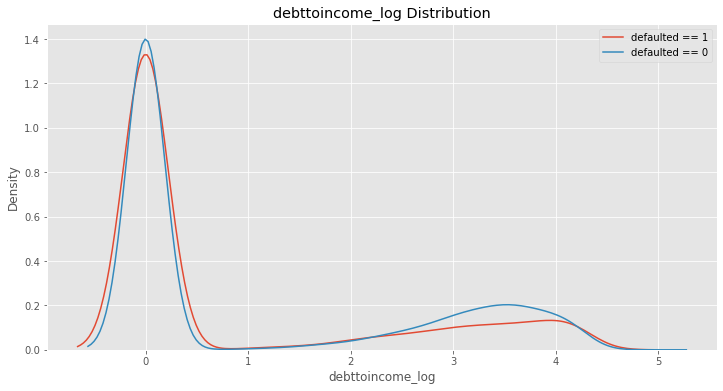

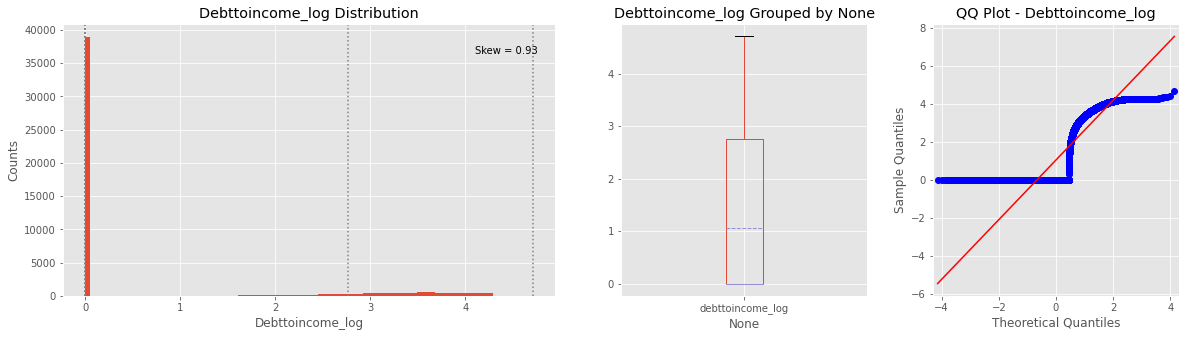

The correlation between debttoincome_quantile and the TARGET is -0.0709
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


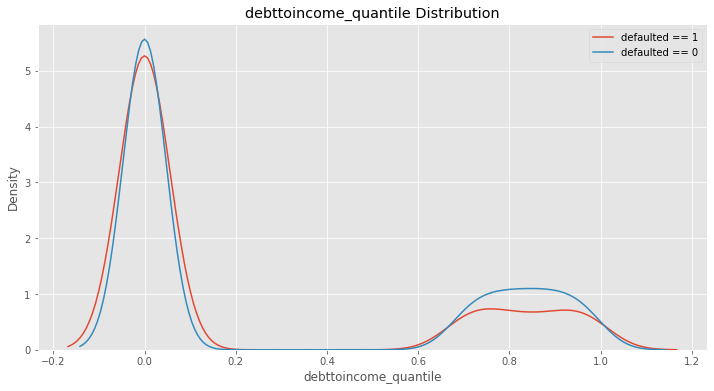

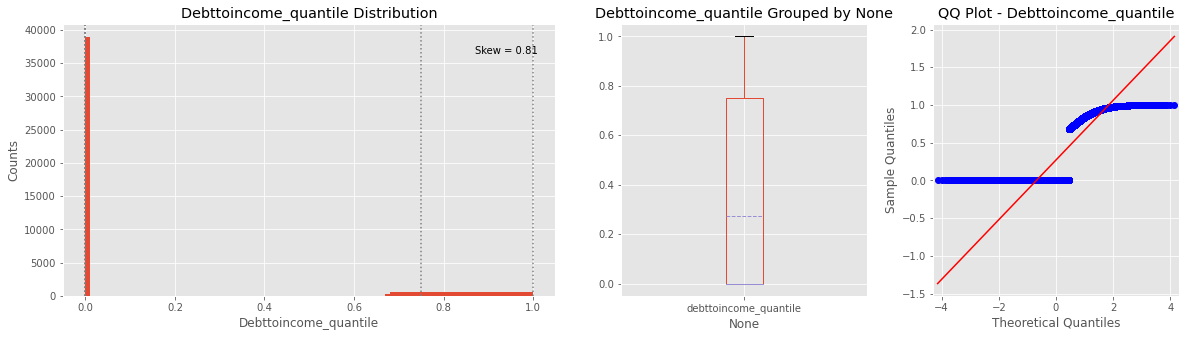

The correlation between debttoincome_yeo and the TARGET is -0.0733
Median value for loan that is non-default = -0.6887
Median value for loan that defaulted =     -0.6887


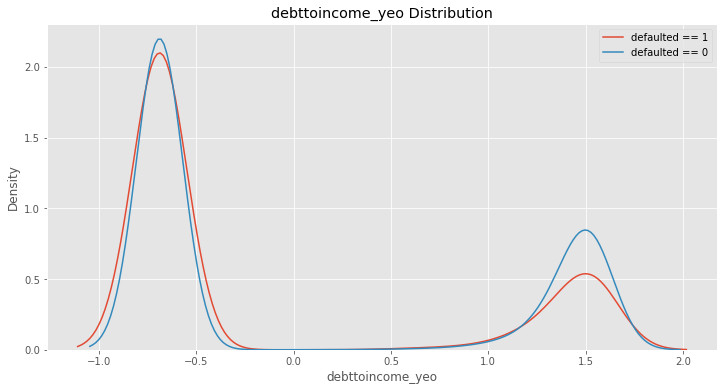

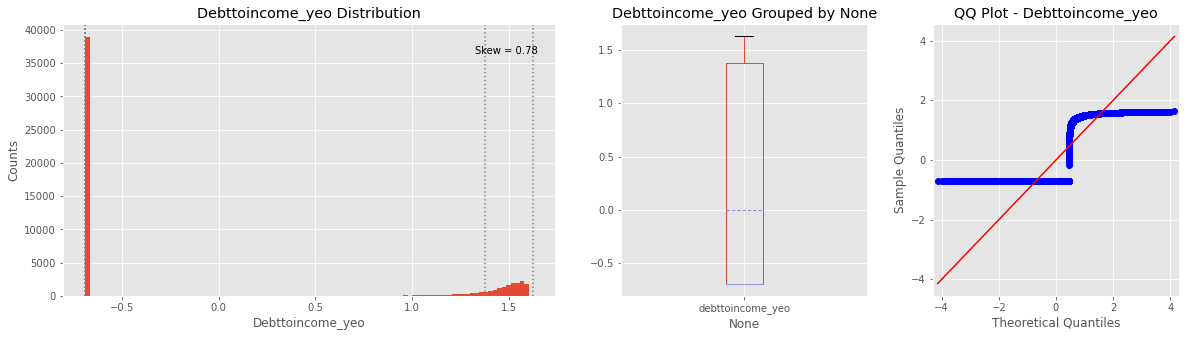

In [121]:
train = power_trans('debttoincome', train)
for col in train.columns[train.columns.str.contains('\A(?:debttoincome.*_)', regex=True)]:
    kde_target(col, train)
    numerical_plot(col, train)

In [122]:
train = make_bins('debttoincome', train, encode='binarize')

The correlation between debttoincome_binned and the TARGET is -0.0715
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


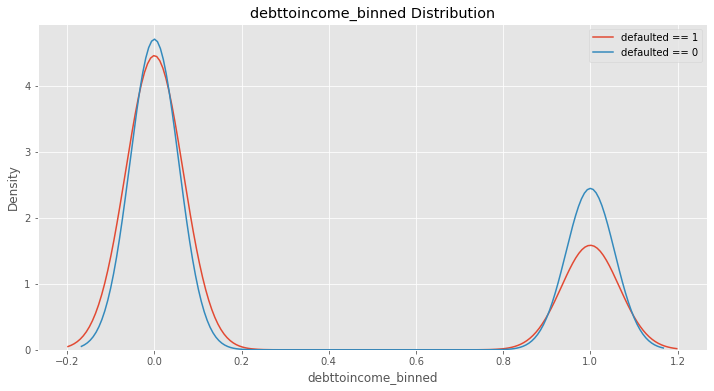

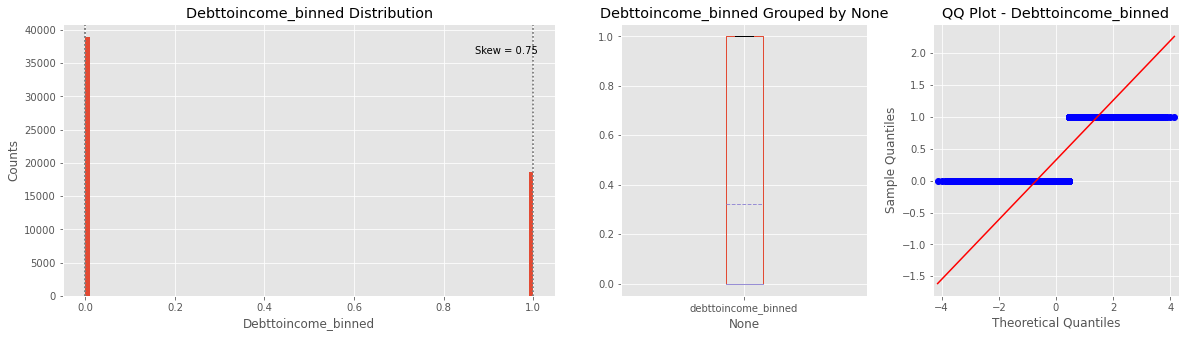

In [123]:
kde_target('debttoincome_binned', train)
numerical_plot('debttoincome_binned', train)

### existingliabilities

The correlation between existingliabilities and the TARGET is -0.0997
Median value for loan that is non-default = 2.0000
Median value for loan that defaulted =     1.0000


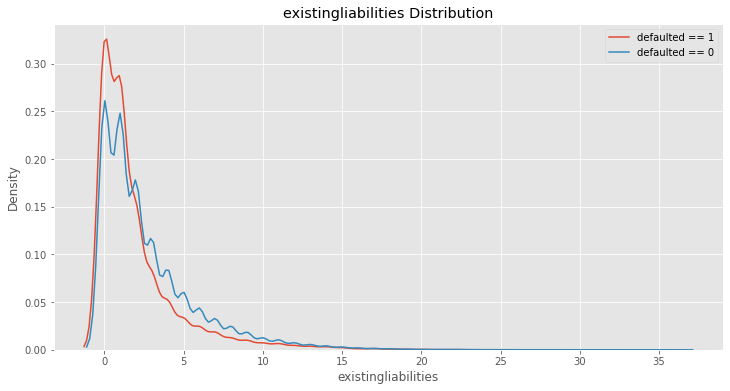

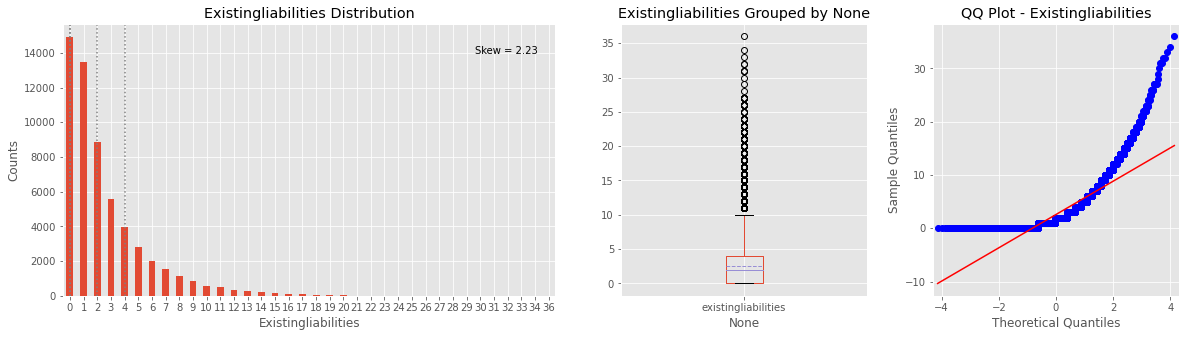

In [124]:
kde_target('existingliabilities', train)
numerical_plot('existingliabilities', train, discrete=True)

The correlation between existingliabilities_log and the TARGET is -0.1227
Median value for loan that is non-default = 1.0986
Median value for loan that defaulted =     0.6931


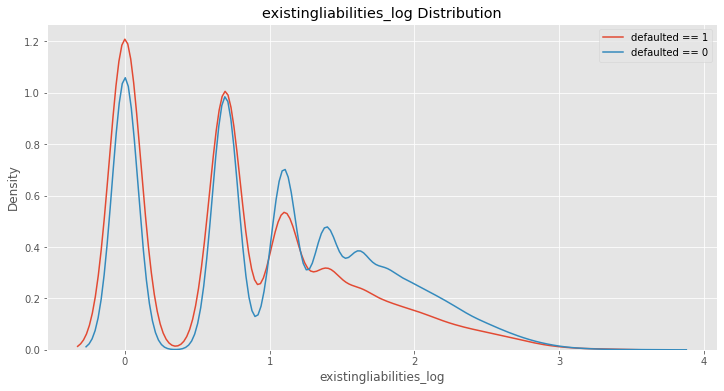

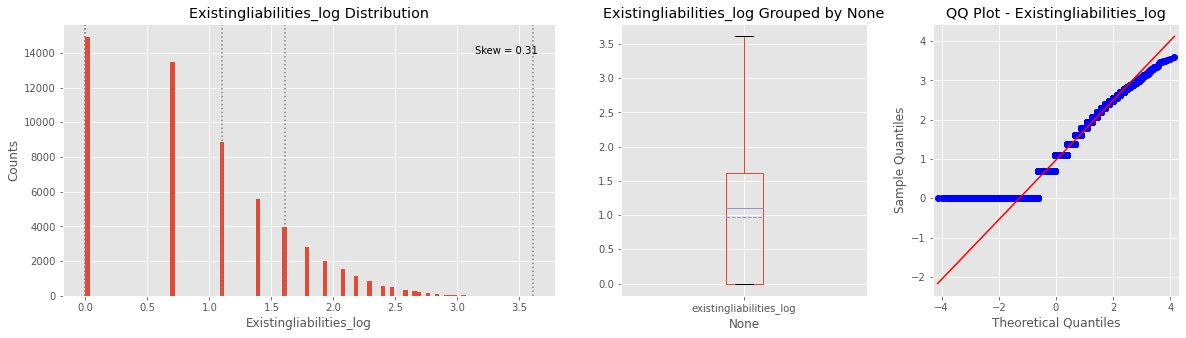

The correlation between existingliabilities_quantile and the TARGET is -0.1249
Median value for loan that is non-default = 0.5701
Median value for loan that defaulted =     0.3759


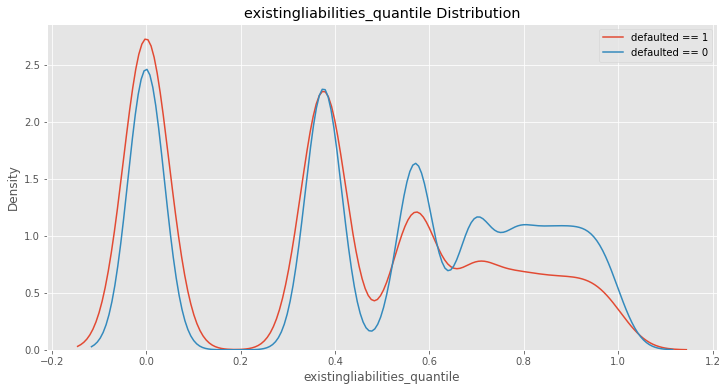

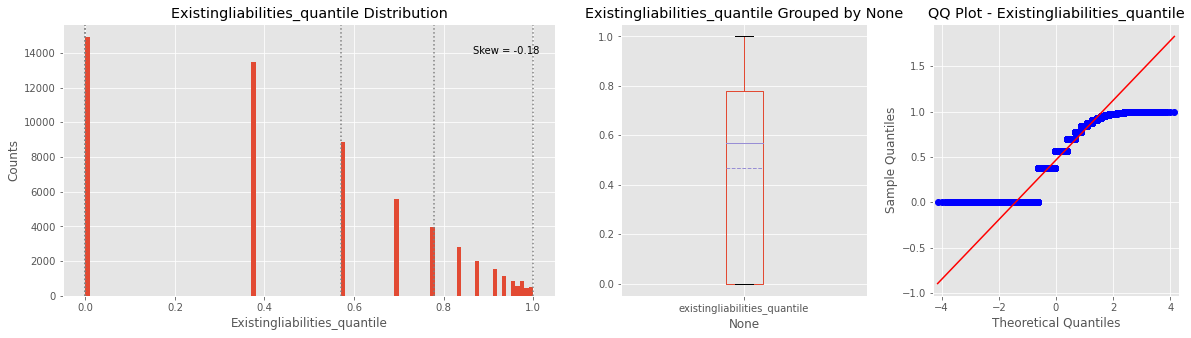

The correlation between existingliabilities_yeo and the TARGET is -0.1235
Median value for loan that is non-default = 0.2410
Median value for loan that defaulted =     -0.3076


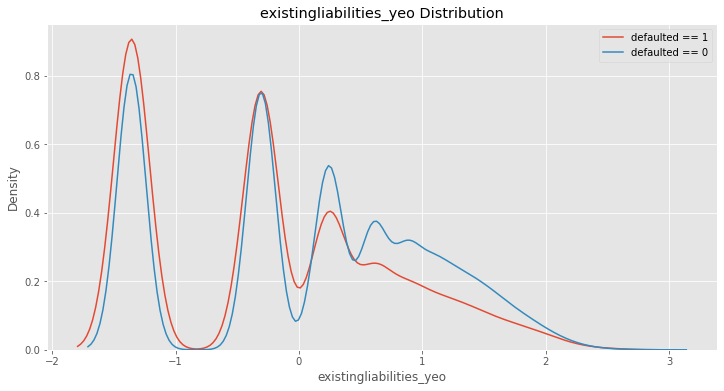

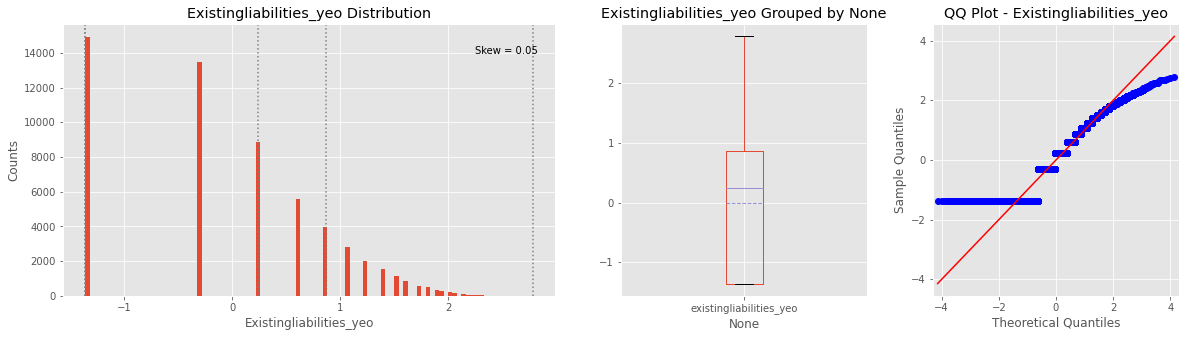

In [125]:
train = power_trans('existingliabilities', train)
for col in train.columns[train.columns.str.contains('\A(?:existingliabilities.*_)', regex=True)]:
    kde_target(col, train)
    numerical_plot(col, train)

In [126]:
check_bin('existingliabilities', train, max_bins=3)

2bin
-0.12237740888566516
Cramer's V = 0.12226602652649149
Pearson Chi-squared
probability = 0.950, critical = 3.841, stat = 861.643
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)
3bin
-0.12114364064758142
Cramer's V = 0.12305223950175406
Pearson Chi-squared
probability = 0.950, critical = 5.991, stat = 873.747
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


In [127]:
train, existingliabilities_edges = make_bins('existingliabilities', train, bins=3)

The correlation between existingliabilities_binned and the TARGET is -0.1211
Median value for loan that is non-default = 1.0000
Median value for loan that defaulted =     1.0000


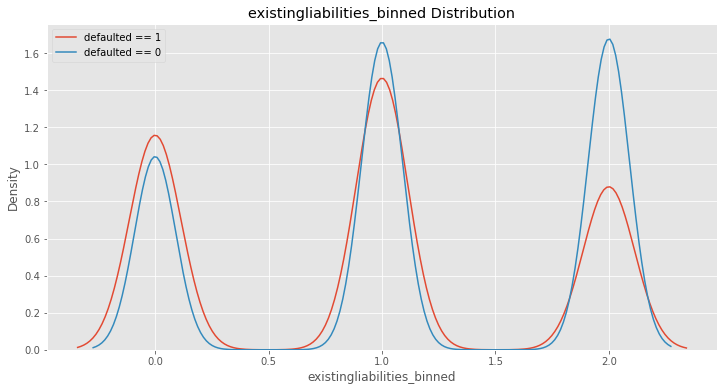

Cramer's V = 0.12305223950175406
Pearson Chi-squared
probability = 0.950, critical = 5.991, stat = 873.747
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


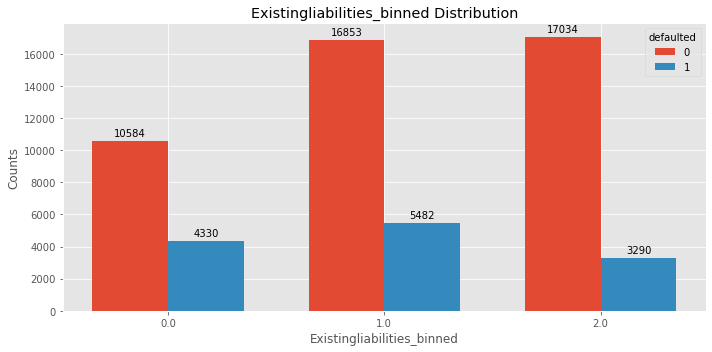

In [128]:
kde_target('existingliabilities_binned', train)
cat_plot('existingliabilities_binned', train)

### liabilitiestotal

The correlation between liabilitiestotal and the TARGET is 0.0072
Median value for loan that is non-default = 300.0000
Median value for loan that defaulted =     235.0000


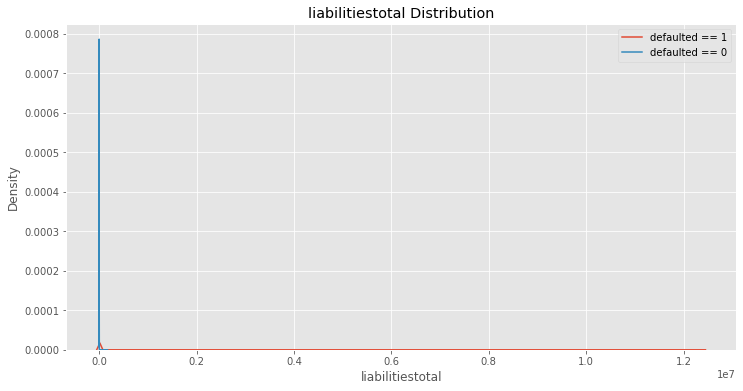

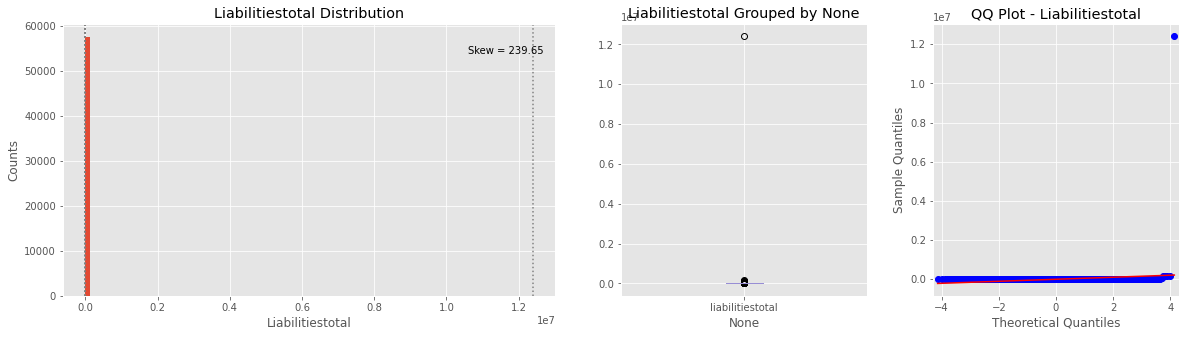

In [129]:
kde_target('liabilitiestotal', train)
numerical_plot('liabilitiestotal', train)

The correlation between liabilitiestotal_log and the TARGET is -0.0830
Median value for loan that is non-default = 5.7071
Median value for loan that defaulted =     5.4638


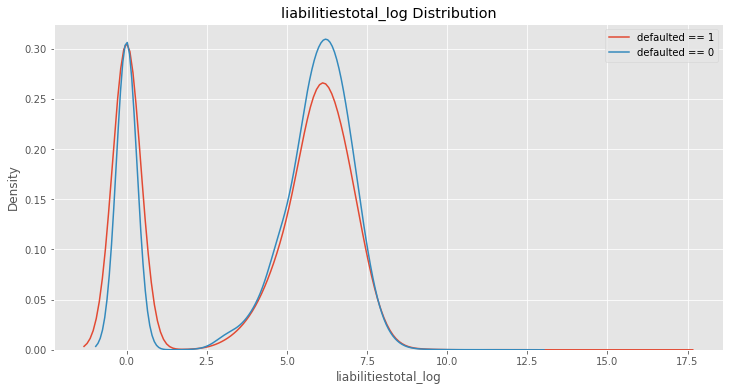

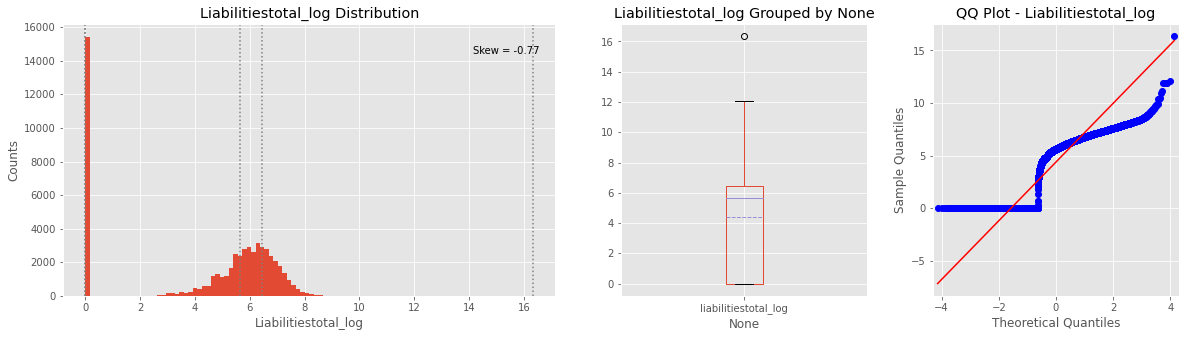

The correlation between liabilitiestotal_quantile and the TARGET is -0.0754
Median value for loan that is non-default = 0.5165
Median value for loan that defaulted =     0.4498


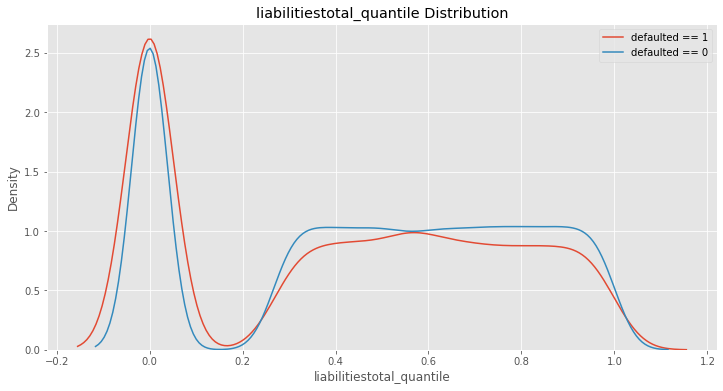

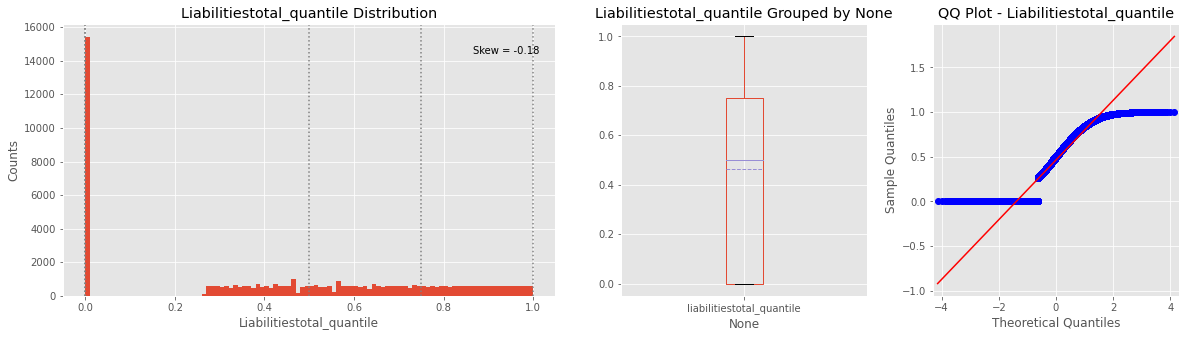

The correlation between liabilitiestotal_yeo and the TARGET is -0.0771
Median value for loan that is non-default = 0.3110
Median value for loan that defaulted =     0.1854


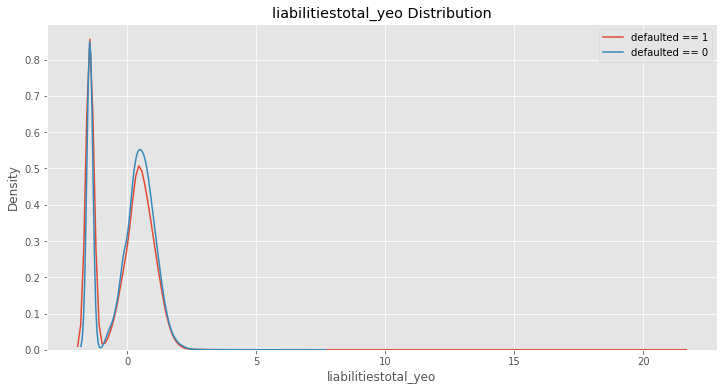

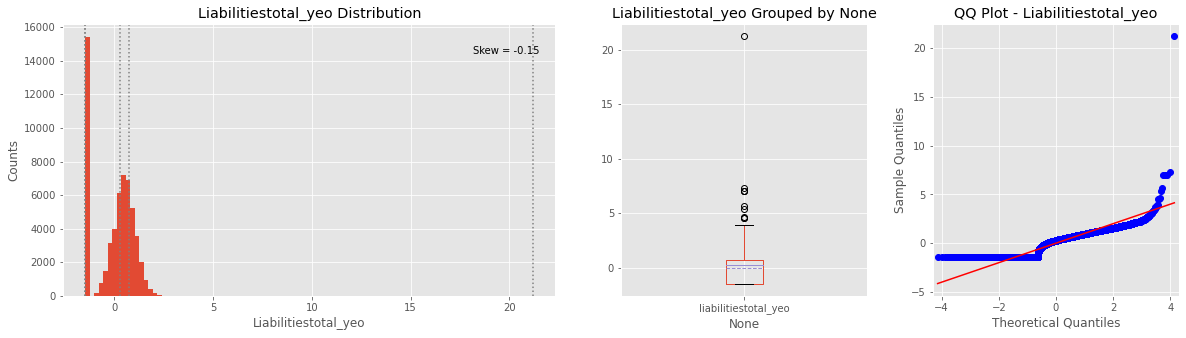

In [130]:
train = power_trans('liabilitiestotal', train)
for col in train.columns[train.columns.str.contains('\A(?:liabilitiestotal.*_)', regex=True)]:
    kde_target(col, train)
    numerical_plot(col, train)

The correlation between liabilitiestotal_binned and the TARGET is -0.0871
Median value for loan that is non-default = 1.0000
Median value for loan that defaulted =     1.0000


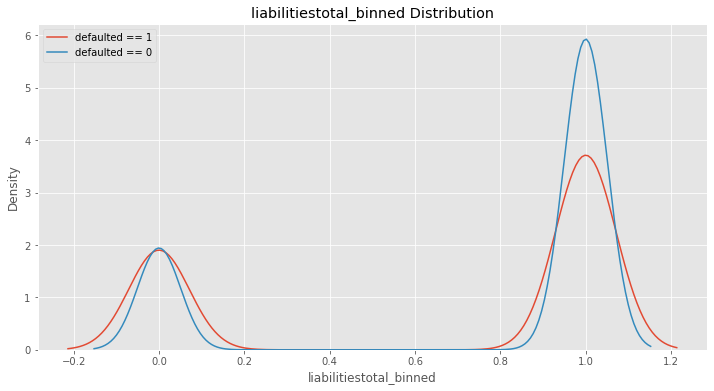

Cramer's V = 0.0869571972351699
Pearson Chi-squared
probability = 0.950, critical = 3.841, stat = 436.334
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


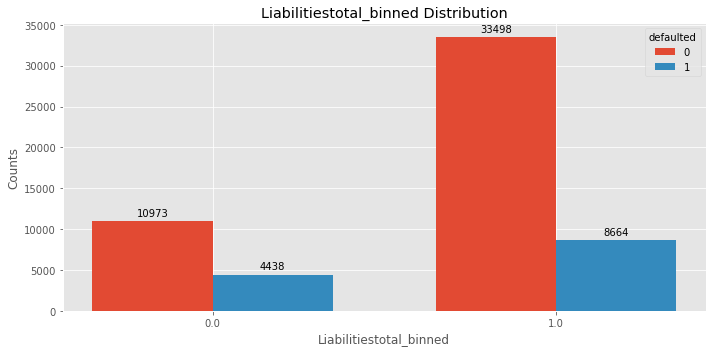

In [131]:
train = make_bins('liabilitiestotal', train, encode='binarize')
kde_target('liabilitiestotal_binned', train)
cat_plot('liabilitiestotal_binned', train)

### age

The correlation between age and the TARGET is -0.0256
Median value for loan that is non-default = 39.0000
Median value for loan that defaulted =     38.0000


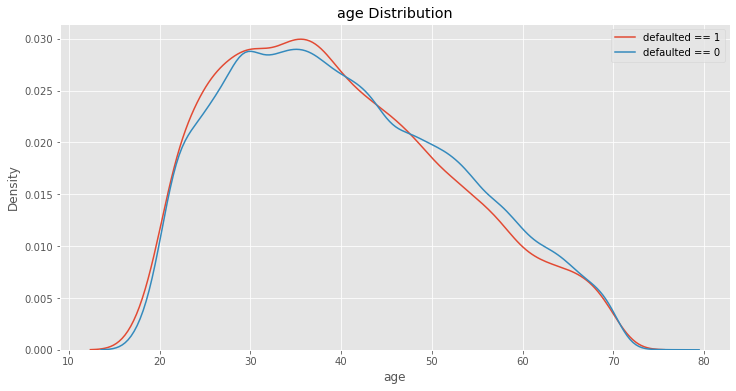

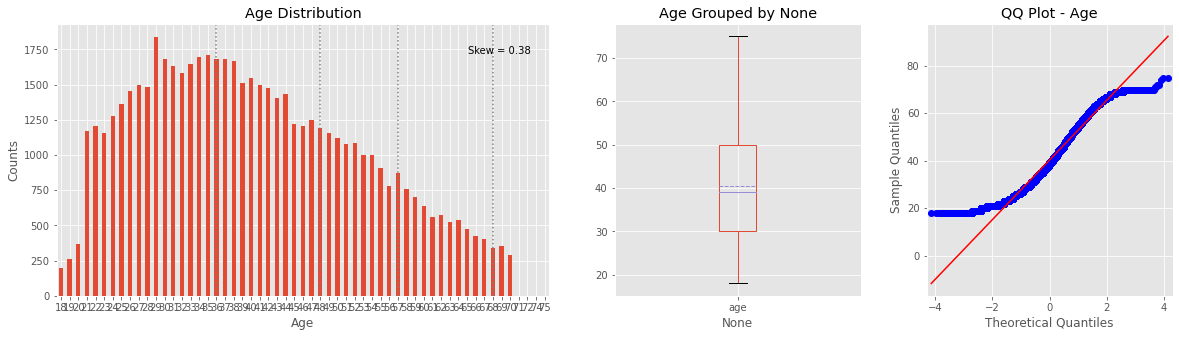

In [132]:
kde_target('age', train)
numerical_plot('age', train, discrete=True)

The correlation between age_log and the TARGET is -0.0257
Median value for loan that is non-default = 3.6889
Median value for loan that defaulted =     3.6636


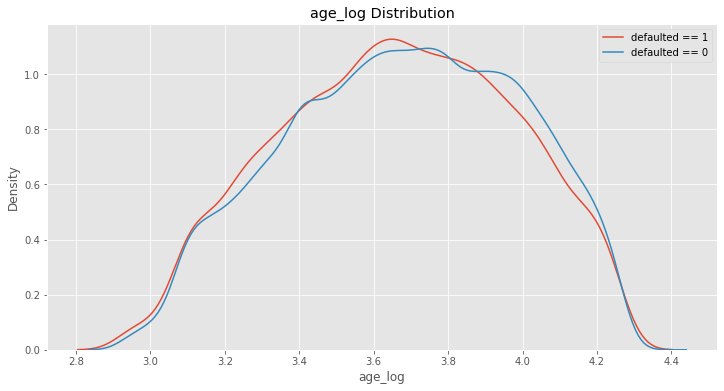

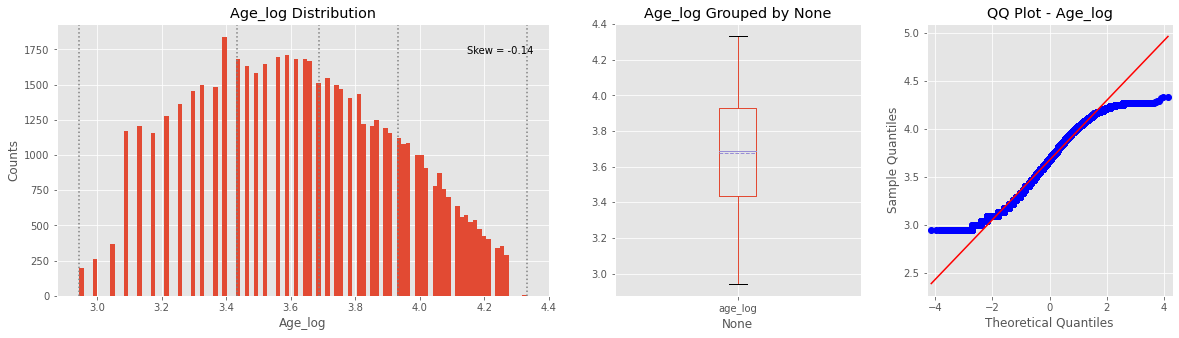

The correlation between age_quantile and the TARGET is -0.0256
Median value for loan that is non-default = 0.5040
Median value for loan that defaulted =     0.4765


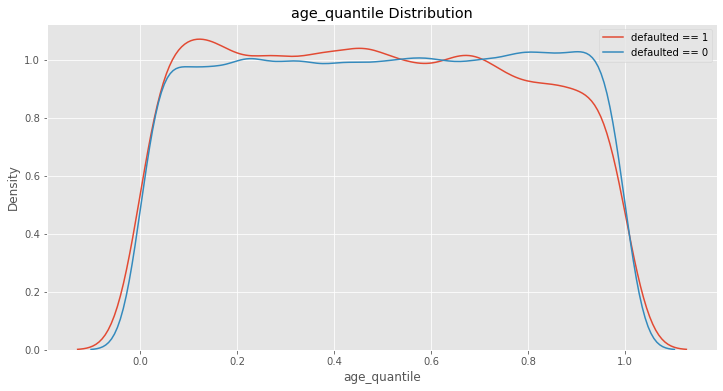

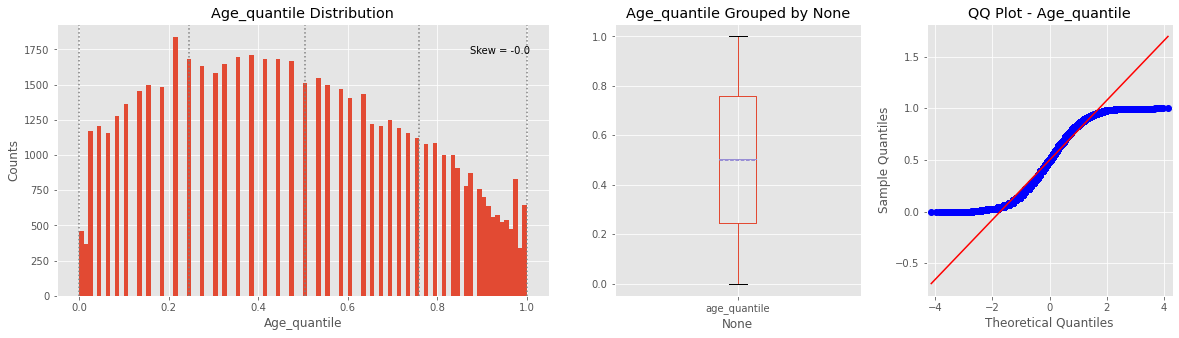

The correlation between age_yeo and the TARGET is -0.0257
Median value for loan that is non-default = 0.0095
Median value for loan that defaulted =     -0.0723


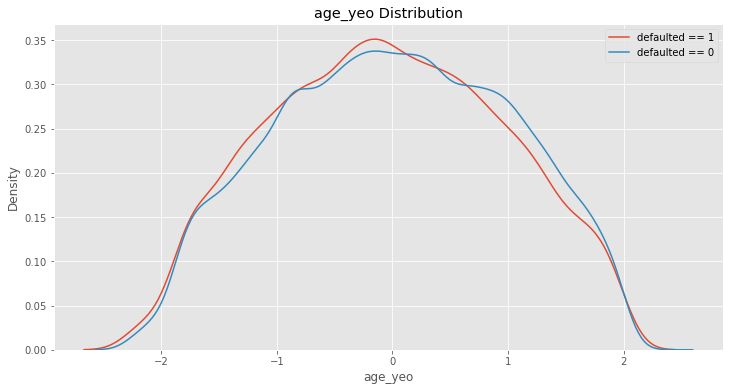

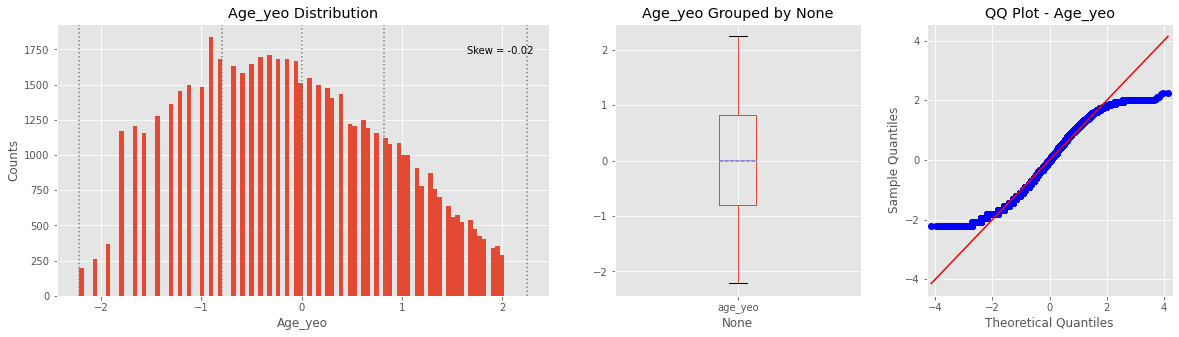

In [133]:
train = power_trans('age', train)
for col in train.columns[train.columns.str.contains('\A(?:age.*_)', regex=True)]:
    kde_target(col, train)
    numerical_plot(col, train)

The correlation between age_binned and the TARGET is -0.0235
Median value for loan that is non-default = 1.0000
Median value for loan that defaulted =     1.0000


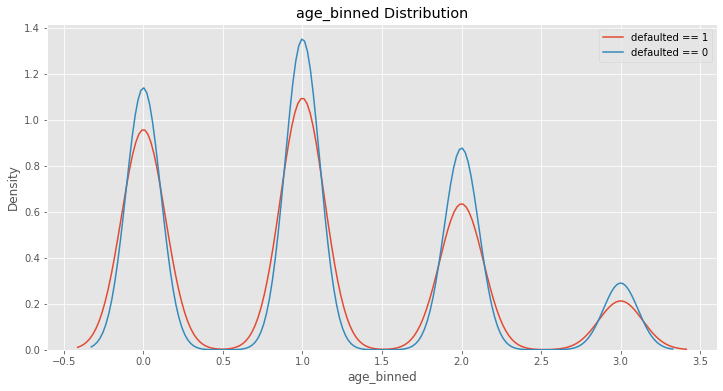

Cramer's V = 0.024180721091070174
Pearson Chi-squared
probability = 0.950, critical = 7.815, stat = 36.663
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


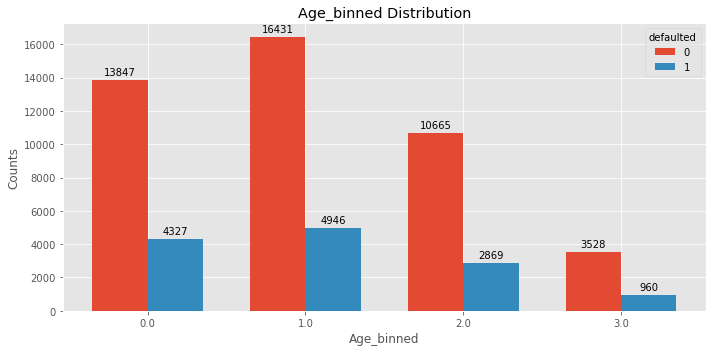

In [134]:
train, age_binned = make_bins('age', train, bins=4, strategy='uniform')
kde_target('age_binned', train)
cat_plot('age_binned', train)

In [135]:
len(train.columns)

82

In [136]:
train.columns.to_list()

['defaulted',
 'loanid',
 'username',
 'loanapplicationstarteddate',
 'languagecode',
 'age',
 'gender',
 'country',
 'appliedamount',
 'interest',
 'loanduration',
 'education',
 'maritalstatus',
 'nrofdependants',
 'employmentstatus',
 'employmentdurationcurrentemployer',
 'workexperience',
 'occupationarea',
 'homeownershiptype',
 'incometotal',
 'existingliabilities',
 'liabilitiestotal',
 'debttoincome',
 'noofearlierdefaults',
 'noofpreviousloansbeforeloan',
 'amountofpreviousloansbeforeloan',
 'priorrepayments',
 'previousearlyrepaymentsbeforeloan',
 'previousearlyrepaymentscountbeforeloan',
 'appliedamount_quantile',
 'appliedamount_log',
 'appliedamount_yeo',
 'test',
 'appliedamount_binned',
 'interest_log',
 'interest_quantile',
 'interest_yeo',
 'interest_binned',
 'loanduration_log',
 'loanduration_quantile',
 'loanduration_yeo',
 'loanduration_binned',
 'incometotal_log',
 'incometotal_quantile',
 'incometotal_yeo',
 'incometotal_binned',
 'noofpreviousloansbeforeloan_log

In [137]:
cat_cols = ['languagecode','gender', 'country', 'education',
       'maritalstatus', 'nrofdependants', 'employmentstatus',
       'employmentdurationcurrentemployer', 'workexperience', 'occupationarea',
       'homeownershiptype', 'appliedamount_binned', 'interest_binned', 'loanduration_binned', 'monthlypayment_binned',
           'incometotal_binned','noofpreviousloansbeforeloan_binned','amountofpreviousloansbeforeloan_binned','previousearlyrepaymentsbeforeloan_binned',
       'previousearlyrepaymentscountbeforeloan_binned','debttoincome_binned', 'existingliabilities_binned',
       'liabilitiestotal_binned', 'age_binned', 'priorrepayments_binned']

num_cols = ['age', 'appliedamount', 'interest', 'loanduration', 'monthlypayment',
       'incometotal', 'noofpreviousloansbeforeloan','amountofpreviousloansbeforeloan', 'priorrepayments',
       'noofearlierdefaults', 'previousearlyrepaymentsbeforeloan','previousearlyrepaymentscountbeforeloan', 'debttoincome',
       'existingliabilities', 'liabilitiestotal', 'monthlyinstallment','monthlyinstallmenttoincome', 'appliedamount_log', 'appliedamount_yeo',
       'appliedamount_box', 'appliedamount_quantile', 'test', 'interest_log','interest_quantile', 'interest_yeo', 'loanduration_log',
       'loanduration_quantile', 'loanduration_yeo', 'monthlypayment_log','monthlypayment_quantile', 'monthlypayment_yeo', 'incometotal_log',
       'incometotal_quantile', 'incometotal_yeo', 'monthlyinstallment_log','monthlyinstallment_quantile', 'monthlyinstallment_yeo',
       'monthlyinstallment_binned', 'monthlyinstallment_logtoincometotal_log','monthlyinstallment_logtoincometotal_quantile',
       'monthlyinstallment_logtoincometotal_yeo','monthlyinstallment_quantiletoincometotal_log',
       'monthlyinstallment_quantiletoincometotal_quantile','monthlyinstallment_quantiletoincometotal_yeo',
       'monthlyinstallment_yeotoincometotal_log','monthlyinstallment_yeotoincometotal_quantile',
       'monthlyinstallment_yeotoincometotal_yeo','noofpreviousloansbeforeloan_log','noofpreviousloansbeforeloan_quantile',
       'noofpreviousloansbeforeloan_yeo','amountofpreviousloansbeforeloan_log','amountofpreviousloansbeforeloan_quantile',
       'amountofpreviousloansbeforeloan_yeo', 'priorrepayments_log','priorrepayments_quantile', 'priorrepayments_yeo',
       'previousearlyrepaymentsbeforeloan_log','previousearlyrepaymentsbeforeloan_quantile','previousearlyrepaymentsbeforeloan_yeo',
       'previousearlyrepaymentscountbeforeloan_log','previousearlyrepaymentscountbeforeloan_quantile','previousearlyrepaymentscountbeforeloan_yeo', 'debttoincome_log',
       'debttoincome_quantile', 'debttoincome_yeo', 'existingliabilities_log','existingliabilities_quantile', 'existingliabilities_yeo',
       'liabilitiestotal_log', 'liabilitiestotal_quantile','liabilitiestotal_yeo', 'age_log', 'age_quantile', 'age_yeo']

In [138]:
 train.columns[~train.columns.isin(cat_cols+num_cols)]

Index(['defaulted', 'loanid', 'username', 'loanapplicationstarteddate'], dtype='object')

## cat_cols

### languagecode

The correlation between languagecode and the TARGET is 0.2908
Median value for loan that is non-default = 4.0000
Median value for loan that defaulted =     4.0000


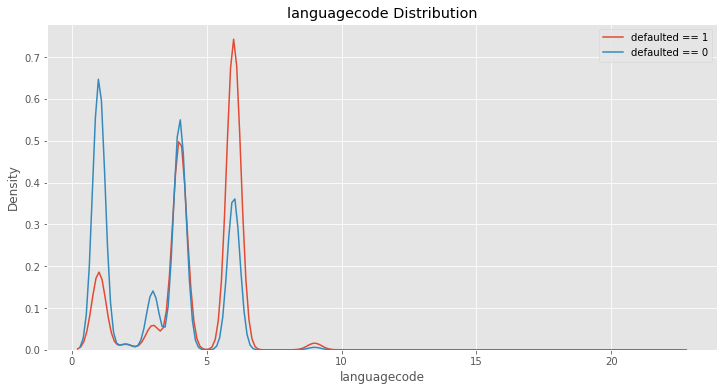

Cramer's V = 0.30043658535302875
Pearson Chi-squared
probability = 0.950, critical = 21.026, stat = 5208.572
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


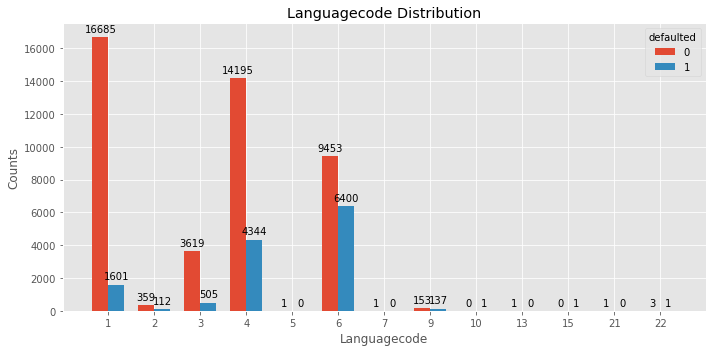

In [139]:
kde_target('languagecode', train)
cat_plot('languagecode', train)

There are undefined values in the variable. They will be consolidated.

In [140]:
# consolidate non-defined values into another class. 99.
train.loc[train['languagecode'].isin([7, 10, 13, 15, 21, 22]), 'languagecode'] = 99

The correlation between languagecode and the TARGET is 0.2520
Median value for loan that is non-default = 4.0000
Median value for loan that defaulted =     4.0000


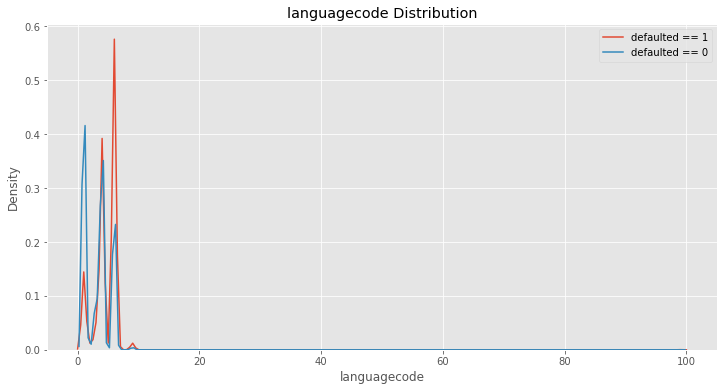

Cramer's V = 0.30037555737434585
Pearson Chi-squared
probability = 0.950, critical = 14.067, stat = 5201.461
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


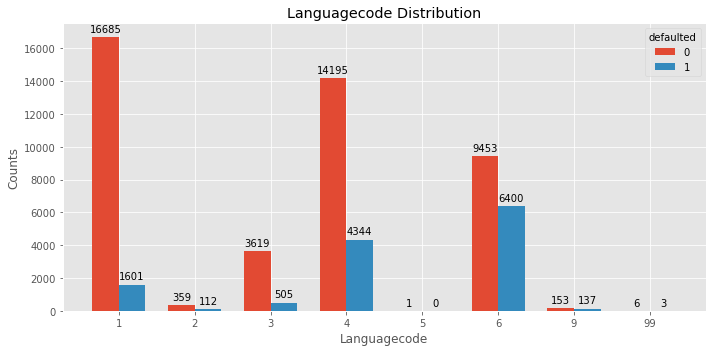

In [141]:
kde_target('languagecode', train)
cat_plot('languagecode', train)

[array([ 1,  3,  4,  6, 99], dtype=int64)]
The correlation between languagecode and the TARGET is 0.2868
Median value for loan that is non-default = 2.0000
Median value for loan that defaulted =     3.0000


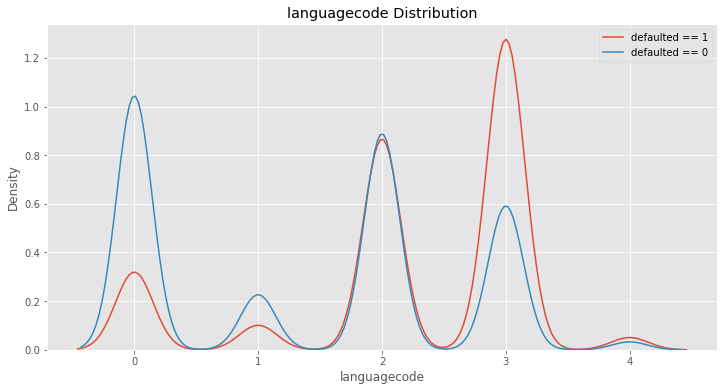

Cramer's V = 0.29881546572462675
Pearson Chi-squared
probability = 0.950, critical = 9.488, stat = 5144.643
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


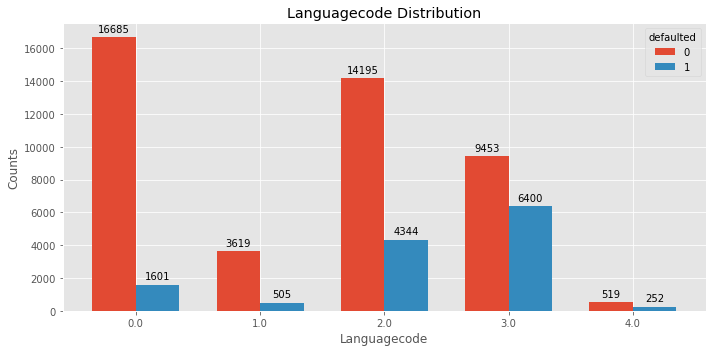

In [142]:
# check if should consolidate low occurence classes
test = train.copy()
x = np.sort(test['languagecode'].unique())[test['languagecode'].value_counts(normalize=True).sort_index() > 0.05]

test.loc[~test['languagecode'].isin(x), 'languagecode'] = 99

encoder = OrdinalEncoder()

test['languagecode'] = encoder.fit_transform(test[['languagecode']])

print(encoder.categories_)

kde_target('languagecode', test)
cat_plot('languagecode', test)

Doesn't seem so. Leave as such.

In [143]:
# onehot encode, drop_first
train = pd.get_dummies(data=train, columns=['languagecode'], drop_first=True)

In [144]:
# onehot encode
# x = np.sort(train['languagecode'].unique())[train['languagecode'].value_counts(normalize=True).sort_index() > 0.05]

# df.loc[~df['languagecode'].isin(x), 'languagecode'] = 99

# df = pd.get_dummies(data=df, columns=['languagecode'])

### Gender

The correlation between gender and the TARGET is 0.0320
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


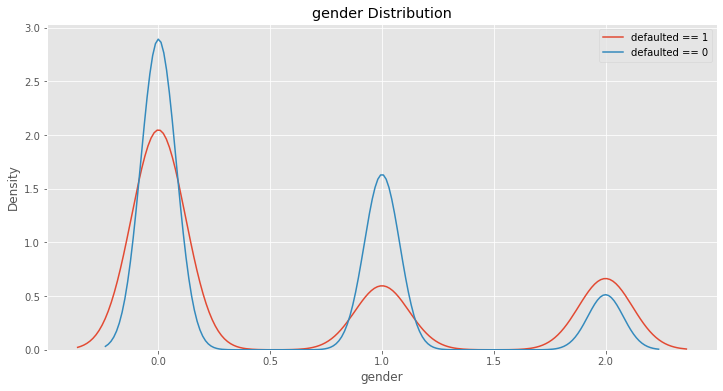

Cramer's V = 0.16396044915479913
Pearson Chi-squared
probability = 0.950, critical = 5.991, stat = 1549.710
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


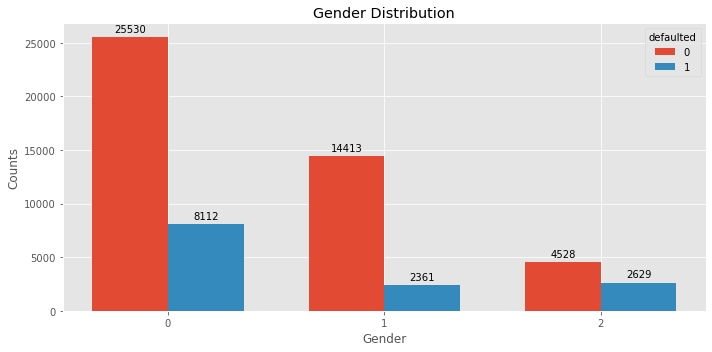

In [145]:
kde_target('gender', train)
cat_plot('gender', train)

In [146]:
# check if should consolidate classes
def check_consolidate_class(var, df, threshold = 0.05, consolidate_to=99):
    
    df = df.copy()
    
    x = np.sort(df[var].unique())[df[var].value_counts(normalize=True).sort_index() < threshold]

    df.loc[df[var].isin(x), var] = consolidate_to

    encoder = OrdinalEncoder()

    df[var] = encoder.fit_transform(df[[var]])

    print(f'class - {encoder.categories_[0]}')

    kde_target(var, df)
    cat_plot(var, df)

class - [0 1 2]
The correlation between gender and the TARGET is 0.0320
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


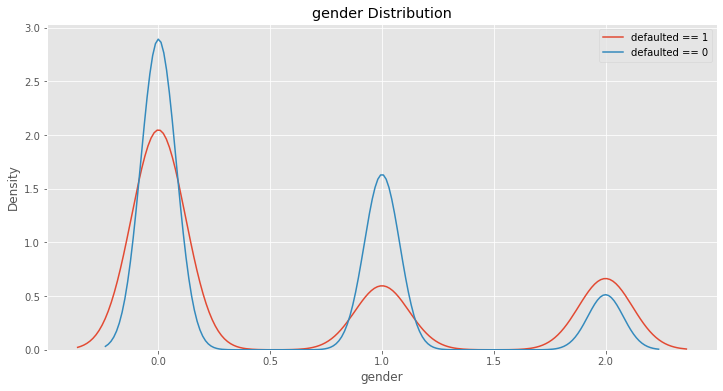

Cramer's V = 0.16396044915479913
Pearson Chi-squared
probability = 0.950, critical = 5.991, stat = 1549.710
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


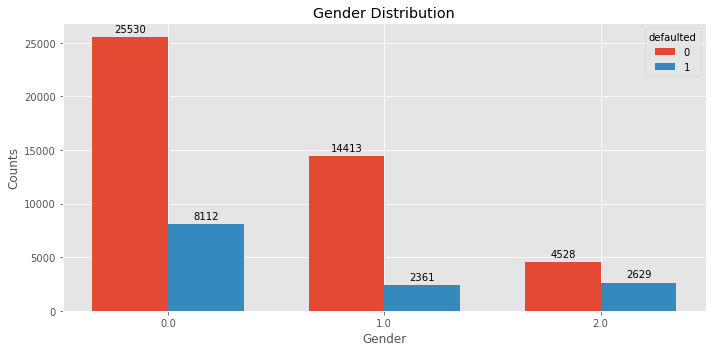

In [147]:
check_consolidate_class('gender', train)

In [148]:
train = pd.get_dummies(data=train, columns=['gender'])

### country

Cramer's V = 0.3013552942481071
Pearson Chi-squared
probability = 0.950, critical = 7.815, stat = 5231.402
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


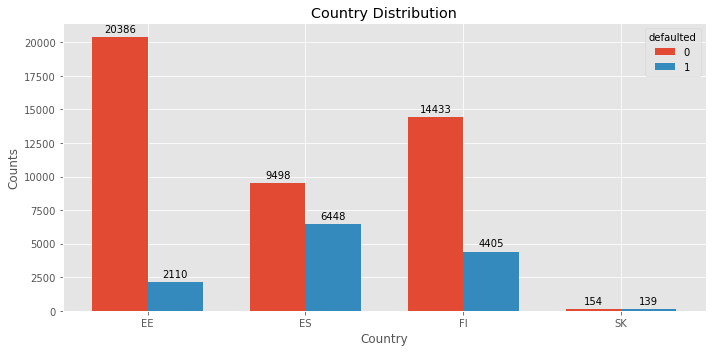

In [149]:
cat_plot('country', train)

In [150]:
train = pd.get_dummies(data=train, columns=['country'])

In [153]:
# check if should consolidate classes
def consolidate_class(var, df, threshold = 0.05, consolidate_to=99, encode='onehot', return_cat=False):
    
    df = df.copy()
    
    x = np.sort(df[var].unique())[df[var].value_counts(normalize=True).sort_index() < threshold]

    df.loc[df[var].isin(x), var] = consolidate_to

    if encode=='onehot':
    
        df = pd.get_dummies(data=df, columns=[var])
        
        return df
    
    elif encode=='ordinal':
    
        encoder = OrdinalEncoder()

        df[var] = encoder.fit_transform(df[[var]])
        
        if return_cat:

            return df, encoder.categories_[0]
        
        return df


### education

The correlation between education and the TARGET is -0.0061
Median value for loan that is non-default = 4.0000
Median value for loan that defaulted =     4.0000


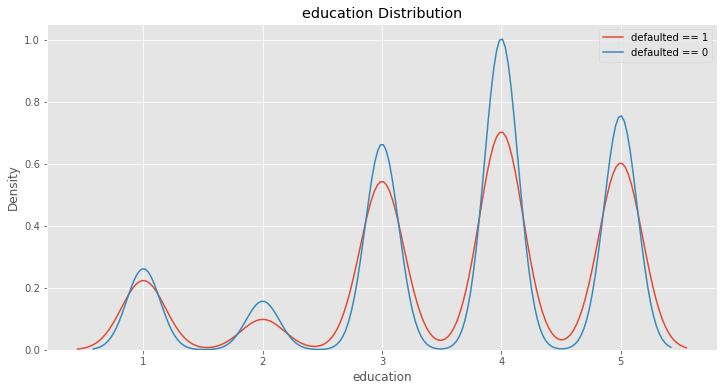

Cramer's V = 0.03499814097924325
Pearson Chi-squared
probability = 0.950, critical = 9.488, stat = 74.518
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


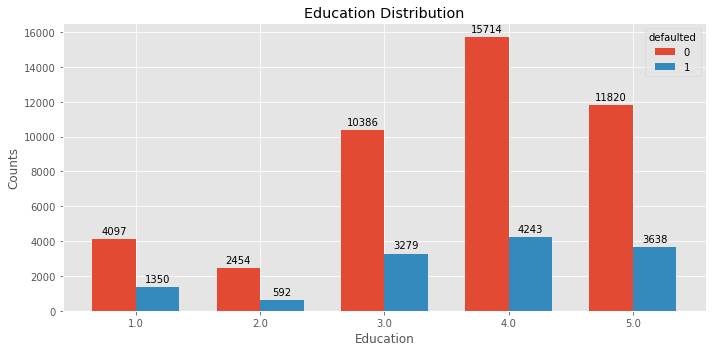

In [155]:
kde_target('education', train)
cat_plot('education', train)

### maritalstatus

The correlation between maritalstatus and the TARGET is -0.0531
Median value for loan that is non-default = -1.0000
Median value for loan that defaulted =     -1.0000


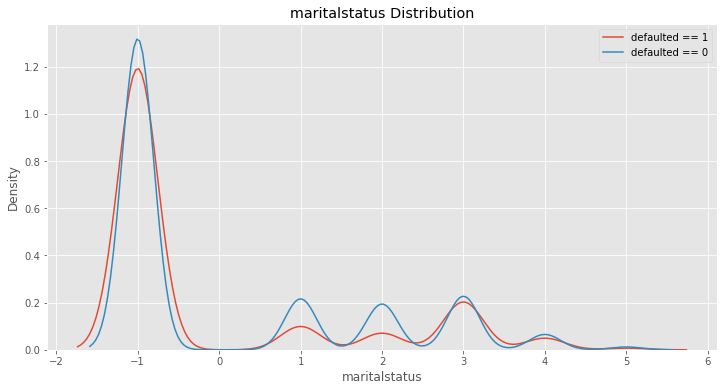

Cramer's V = 0.10834080479319722
Pearson Chi-squared
probability = 0.950, critical = 11.070, stat = 680.765
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


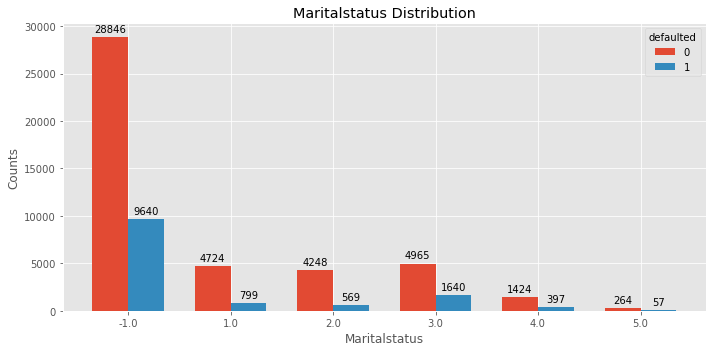

In [156]:
kde_target('maritalstatus', train)
cat_plot('maritalstatus', train)

class - [-1  1  2  3 99]
The correlation between maritalstatus and the TARGET is -0.0103
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


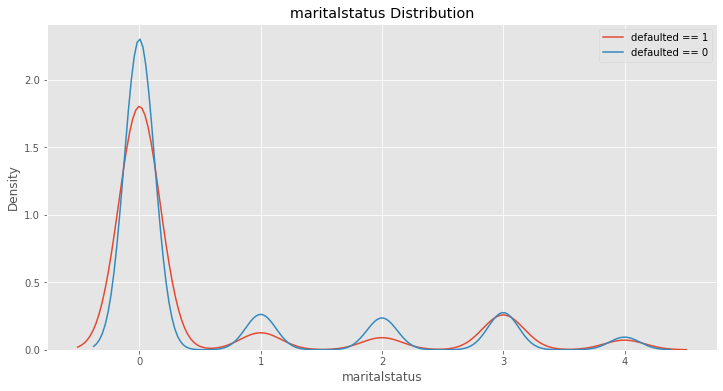

Cramer's V = 0.07953256722914981
Pearson Chi-squared
probability = 0.950, critical = 9.488, stat = 459.229
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


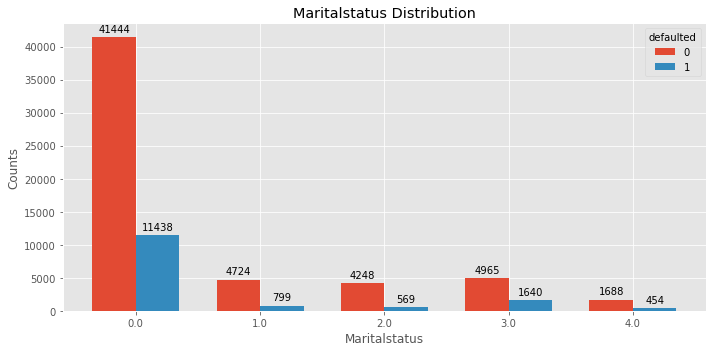

In [157]:
check_consolidate_class('maritalstatus', df,threshold=0.05)

In [158]:
train = pd.get_dummies(data=train, columns=['maritalstatus'])

### nrofdependants

Cramer's V = 0.09059751843841232
Pearson Chi-squared
probability = 0.950, critical = 18.307, stat = 482.546
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


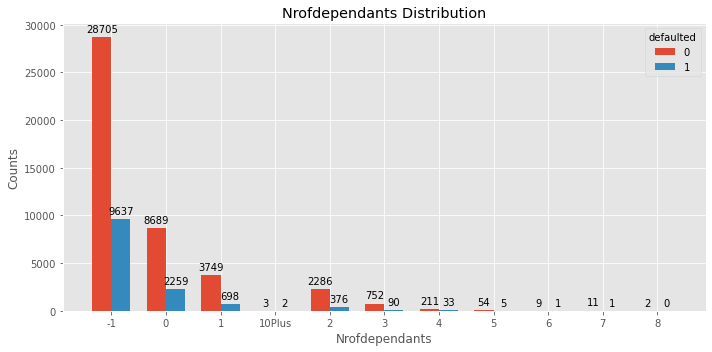

In [159]:
cat_plot('nrofdependants', train)

In [160]:
train['nrofdependants'].value_counts(normalize=True) > 0.03

-1         True
0          True
1          True
2          True
3         False
4         False
5         False
7         False
6         False
10Plus    False
8         False
Name: nrofdependants, dtype: bool

Cramer's V = 0.07806125987614501
Pearson Chi-squared
probability = 0.950, critical = 7.815, stat = 353.819
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


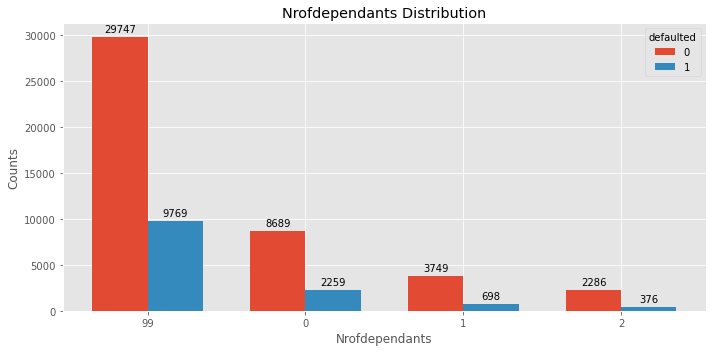

In [161]:
test = train.copy()
test.loc[~test['nrofdependants'].isin(['-1','0', '1', '2']), 'nrofdependants'] = 99
cat_plot('nrofdependants', test)

In [162]:
train['nrofdependants'] = train['nrofdependants'].astype(str)

In [163]:
train, nrofdependants_cat = consolidate_class('nrofdependants', train, threshold=0.03, consolidate_to='3+', encode='ordinal', return_cat=True)

In [164]:
nrofdependants_cat

array(['-1', '0', '1', '2', '3+'], dtype=object)

### employmentstatus

Cramer's V = 0.08525173711253442
Pearson Chi-squared
probability = 0.950, critical = 12.592, stat = 424.425
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


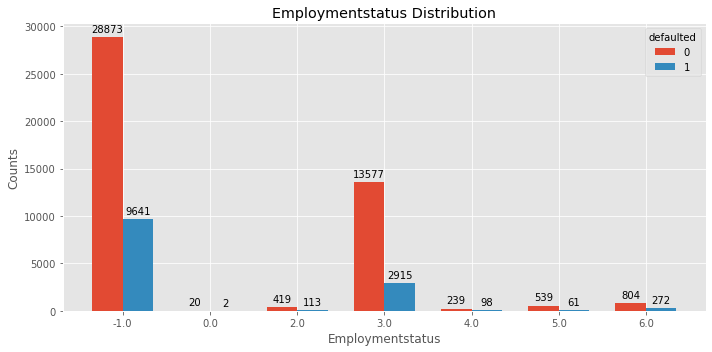

In [165]:
cat_plot('employmentstatus', train)

In [166]:
# for undefined value, we will consolidate to unspecified value, i.e. -1

Cramer's V = 0.08502949344316063
Pearson Chi-squared
probability = 0.950, critical = 11.070, stat = 421.246
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


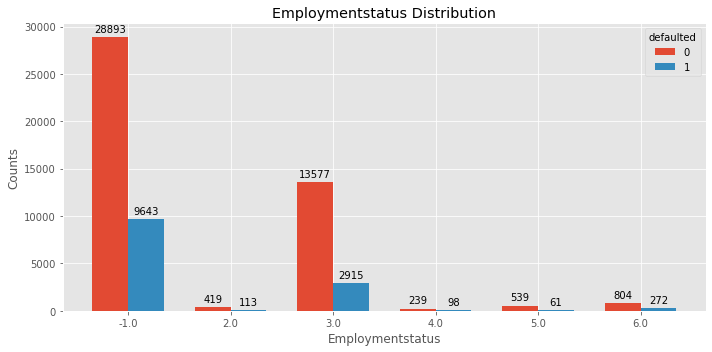

In [167]:
train.loc[train['employmentstatus']==0, 'employmentstatus'] = -1
cat_plot('employmentstatus', train)

In [168]:
# one hot encode
train = consolidate_class('employmentstatus', train, threshold=0)

### employmentdurationcurrentemployer

Cramer's V = 0.04152180280885828
Pearson Chi-squared
probability = 0.950, critical = 15.507, stat = 107.258
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


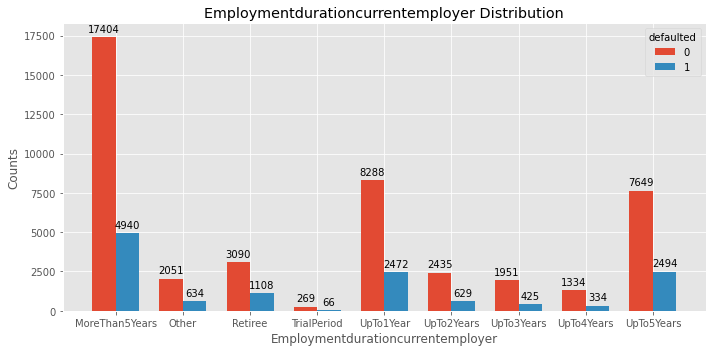

In [169]:
cat_plot('employmentdurationcurrentemployer', train)

class - ['MoreThan5Years' 'Other' 'Retiree' 'UpTo1Year' 'UpTo2Years' 'UpTo3Years'
 'UpTo4Years' 'UpTo5Years']
The correlation between employmentdurationcurrentemployer and the TARGET is 0.0089
Median value for loan that is non-default = 2.0000
Median value for loan that defaulted =     2.0000


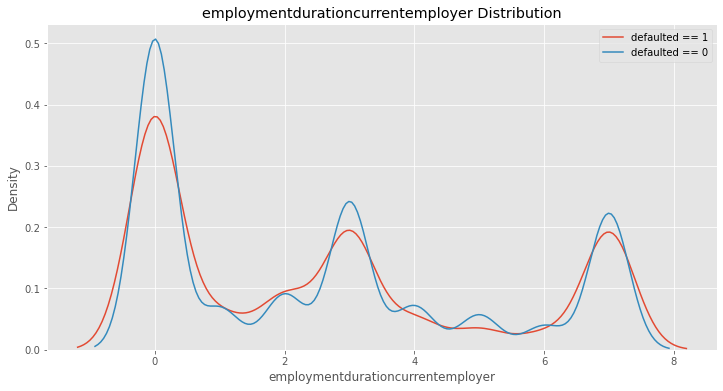

Cramer's V = 0.04118749509314094
Pearson Chi-squared
probability = 0.950, critical = 14.067, stat = 104.666
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


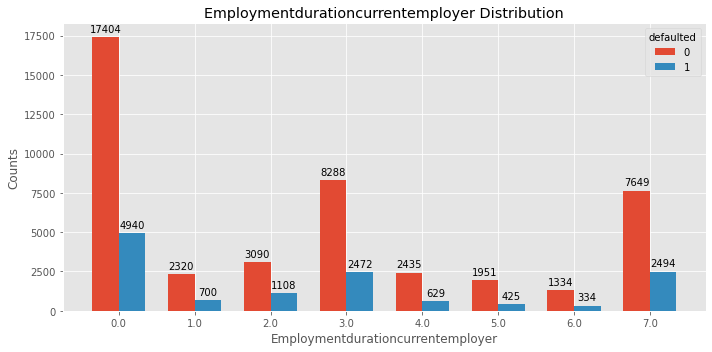

In [170]:
# check if should consolidate
check_consolidate_class('employmentdurationcurrentemployer', train, threshold=0.01, consolidate_to='Other')

Probably not a good idea to consolidate

In [171]:
train['employmentdurationcurrentemployer'].unique()

array(['UpTo4Years', 'MoreThan5Years', 'UpTo3Years', 'UpTo2Years',
       'UpTo1Year', 'UpTo5Years', 'TrialPeriod', 'Retiree', 'Other'],
      dtype=object)

In [172]:
employmentdurationcurrentemployer_cat = [['Retiree', 'Other', 'TrialPeriod', 'UpTo1Year', 'UpTo2Years',  'UpTo3Years', 'UpTo4Years', 'UpTo5Years', 'MoreThan5Years']]
encoder = OrdinalEncoder(categories=employmentdurationcurrentemployer_cat)

In [173]:
train['employmentdurationcurrentemployer'] = encoder.fit_transform(train[['employmentdurationcurrentemployer']])

### workexperience

Cramer's V = 0.08225632566036309
Pearson Chi-squared
probability = 0.950, critical = 12.592, stat = 395.538
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


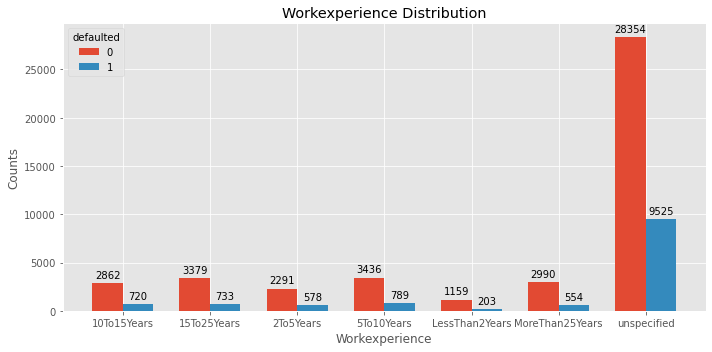

In [174]:
cat_plot('workexperience', train)

In [175]:
train['workexperience'].unique()

array(['15To25Years', '5To10Years', '10To15Years', '2To5Years',
       'MoreThan25Years', 'LessThan2Years', 'unspecified'], dtype=object)

In [176]:
workexperience_cat = [['unspecified', 'LessThan2Years', '2To5Years', '5To10Years',  '10To15Years', '15To25Years', 'MoreThan25Years']]
encoder = OrdinalEncoder(categories=workexperience_cat)
train['workexperience'] = encoder.fit_transform(train[['workexperience']])

The correlation between workexperience and the TARGET is -0.0750
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


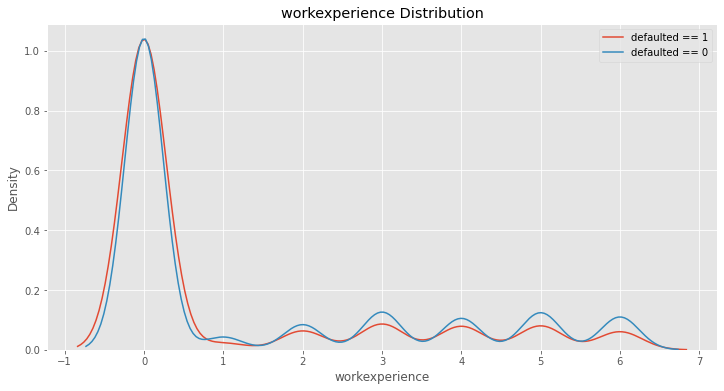

Cramer's V = 0.08225632566036309
Pearson Chi-squared
probability = 0.950, critical = 12.592, stat = 395.538
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


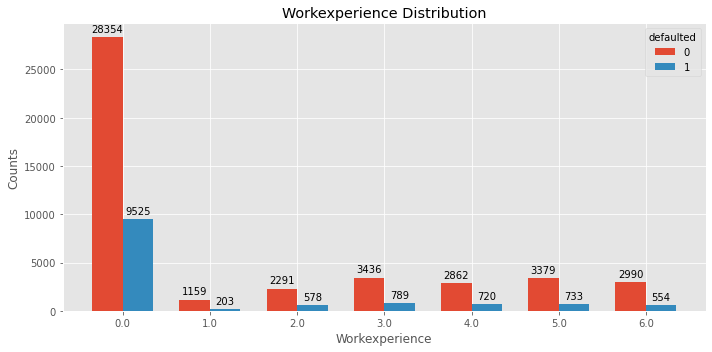

In [177]:
kde_target('workexperience', train)
cat_plot('workexperience', train)

### occupationarea

Cramer's V = 0.0960859858593822
Pearson Chi-squared
probability = 0.950, critical = 30.144, stat = 550.535
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


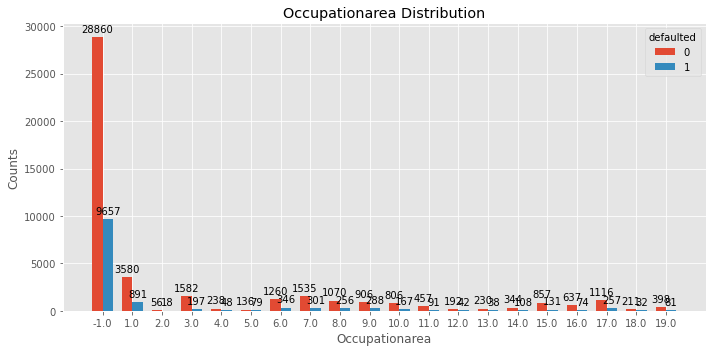

In [178]:
cat_plot('occupationarea', train)

In [179]:
# onehot encoder
train = consolidate_class('occupationarea', train, threshold=0)

### homeownershiptype

Cramer's V = 0.1175464109713882
Pearson Chi-squared
probability = 0.950, critical = 18.307, stat = 805.482
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


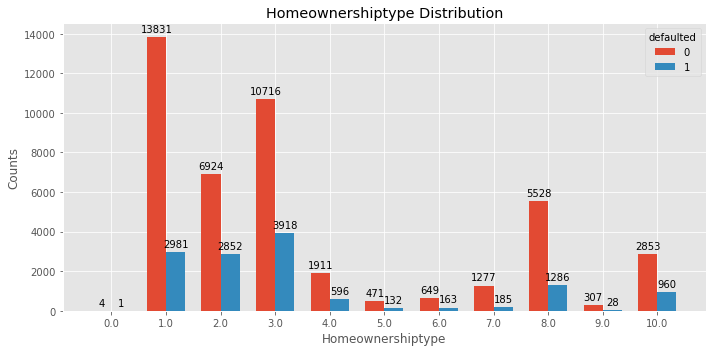

In [180]:
cat_plot('homeownershiptype', train)

In [181]:
# onehot encode
train = pd.get_dummies(data=train, columns=['homeownershiptype'])

In [183]:
todrop = ['defaulted', 'loanid', 'username', 'loanapplicationstarteddate', 'test']
X_t, y_t = train.drop(columns=todrop), train['defaulted']

# Collinearity

To check on collinearity between the variables

In [186]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [187]:
zz = X_t.assign(const=1).copy()
rr = pd.Series([variance_inflation_factor(zz.values, i) for i in range(zz.shape[1])], index=zz.columns)

C:\Users\marti\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\marti\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [188]:
pd.set_option('display.max_rows', None)
rr.sort_index()

age                                                1.813391e+06
age_binned                                         1.439467e+01
age_log                                            2.232427e+07
age_quantile                                       4.603529e+04
age_yeo                                            3.934637e+07
amountofpreviousloansbeforeloan                    5.854254e+01
amountofpreviousloansbeforeloan_binned                      inf
amountofpreviousloansbeforeloan_log                2.573285e+04
amountofpreviousloansbeforeloan_quantile           6.658297e+03
amountofpreviousloansbeforeloan_yeo                5.586973e+05
appliedamount                                      2.380577e+02
appliedamount_binned                               9.828325e+01
appliedamount_log                                  4.701835e+03
appliedamount_quantile                             1.694766e+02
appliedamount_yeo                                  7.746814e+03
const                                   

We may need to consider removing highly collinear variables. We will also consider the cramers' v coefficient and pearson's correlation to decide which to drop.

# Preprocessing

Lets create a pipeline to process X_train into a similar form as X_t. Doing all the necessary processing in a pipeline allows for a more thorough machine learning pipeline process and also prevents data leakage.

## Load Dependencies

In [831]:
# import pandas as pd
# import numpy as np

# from sklearn.pipeline import Pipeline, make_pipeline
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.utils.validation import check_is_fitted
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, Binarizer, OneHotEncoder, QuantileTransformer, PowerTransformer , FunctionTransformer

# from sklearn_pandas import DataFrameMapper, gen_features, NumericalTransformer

## Load Functions

In [205]:
def load_and_split(url):
    '''
    Returns X_train, y_train, X_test, y_test

    '''
    
    # Load dataset
    df = pd.read_csv(url, dtype={'NrOfDependants': str})
    # convert column names to lowercase
    df.columns = df.columns.str.lower()
    # convert date column to datetime
    df['loanapplicationstarteddate'] = pd.to_datetime(df['loanapplicationstarteddate'], format='%Y-%m-%d %H:%M:%S')
    # drop unused columns, variables
    drop_cols = ['interest', 'noofearlierdefaults']
    
    df = df.drop(columns=drop_cols)
    # sort df according to date
    df = df.sort_values(by='loanapplicationstarteddate', ignore_index=True)

    # Test-train split
    train, test = np.split(df, [int(0.8 *len(df))])

    # x-y split
    X_train, y_train = train.loc[:, ~train.columns.isin(['defaulted'])].copy(), train['defaulted'].copy()
    X_test, y_test = test.loc[:, ~test.columns.isin(['defaulted'])].copy(), test['defaulted'].copy()
    
    return X_train, y_train, X_test, y_test
    
    
def prepare_db(num_var, cat_var, dtype_dict):
    '''
    Returns db, the database dataframe
    
    '''
    
    # load database
    db = pd.read_csv("../../Data/Processed/Database.csv", dtype={'nrofdependants': str})
    db.columns = db.columns.str.lower()
    db['loanapplicationstarteddate'] = pd.to_datetime(db['loanapplicationstarteddate'], format='%Y-%m-%d %H:%M:%S')
    db['defaultdate'] = pd.to_datetime(db['defaultdate'], format='%Y-%m-%d')
    db['loandate'] = pd.to_datetime(db['loandate'], format='%Y-%m-%d')
    
    # cast db data type
    db = dtype_cast(db, num_var, cat_var, dtype_dict)
    
    return db



def dtype_cast(df, num_var=None, cat_var=None, dtype_dict=None):
    '''
    Utility function to cast the appropriate data types to the variables.
    
    Returns the dataframe with the data types casted.
    
    '''
    
    df = df.copy()
    
    if num_var is None:
        
        df = df.astype(float)
    
    else:
        
        # cast numerical var to float
        df[num_var] = df[num_var].astype(float)
    
    if (cat_var is not None) & (dtype_dict is not None):
    
        for cat in cat_var:
            df[cat] = df[cat].astype(dtype_dict[cat+'_dtype'])

    return df


def custom_impute(df):
    '''
    Utility function to impute missing values in previousearlyrepaymentsbeforeloan according to specific condition.
    
    Returns dataframe with values imputed.
    
    '''

    df = df.copy()
    df.loc[(df['previousearlyrepaymentsbeforeloan'].isna() & (df['previousearlyrepaymentscountbeforeloan']==0)), 'previousearlyrepaymentsbeforeloan'] = 0

    return df
    

def fill_na(data, database, variables:list=None):
    '''
    A function that gets the latest non-nan values from a database and fills in the nan values in the data dataframe.
    
    By default, the function will fill search and fill all variable columns that have nan values, unless specified in the variables list.
    
    '''
    data = data.copy()
    database = database.copy()
    
    data_group_key = 'username'
    data_merge_col = 'loanid'
    
    
    database_group_key = data_group_key
    database_merge_col = data_merge_col
    database_date_col = 'loanapplicationstarteddate'
    
    if variables == None:
        variables  = data.columns[data.isna().sum()!=0]
    
        
    # get corresponding loans belonging to these usernames from database
    database_miss = database.loc[database[database_group_key].isin(set(data[data_group_key]))].copy()
    
    # sort these loans according to username and date
    database_miss = database_miss.sort_values([database_group_key, database_date_col])
    # implement a little trick here, we will use the fillna(method='ffill') method followed by pd.merge according to the loanid
    # to simulate the querying of database for ast records to impute, which is what we see in actual operation. 
    # For the test dataset, they will also have a view of the database

    # for each username group, find earlier non-nan values to impute nan values, i.e. fillna(method='ffill')
    for var in variables:
        database_miss[var] = database_miss.groupby(database_group_key)[var].ffill()
    

    # use pd.merge between data and db_df_miss on the loanid to simulate the querying
    data = pd.merge(data.reset_index(), database_miss[[database_merge_col, *variables]], how='left', left_on=data_merge_col, right_on=database_merge_col).set_index('index')
    
    for var in variables:
        data[var+'_x'] = data[var+'_y'].copy()
        data.drop(columns=[var+'_y'], inplace=True)
        data.rename(columns={var+'_x':var}, inplace=True)
    
    return data



class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters
    ----------    
    group_cols : list
        List of columns used for calculating the aggregated value 
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self, group_cols, target, metric='mean'):
        
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'
        
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
        
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric) \
                                                            .reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        
        return self 
    
    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(row[self.target])
            
        return X

class variancethreshold(BaseEstimator, TransformerMixin):
    '''
    Class used for selecting columns from a pandas dataframe which have value variances above a threshold value.
    
    Parameters
    ----------    
    cols : list , default=None
        List of columns which will be tested for the variance threshold. Columns not in list will be
        passed untested.
        When default, all columns in the dataframe will be tested.
    threshold : float
        The threshold variance value below which the columns will be dropped.
        
    Returns
    -------
    x : Pandas datframe-like
        The dataframe with the columns having variances smaller than the threshold value dropped.
    '''

    def __init__(self, cols=None, threshold=0.0):
        
        assert type(cols) == list or cols is None, 'cols should be a list of columns or set to None'
        assert type(threshold) == float, 'threshold should be a float'
        
        from sklearn.feature_selection import VarianceThreshold

        self.threshold = threshold
        self.selector = VarianceThreshold(self.threshold)
        self.cols = cols

    def fit(self, x, y=None):
        
        if self.cols is None:
            self.selector.fit(x)
            fil = self.selector.get_support()
            cols_ = [i for (i, v) in zip(x.columns, fil) if v]
            
        else:
            self.selector.fit(x.loc[:,self.cols])
            fil = self.selector.get_support()
#             print(x.columns[~x.columns.isin(self.cols)])
#             print([i for (i, v) in zip(self.cols, fil) if v])
            cols_ = x.columns[~x.columns.isin(self.cols)].tolist() + [i for (i, v) in zip(self.cols, fil) if v]
            
        self.feature_names_ = cols_     
        
        return self

    def transform(self, x):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, 'feature_names_')
        
        # return transformed columns
#         print(self.feature_names_)
        x = x.loc[:, self.feature_names_]
        
        return x


## Preprocessing Pipeline

In [219]:
def make_preprocessor():   
    
    ###### local variables ######
    # dtype dict for datatype casting
    dtype_dict = {
        'gender_dtype' : pd.api.types.CategoricalDtype(list(range(0,3)), False),
        'homeownershiptype_dtype': pd.api.types.CategoricalDtype(list(range(0,11)), False),
        'languagecode_dtype': pd.api.types.CategoricalDtype([-1, 1, 2, 3, 4, 6, 9], False),
        'maritalstatus_dtype': pd.api.types.CategoricalDtype([e for e in range(-1, 6) if e !=0], False),
        'country_dtype' : pd.api.types.CategoricalDtype(['EE', 'FI', 'ES','SK'], False),
        'employmentstatus_dtype' : pd.api.types.CategoricalDtype([e for e in range(-1, 7) if e !=0], False),
        'occupationarea_dtype' : pd.api.types.CategoricalDtype([e for e in range(-1, 20) if e !=0], False),
        'nrofdependants_dtype' : pd.api.types.CategoricalDtype(['-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '10Plus'], True),
        'employmentdurationcurrentemployer_dtype' : pd.api.types.CategoricalDtype(['Retiree', 'Other', 'TrialPeriod','UpTo1Year', 'UpTo2Years', 'UpTo3Years', 'UpTo4Years', 'UpTo5Years', 'MoreThan5Years'], True),
        'education_dtype' : pd.api.types.CategoricalDtype(list(range(1,6)), True),
        'workexperience_dtype' : pd.api.types.CategoricalDtype(['-1','LessThan2Years','2To5Years','5To10Years','10To15Years','15To25Years','MoreThan25Years'], True)
    }
    # categorical variables
    cat_var = ['gender', 'homeownershiptype','languagecode', 'maritalstatus', 'nrofdependants', 'country',
               'education', 'employmentdurationcurrentemployer', 'employmentstatus','occupationarea', 'workexperience']
    # numerical variables
    num_var = ['age', 'appliedamount', 'loanduration', 'incometotal','noofpreviousloansbeforeloan',
               'amountofpreviousloansbeforeloan', 'priorrepayments', 'previousearlyrepaymentsbeforeloan',
               'previousearlyrepaymentscountbeforeloan', 'debttoincome', 'existingliabilities', 'liabilitiestotal']
    # others
    other_var = ['loanid', 'username', 'loanapplicationstartdate']
    # database for fill_na function
    db = prepare_db(num_var, cat_var, dtype_dict)
    
    ####### datatype casting ######
    
    ## functiontransfomer instance for dtype casting   
    dtypecast = FunctionTransformer(dtype_cast, kw_args={'num_var': num_var, 'cat_var': cat_var, 'dtype_dict': dtype_dict})
    
    
    ####### missing value imputation #######
    
    ## variables to declare
    # cat_cols to impute for missing values
    col_imp_1 = ['languagecode', 'employmentstatus', 'occupationarea']
    col_imp_2 = ['nrofdependants', 'workexperience']
    col_imp_mode = ['homeownershiptype', 'education', 'employmentdurationcurrentemployer']
    # sklearn pandas dataframemapper features
    # impute with -1
    imp_1 = gen_features(
        columns=[[x] for x in col_imp_1],
        classes=[{'class': SimpleImputer,
                  'strategy': 'constant', 
                  'fill_value': -1}])
    # impute with '-1'
    imp_2 = gen_features(
        columns=[[x] for x in col_imp_2],
        classes=[{'class': SimpleImputer, 
                  'strategy': 'constant', 
                  'fill_value': '-1'}])
    # impute with mode
    imp_mode = gen_features(
        columns=[[x] for x in col_imp_mode],
        classes=[{'class': SimpleImputer, 
                  'strategy': 'most_frequent'}]) 
    
    
    ##1. functiontransfomer instance for fill_na 
    fillna = FunctionTransformer(fill_na, kw_args={'database':db})
    
    ##2. missing value imputer instance for selected cat_cols
    cat_imputer = DataFrameMapper(features=imp_1+imp_2+imp_mode, default=None,df_out=True) 
    
    ##3. missing value imputer instance for selected num_cols
    num_imputer = make_pipeline(FunctionTransformer(custom_impute),
                                GroupImputer(group_cols=['previousearlyrepaymentscountbeforeloan'],
                                             target='previousearlyrepaymentsbeforeloan',
                                             metric='median'),
                                DataFrameMapper([(['previousearlyrepaymentsbeforeloan'], SimpleImputer(strategy='median'))],
                                                default=None,
                                                df_out=True))
    
    
    
    ######### categorical encoding ########
    
    ## var to declare
    col_nom = ['gender', 'homeownershiptype','languagecode', 'maritalstatus',
               'country', 'employmentstatus','occupationarea']
    col_ord = ['nrofdependants', 'education', 'employmentdurationcurrentemployer', 'workexperience']
    # generate sklearn pandas dataframemapper features
    # ordinal encoder
    ord_enc = []
    for col in col_ord:
        ord_enc += gen_features(
            columns=[[col]],
            classes=[{'class': OrdinalEncoder, 
                      'categories':  [dtype_dict[col+'_dtype'].categories.values],
                      'handle_unknown': 'use_encoded_value',
                      'unknown_value': np.nan}])
    # onehotencoder
    onehot_enc = []
    for col in col_nom:
        onehot_enc += gen_features(
            columns=[[col]],
            classes=[{'class': OneHotEncoder,
                      'categories':  [dtype_dict[col+'_dtype'].categories.values],
                      'sparse': False, 
                      'drop': None, # drop first {None, 'first', 'if_binary'}
                      'handle_unknown': 'ignore'}])
    
    
    ## encoder + drop_cols
    encoder = DataFrameMapper(features=ord_enc+onehot_enc,
                              default=None,
                              df_out=True)
    
    
    ##### remove zero variance features #####
    ## variables to declare
    # update num_var list
    num_var_1 = ['age', 'appliedamount', 'loanduration', 'incometotal','noofpreviousloansbeforeloan',
               'amountofpreviousloansbeforeloan', 'priorrepayments', 'previousearlyrepaymentsbeforeloan',
               'previousearlyrepaymentscountbeforeloan', 'debttoincome', 'existingliabilities', 'liabilitiestotal']
    selector = variancethreshold(num_var_1)
    
    
    
    ####### Feature engineering #######
    ## variables to declare
    binarize_var = ['noofpreviousloansbeforeloan', 'amountofpreviousloansbeforeloan', 'priorrepayments', 
                    'previousearlyrepaymentsbeforeloan','previousearlyrepaymentscountbeforeloan',
                    'debttoincome', 'liabilitiestotal']
    bin_3 = ['existingliabilities']
    bin_4 = ['age']
    bin_5 = ['loanduration']
    bin_6 = ['incometotal']
    bin_10 = ['appliedamount']
    
    # sklearn pandas dataframemapper features
    # yeo transformation        
    yeo_tf = gen_features(
        columns=[[col] for col in num_var_1],
        classes=[{'class': StandardScaler,
                  'with_std': False},
                 {'class': PowerTransformer,
                  'method': 'yeo-johnson',
                  'standardize': True}],
        suffix='_yeo')
    # quantile transformation
    quantile_tf = gen_features(
        columns=[[col] for col in num_var_1],
        classes=[{'class': QuantileTransformer,
                  'output_distribution': 'uniform',
                  'random_state': 0}],
        suffix='_quantile')
    # log1p transformation
    log_tf = gen_features(
        columns=[[col] for col in num_var_1],
        classes=[{'class': NumericalTransformer,
                  'func': 'log1p'}],
        suffix='_log')
    # binarizer
    binar_tf = gen_features(
        columns=[[x] for x in binarize_var],
        classes=[{'class': Binarizer,
                  'threshold': 0}],
        suffix='_binned')    
    # binner
    binner_tf = []
    for bins in [3,4,5,6,10]:
        binner_tf += gen_features(
            columns=[[x] for x in eval('bin_'+str(bins))],
            classes=[{'class': KBinsDiscretizer,
                      'n_bins': bins,
                      'encode': 'ordinal',
                      'strategy': 'uniform'}],
            suffix='_binned')
    # column to keep
    col_keep = gen_features(
        columns=num_var_1,
        classes=None)
      
    
    
    #### cols to keep/drop etc ####
    drop_cols = ['loanid', 'username', 'loanapplicationstarteddate']
    
    ## transform all num_cols
    num_tf = DataFrameMapper(features=yeo_tf+quantile_tf+log_tf+binar_tf+binner_tf+col_keep,
                             default=None,
                             df_out=True,
                             drop_cols=drop_cols)
    
    
    ##### datatype casting ####
    
    ## functiontransfomer instance for dtype casting   
    dtypecast2 = FunctionTransformer(dtype_cast, kw_args={'num_var': None, 'cat_var': None, 'dtype_dict': None})
    
    
    
    ######### final preprocessor pipeline #########
    preprocessor = make_pipeline(dtypecast, # cast all variables to appropriate datatypes
                                fillna, # fillna using custom function for missing value treatment
                                cat_imputer, # missing value treatment for categorical variables
                                dtypecast, # cast datatypes again
                                num_imputer, # missing value treatment for numerical variables
                                encoder, # encode categorical variables 
                                num_tf, # generate transformations for numerical variables & drop_cols 
                                dtypecast2 # dtypecast
                               )

    return preprocessor

# Quick Test

In [215]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier

def eval_model(estimator, X_train, y_train, X_test, y_test):
    # fit estimator
    estimator.fit(X_train, y_train)
    
    if hasattr(estimator, 'predict_proba'):
        y_pred = estimator.predict_proba(X_test)
        logloss = log_loss(y_test, y_pred)
        brier = brier_score_loss(y_test, y_pred[:, 1])
        print(f'Log-loss: {logloss:.3f}')
        print(f'Brier score: {brier:.3f}\n')
    
    print(classification_report(y_test, estimator.predict(X_test)))

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17, 5))

    plot_precision_recall_curve(estimator, X_test, y_test, ax=ax1)
    plot_roc_curve(estimator, X_test, y_test, ax=ax2)
    plot_confusion_matrix(estimator, X_test, y_test, ax=ax3)

    plt.show()

In [216]:
# create X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = load_and_split('../../Data/Processed/POALoanData.csv')

In [217]:
X_train.columns

Index(['loanid', 'username', 'loanapplicationstarteddate', 'languagecode',
       'age', 'gender', 'country', 'appliedamount', 'loanduration',
       'education', 'maritalstatus', 'nrofdependants', 'employmentstatus',
       'employmentdurationcurrentemployer', 'workexperience', 'occupationarea',
       'homeownershiptype', 'incometotal', 'incomefromsalary',
       'incomefromothers', 'existingliabilities', 'liabilitiestotal',
       'debttoincome', 'noofpreviousloansbeforeloan',
       'amountofpreviousloansbeforeloan', 'priorrepayments',
       'previousearlyrepaymentsbeforeloan',
       'previousearlyrepaymentscountbeforeloan'],
      dtype='object')

## DummyClassifier - baseline

Lets check the baseline performance using a dummy classifier which randomly predicts according to the X_train target distribution.

Roc_auc avg score: 0.498, std: 0.005
Neg_log_loss avg score: -12.084, std: 0.118
Neg_brier_score avg score: -0.350, std: 0.003
Balanced_accuracy avg score: 0.498, std: 0.005
F1 avg score: 0.221, std: 0.008
Recall avg score: 0.219, std: 0.008
Precision avg score: 0.224, std: 0.008


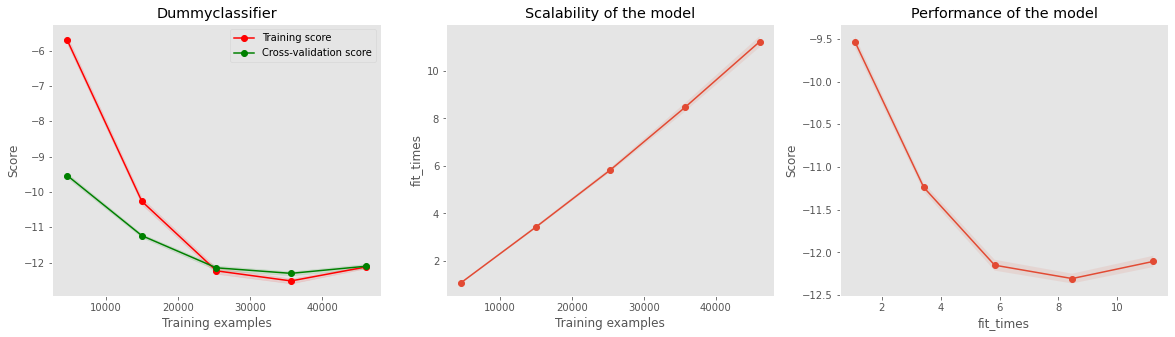

Log-loss: 10.157
Brier score: 0.294

              precision    recall  f1-score   support

           0       0.87      0.77      0.82     12598
           1       0.12      0.22      0.16      1796

    accuracy                           0.71     14394
   macro avg       0.50      0.50      0.49     14394
weighted avg       0.78      0.71      0.74     14394



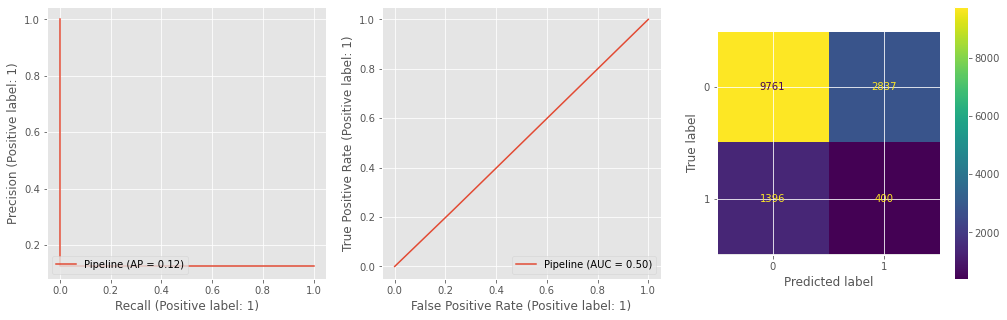

In [220]:
# instantiate transformers
preprocessor = make_preprocessor()
scaler = MinMaxScaler()

# cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True)

# scoring metrics
scoring = ['roc_auc', 'neg_log_loss', 'neg_brier_score', 'balanced_accuracy', 'f1', 'recall', 'precision']

# instantiate dummy classifier with stratified strategy
estimator = DummyClassifier(strategy="stratified", random_state=42)

# make classifier pipeline
clf = make_pipeline(preprocessor, scaler, estimator)

# run cross-validation
results = cross_validate(clf, X_train, y_train, scoring=scoring, cv=cv)

# print scores
score_cv_result(results)

# plot learning curve
plot_learning_curve(clf, 'Dummyclassifier', X_train, y_train, cv=cv, scoring='neg_log_loss')


## evaluate model with test dataset
eval_model(clf, X_train, y_train, X_test, y_test)

## LogisticRegression

Roc_auc avg score: 0.735, std: 0.003
Neg_log_loss avg score: -0.473, std: 0.001
Neg_brier_score avg score: -0.154, std: 0.000
Balanced_accuracy avg score: 0.558, std: 0.002
F1 avg score: 0.234, std: 0.007
Recall avg score: 0.146, std: 0.005
Precision avg score: 0.589, std: 0.018


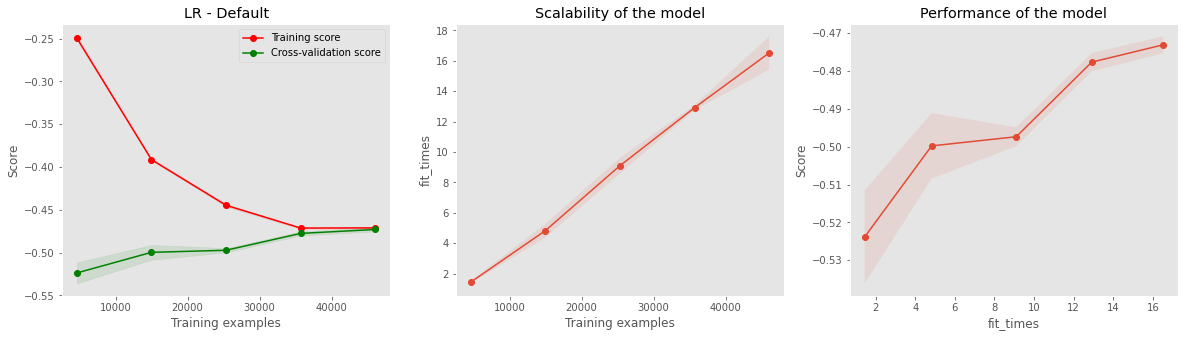

Log-loss: 0.370
Brier score: 0.110

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     12598
           1       0.42      0.05      0.09      1796

    accuracy                           0.87     14394
   macro avg       0.65      0.52      0.51     14394
weighted avg       0.82      0.87      0.83     14394



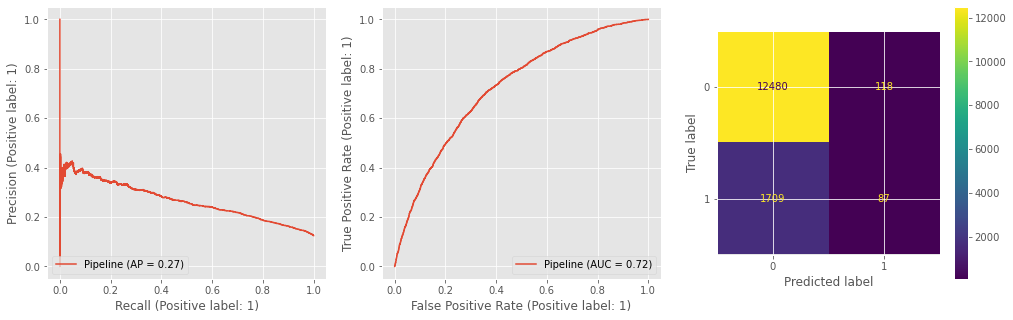

In [221]:
# instantiate Logisticregression classifier, default params
estimator = LogisticRegression(max_iter=1000)

# make classifier pipeline
clf = make_pipeline(preprocessor, scaler, estimator)

# run cross-validation
results = cross_validate(clf, X_train, y_train, scoring=scoring, cv=cv)

# print scores
score_cv_result(results)

# plot learning curve
plot_learning_curve(clf, 'LR - Default', X_train, y_train, cv=cv, scoring='neg_log_loss')


## evaluate model with test dataset
eval_model(clf, X_train, y_train, X_test, y_test)

All seems good!